# SARIMA with GRIDSEARCH_CV and PCA on ADM0, QUARTERLY

In [1]:
import pandas as pd

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

import warnings
warnings.simplefilter('ignore')

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
    
import time
import datetime

import os

## Model Specifications

In [2]:
TARGET_VARIABLE = "SUM(FATALITIES)"
SEASONAL_PERIODICITY = 4 # for data frequency & seasonality S

SEASONALITY = True
NEIGHBORS = False # X_N
SOCIO_ECO_VARS = False # X_SE
N_LAGS_X = 1 # todo: remove or change behavior from max lags to lag
DIM_REDUCTION_METHOD = "PCA"

if SEASONALITY:
    CV_FOLDS = 5
else:
    CV_FOLDS = 5

In [3]:
MODEL_NAME = ""
if SEASONALITY:
    MODEL_NAME += "S" 
    
MODEL_NAME += "ARIMA"

if SOCIO_ECO_VARS and NEIGHBORS:
    MODEL_NAME += "X_SE+N"
    
if SOCIO_ECO_VARS and not NEIGHBORS:
    MODEL_NAME += "X_SE"
    
if not SOCIO_ECO_VARS and NEIGHBORS:
    MODEL_NAME += "X_N"
    
if SEASONAL_PERIODICITY ==  12:
    MODEL_NAME += "_MONTHLY"
elif SEASONAL_PERIODICITY == 4:
    MODEL_NAME += "_QUARTERLY"

MODEL_NAME

'SARIMA_QUARTERLY'

### Hyperparameter Grid

In [4]:
# create a set of sarima configs to try
PARAM_GRID = list()
# parameter options to try

### PCA
if NEIGHBORS or SOCIO_ECO_VARS:
    n_components = range(0, 4) # include up to three main components
else:
    n_components = [0]
    

### ARMA
p_params = range(4) # AR 3
d_params = range(2) # Differencing 1
q_params = range(4) # MA 3


### SEASONALITY
if SEASONALITY:
    P_params = range(3) # 5
    D_params = range(2) # 1
    Q_params = range(3) # 2
    
    ### TREND
    # t_params = ['n','c','t','ct'] # Form of Trend
    # t_params = ['n', 't', 'ct'] # Form of Trend
    t_params = ["n"]

    ### SEASONAL PERIODICITY
    m_params = [SEASONAL_PERIODICITY]   
else:
    P_params = [0]
    D_params = [0]
    Q_params = [0]

    t_params = ["n"] # Form of Trend

    m_params = [0] 

for n in n_components:
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                for t in t_params:
                                    cfg = [n, (p, d, q), (P, D, Q, m), t]
                                    PARAM_GRID.append(cfg)
len(PARAM_GRID)    

576

## Model Training

In [5]:
from common_functions import *
from forecasters import *

#### Training Method

In [6]:
def sarimax(target_variable="SUM(FATALITIES)", 
            target_country="MLI", 
            predictor_countries=["BFA"], 
            n_lags_X = N_LAGS_X, 
            seasonal_periodicity = SEASONAL_PERIODICITY):
        
    ### GET DATA
    y, X = getData(target_variable = target_variable, 
                   target_country = target_country, 
                   predictor_countries = predictor_countries,
                   socio_eco_vars = SOCIO_ECO_VARS,
                   n_lags_X = N_LAGS_X, 
                   seasonal_periodicity = SEASONAL_PERIODICITY)
    
    ### SPLIT DATA
    X_train, X_test, y_train, y_test = train_test_split(y = y,
                                                        X = X, 
                                                        forecast_horizon = SEASONAL_PERIODICITY)
    
    ### TRAINING WITH GRIDSEARCHCV
    gscv = GridSearchCV(param_grid = PARAM_GRID,
                        forecaster = TimeSeriesForecasterPCA_LinInt,
                        seasonal_periodicity = SEASONAL_PERIODICITY,
                        cv_folds = CV_FOLDS)
    training_res = gscv.train(X_train, y_train)

    if training_res is not None:
        model = gscv
        # print ARIMA summary
        print(training_res)
        print(model.best_model_result.mle_retvals)
        plt.tight_layout()
        try:
            model.best_model_result.plot_diagnostics(figsize=(16*0.7, 10*0.7), lags = SEASONAL_PERIODICITY+1)
        except: 
            pass
        best_parameters = str(model.best_model_cv_results)
        
    else:
        print("No model fitted --> Prediction with Naive Model ")
        model = NoChange().fit(X_train, y_train)
        best_parameters = np.nan
        
    ### PREDICTION
    prediction_results = model.evaluate_model(X_test, y_test, fh = SEASONAL_PERIODICITY)
    
    if prediction_results["FAT_PRED"].isnull().values.any():
        model = NoChange().fit(X_train, y_train)
        print("Model Prediction failed --> Prediction with Naive Model ")
        model = NoChange().fit(X_train, y_train)
        best_parameters = np.nan
        prediction_results = model.evaluate_model(X_test, y_test, fh = SEASONAL_PERIODICITY)
    
    ### ADJUST RESULT DF
    prediction_results["GID_0"] = target_country
    prediction_results["MONTH"] = pd.to_datetime(prediction_results["MONTH"].astype(str)) 
    prediction_results["PARAMETERS"] = best_parameters

    print(prediction_results)

    return prediction_results

#### Automated Training for all 234 Countries 

In [7]:
acled_monthly_adm0 = pd.read_csv("../data/TB003_EVENT_OUTCOMES_MONTHLY_START_DATE.csv")
gid0_neighbors = pd.read_csv("../data/GID_0_Neighbours.csv")
# gid_list = acled_monthly_adm0["GID_0"].unique()[::-1] #reverse
gid_list = acled_monthly_adm0["GID_0"].unique()
len(gid_list)

234

File already exists.
######## ABW (1/234) #########
4
Model for this country has already been fitted.
######## AFG (2/234) #########
4
Model for this country has already been fitted.
######## AGO (3/234) #########
4
Model for this country has already been fitted.
######## AIA (4/234) #########
4
Model for this country has already been fitted.
######## ALA (5/234) #########
4
Model for this country has already been fitted.
######## ALB (6/234) #########
4
Model for this country has already been fitted.
######## AND (7/234) #########
4
Model for this country has already been fitted.
######## ARE (8/234) #########
4
Model for this country has already been fitted.
######## ARG (9/234) #########
4
Model for this country has already been fitted.
######## ARM (10/234) #########
4
Model for this country has already been fitted.
######## ASM (11/234) #########
4
Model for this country has already been fitted.
######## ATA (12/234) #########
4
Model for this country has already been fitted.
####

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], 'cv_score': 0.8129899799635802, 'fold_results': [0.6597643324038145, 0.7224740028238161, 0.7360075295979636, 0.7829460682743181, 1.163757966717989]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_SLE   No. Observations:                   96
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                -147.433
Date:                           Wed, 19 Oct 2022   AIC                            298.867
Time:                                   19:37:42   BIC                            303.889
Sample:                               04-30-1997   HQIC                           300.893
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z     

<Figure size 432x288 with 0 Axes>

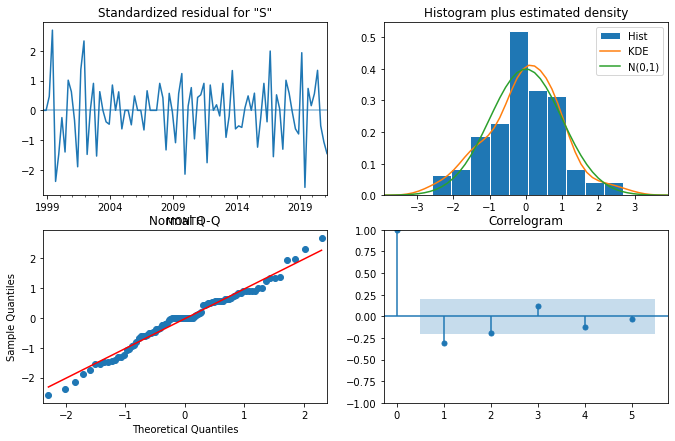

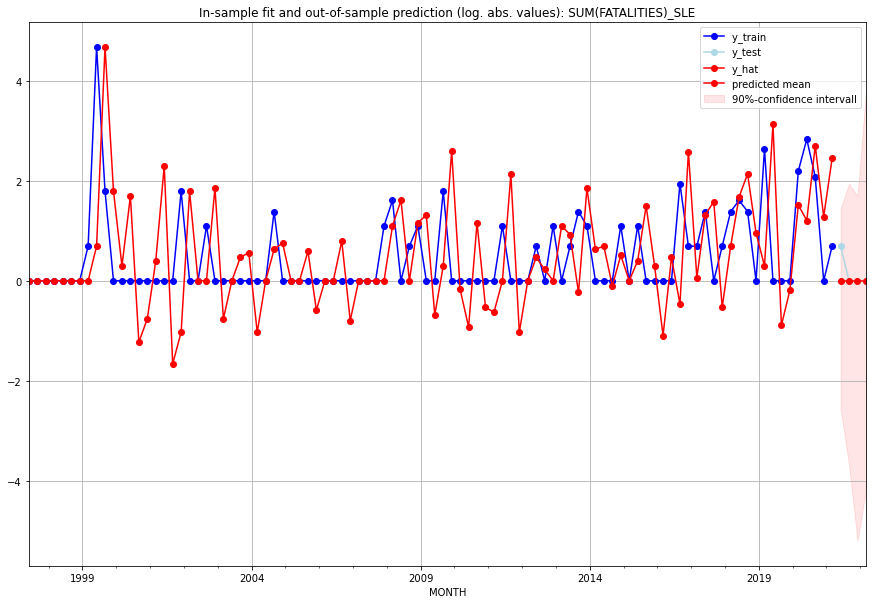

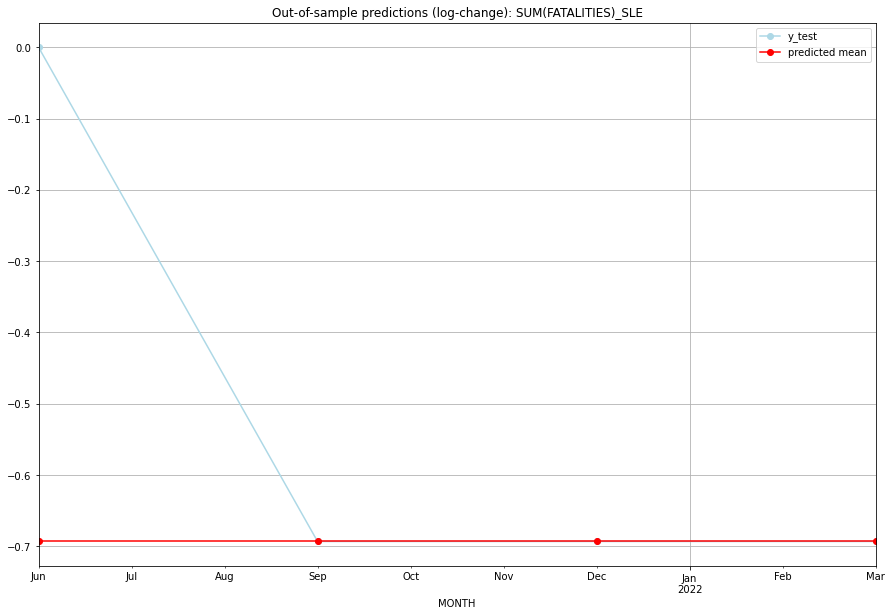

TADDA: 0.17328679513998632
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         1.0     -0.693147        0.000000   SLE   
1 2021-07-01       0.0         0.0     -0.693147       -0.693147   SLE   
2 2021-10-01       0.0         0.0     -0.693147       -0.693147   SLE   
3 2022-01-01       0.0         0.0     -0.693147       -0.693147   SLE   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
1  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
2  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
3  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
Execution time: 04:02
######## SLV (186/234) #########
0
Neighbor countries: []
Getting Data for SLV
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cor

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (1, 1, 0), (2, 1, 2, 4), 'n'], 'cv_score': 0.15703945896614713, 'fold_results': [nan, 0.15703945896614713]}
Training finished.
                                       SARIMAX Results                                        
Dep. Variable:                    SUM(FATALITIES)_SLV   No. Observations:                   13
Model:             SARIMAX(1, 1, 0)x(2, 1, [1, 2], 4)   Log Likelihood                  -5.084
Date:                                Wed, 19 Oct 2022   AIC                             22.168
Time:                                        19:38:47   BIC                             22.644
Sample:                                    01-31-2018   HQIC                            18.953
                                         - 01-31-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

<Figure size 432x288 with 0 Axes>

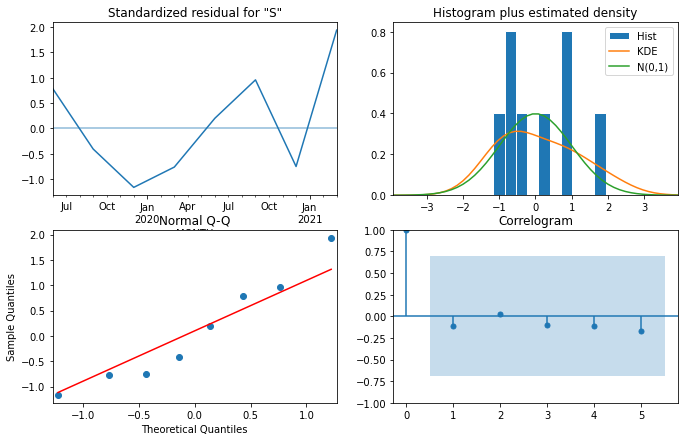

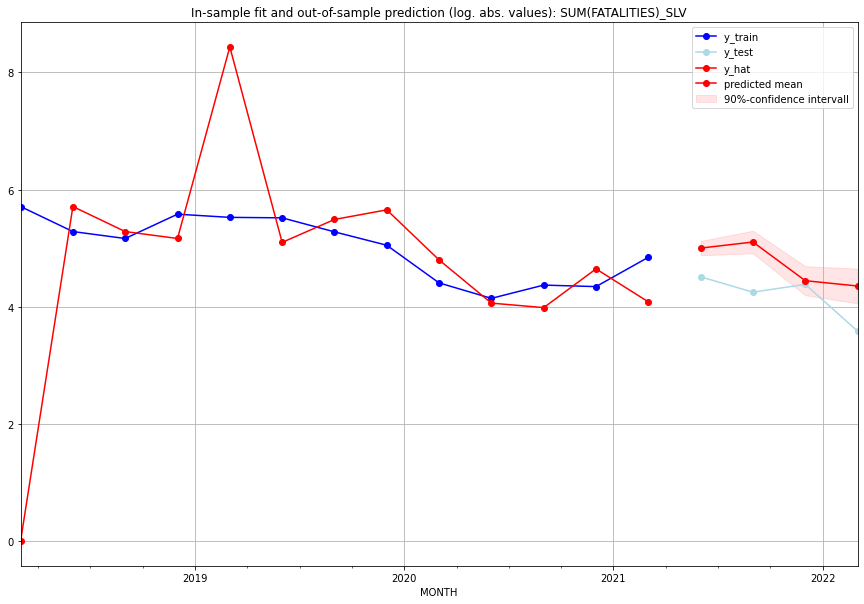

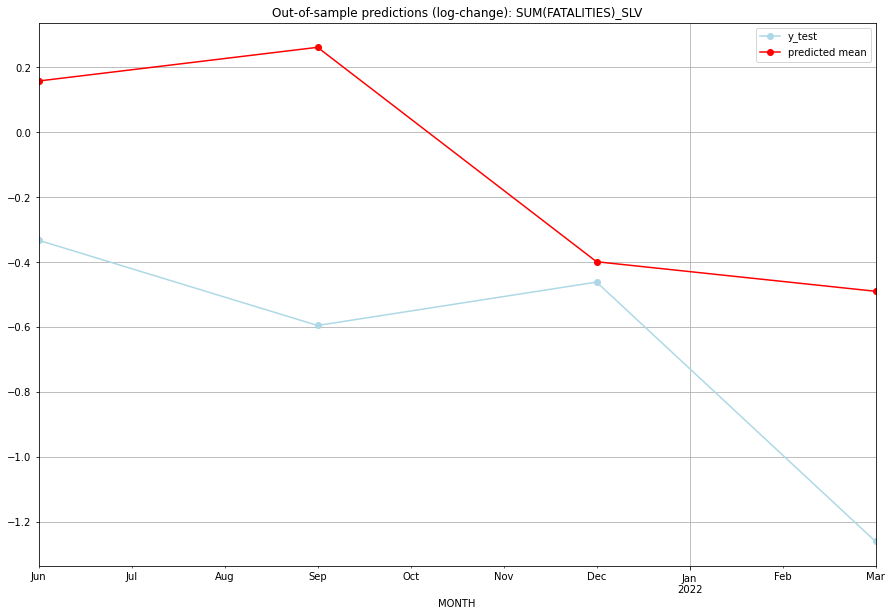

TADDA: 0.6491964103580965
Evaluation finished.
       MONTH    FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  147.568751        90.0      0.156861       -0.333328   SLV   
1 2021-07-01  163.807200        69.0      0.260589       -0.595692   SLV   
2 2021-10-01   84.171765        79.0     -0.399517       -0.462160   SLV   
3 2022-01-01   76.768924        35.0     -0.490445       -1.260668   SLV   

                                          PARAMETERS  
0  {'params': [0, (1, 1, 0), (2, 1, 2, 4), 'n'], ...  
1  {'params': [0, (1, 1, 0), (2, 1, 2, 4), 'n'], ...  
2  {'params': [0, (1, 1, 0), (2, 1, 2, 4), 'n'], ...  
3  {'params': [0, (1, 1, 0), (2, 1, 2, 4), 'n'], ...  
Execution time: 01:04
######## SMR (187/234) #########
0
Neighbor countries: []
Getting Data for SMR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 0)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insuf

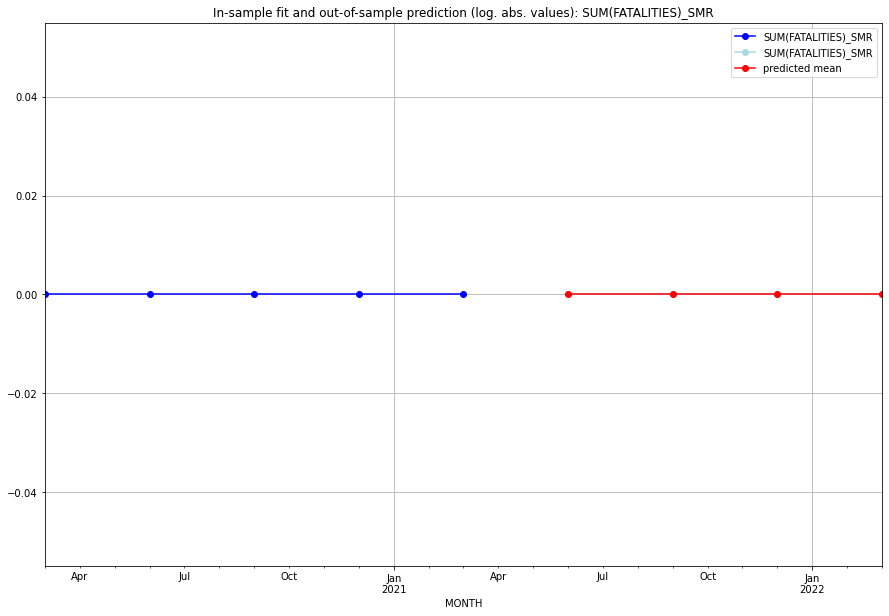

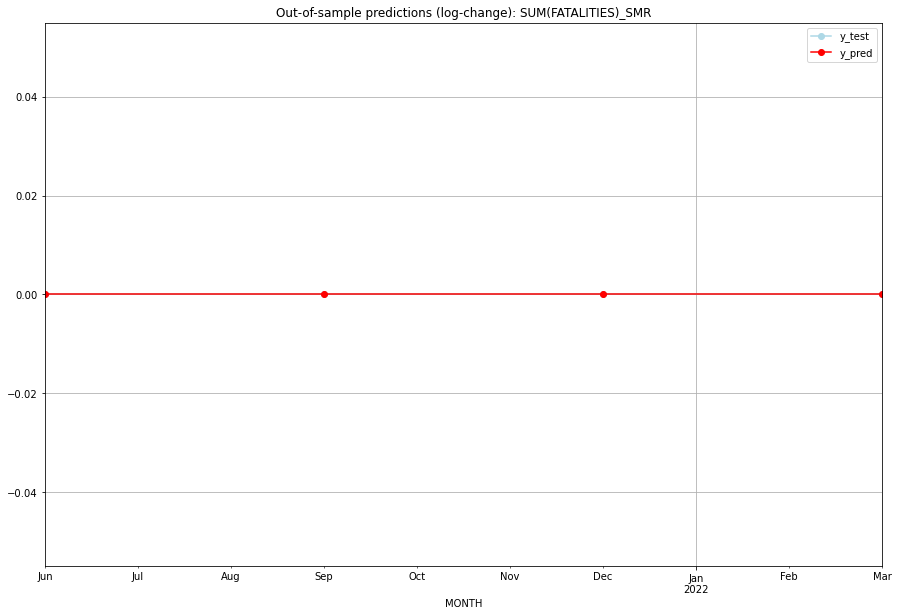

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   SMR   
1 2021-07-01       0.0         0.0           0.0             0.0   SMR   
2 2021-10-01       0.0         0.0           0.0             0.0   SMR   
3 2022-01-01       0.0         0.0           0.0             0.0   SMR   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## SOM (188/234) #########
0
Neighbor countries: []
Getting Data for SOM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 1), (0, 0, 2, 4), 'n'], 'cv_score': 0.26073433596218554, 'fold_results': [0.24185935827022442, 0.2131555669747316, 0.3578041152440561, 0.2878724602525431, 0.20298017906937238]}
Training finished.
                                       SARIMAX Results                                        
Dep. Variable:                    SUM(FATALITIES)_SOM   No. Observations:                   96
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                -123.536
Date:                                Wed, 19 Oct 2022   AIC                            255.071
Time:                                        19:41:24   BIC                            265.287
Sample:                                    04-30-1997   HQIC                           259.199
                                         - 01-31-2021                                         
Covariance Type:                                  opg                                         
    

<Figure size 432x288 with 0 Axes>

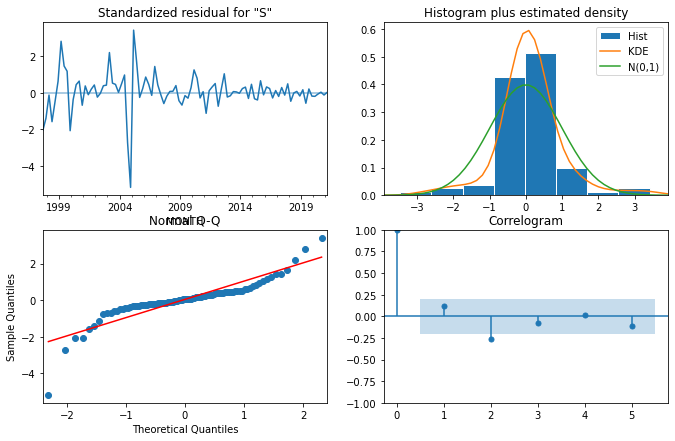

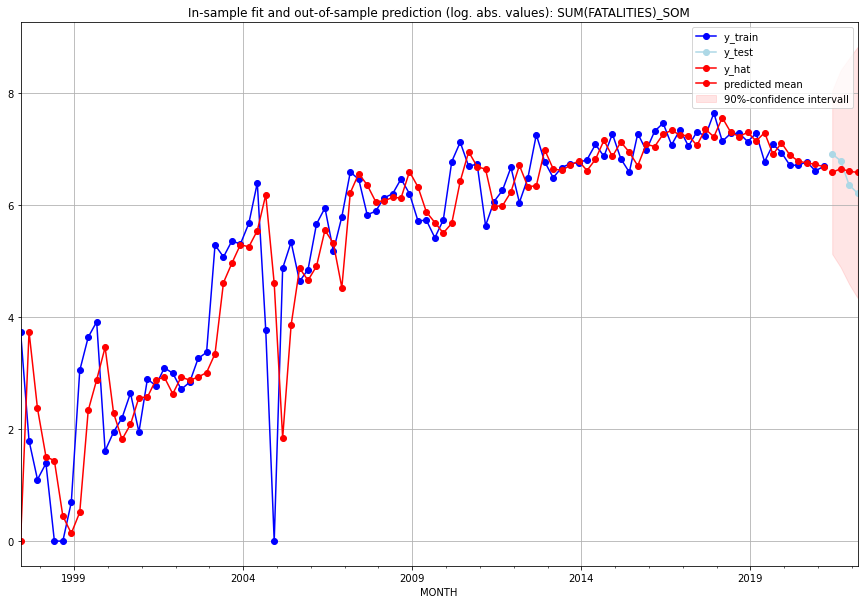

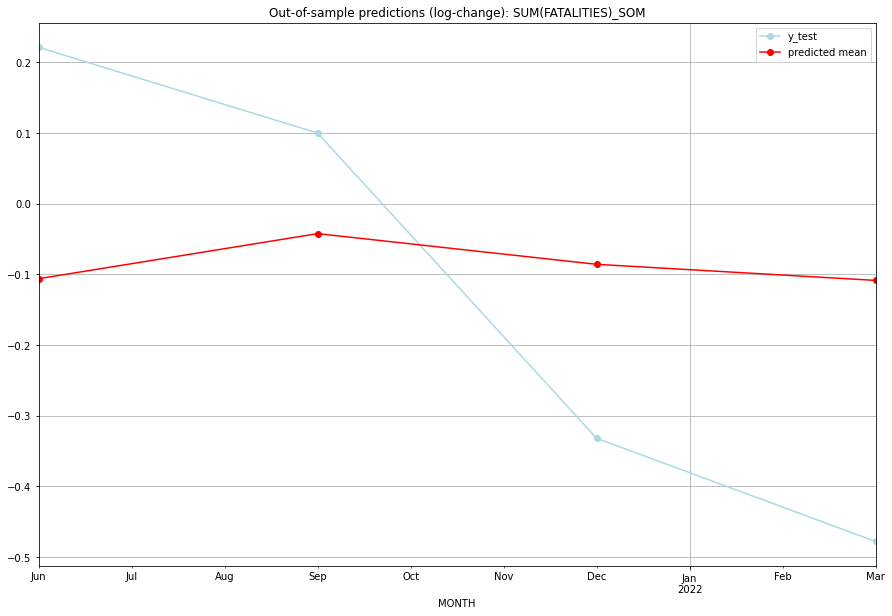

TADDA: 0.3084972980467571
Evaluation finished.
       MONTH    FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  718.343228       997.0     -0.106273        0.221142   SOM   
1 2021-07-01  765.726546       883.0     -0.042482        0.099845   SOM   
2 2021-10-01  733.162789       573.0     -0.085881       -0.331982   SOM   
3 2022-01-01  716.639666       495.0     -0.108644       -0.478036   SOM   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 1), (0, 0, 2, 4), 'n'], ...  
1  {'params': [0, (0, 1, 1), (0, 0, 2, 4), 'n'], ...  
2  {'params': [0, (0, 1, 1), (0, 0, 2, 4), 'n'], ...  
3  {'params': [0, (0, 1, 1), (0, 0, 2, 4), 'n'], ...  
Execution time: 02:35
######## SRB (189/234) #########
0
Neighbor countries: []
Getting Data for SRB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 4

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], 'cv_score': 0.0, 'fold_results': [nan, 0.0]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_SRB   No. Observations:                   13
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                  -5.071
Date:                           Wed, 19 Oct 2022   AIC                             14.143
Time:                                   19:42:19   BIC                             14.302
Sample:                               01-31-2018   HQIC                            13.071
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

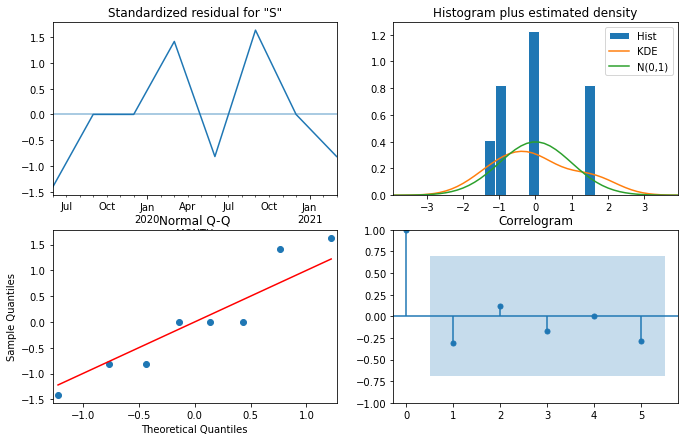

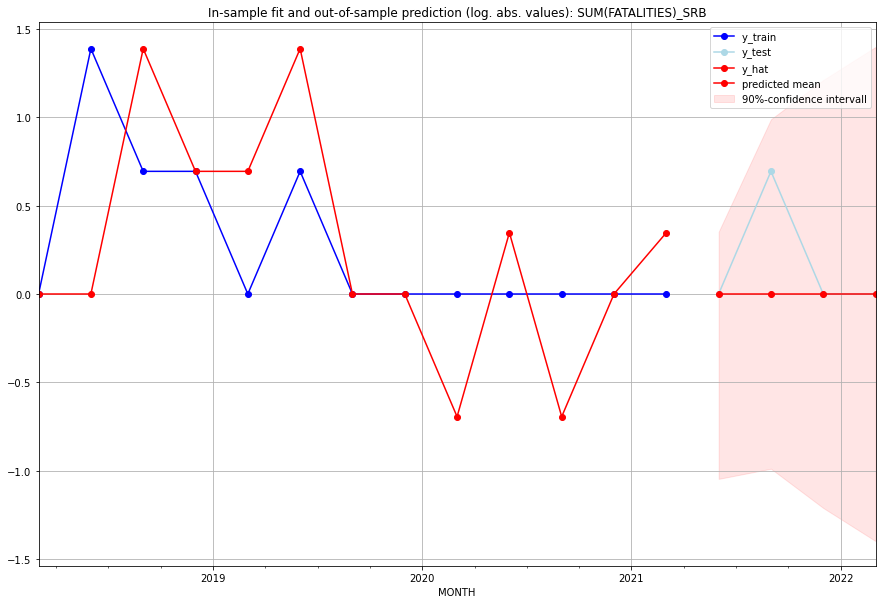

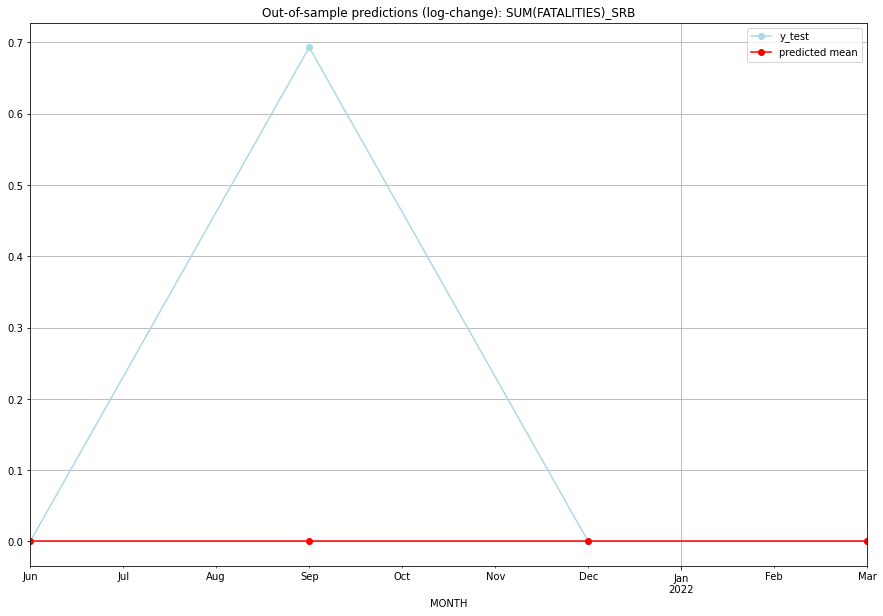

TADDA: 0.17328679513998632
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0        0.000000   SRB   
1 2021-07-01       0.0         1.0           0.0        0.693147   SRB   
2 2021-10-01       0.0         0.0           0.0        0.000000   SRB   
3 2022-01-01       0.0         0.0           0.0        0.000000   SRB   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
1  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
2  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
3  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
Execution time: 00:55
######## SSD (190/234) #########
0
Neighbor countries: []
Getting Data for SSD
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU c

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (1, 1, 0), (0, 0, 0, 4), 'n'], 'cv_score': 0.5857891518998084, 'fold_results': [0.5456235628259258, 0.1709467598608907, 1.0185712017213453, 0.39290030863772807, 0.8009039264531523]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_SSD   No. Observations:                   96
Model:                SARIMAX(1, 1, 0)   Log Likelihood                -144.785
Date:                 Wed, 19 Oct 2022   AIC                            293.570
Time:                         19:45:22   BIC                            298.677
Sample:                     04-30-1997   HQIC                           295.634
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

<Figure size 432x288 with 0 Axes>

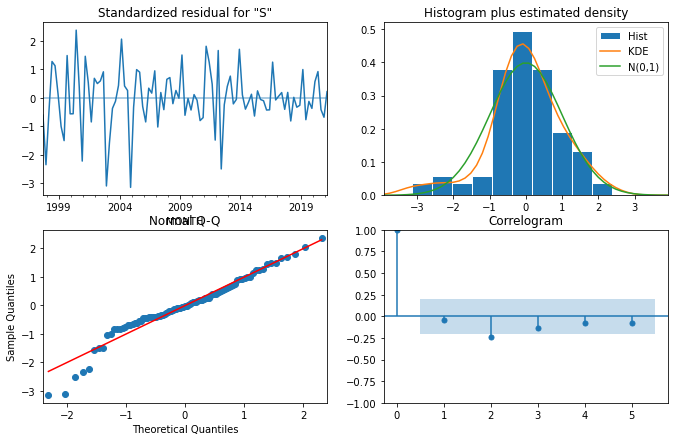

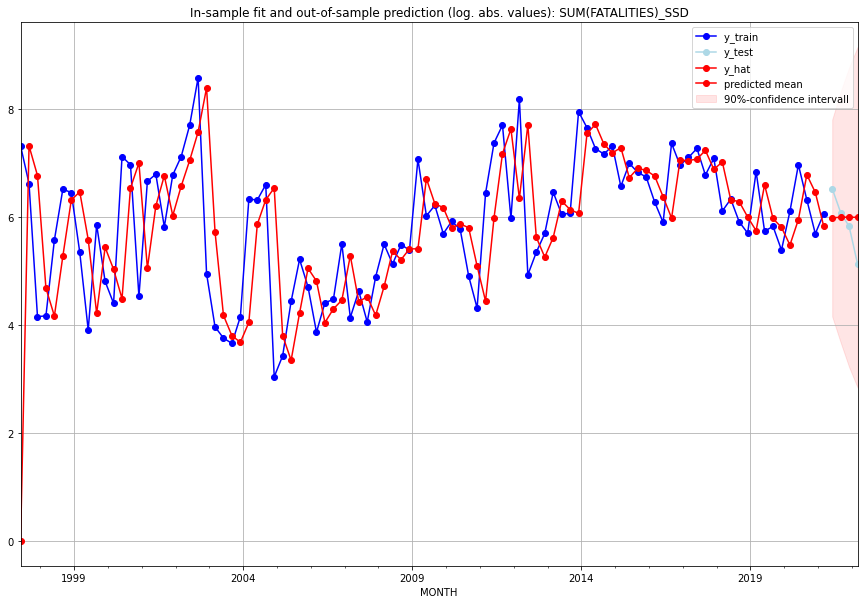

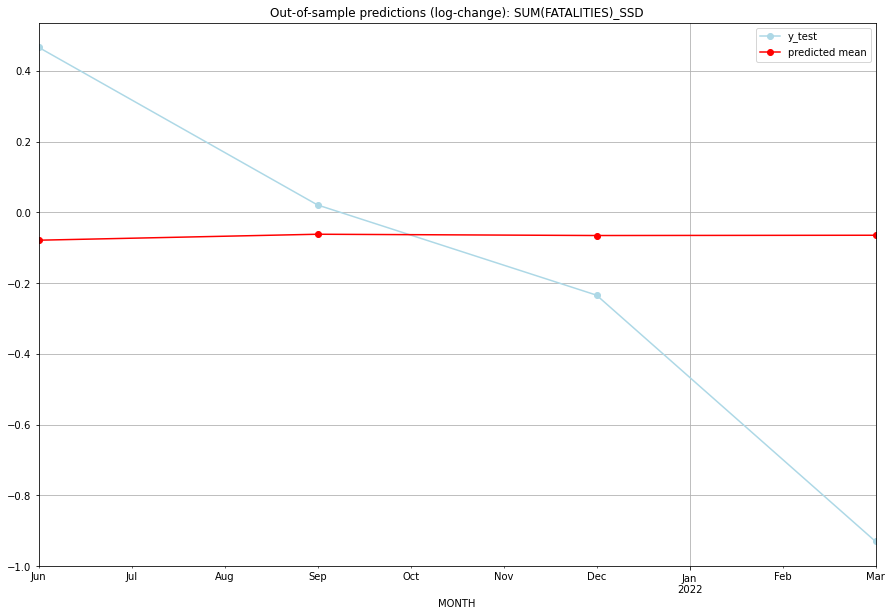

TADDA: 0.45069612582167595
Evaluation finished.
       MONTH    FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  397.301229       686.0     -0.078900        0.466226   SSD   
1 2021-07-01  404.077411       439.0     -0.062030        0.020667   SSD   
2 2021-10-01  402.618964       340.0     -0.065637       -0.234226   SSD   
3 2022-01-01  402.930354       169.0     -0.064866       -0.930310   SSD   

                                          PARAMETERS  
0  {'params': [0, (1, 1, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (1, 1, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (1, 1, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (1, 1, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 03:02
######## STP (191/234) #########
0
Neighbor countries: []
Getting Data for STP
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV o

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], 'cv_score': 0.0, 'fold_results': [0.0, 0.0, 0.0, 0.0, 0.0]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_STP   No. Observations:                   96
Model:                         SARIMAX   Log Likelihood                 118.056
Date:                 Wed, 19 Oct 2022   AIC                           -234.112
Time:                         19:46:48   BIC                           -231.547
Sample:                     04-30-1997   HQIC                          -233.075
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0050      0.000     47.749      0.000     

<Figure size 432x288 with 0 Axes>

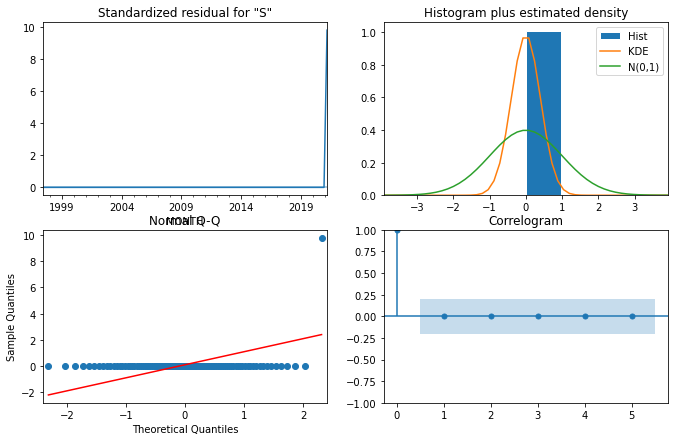

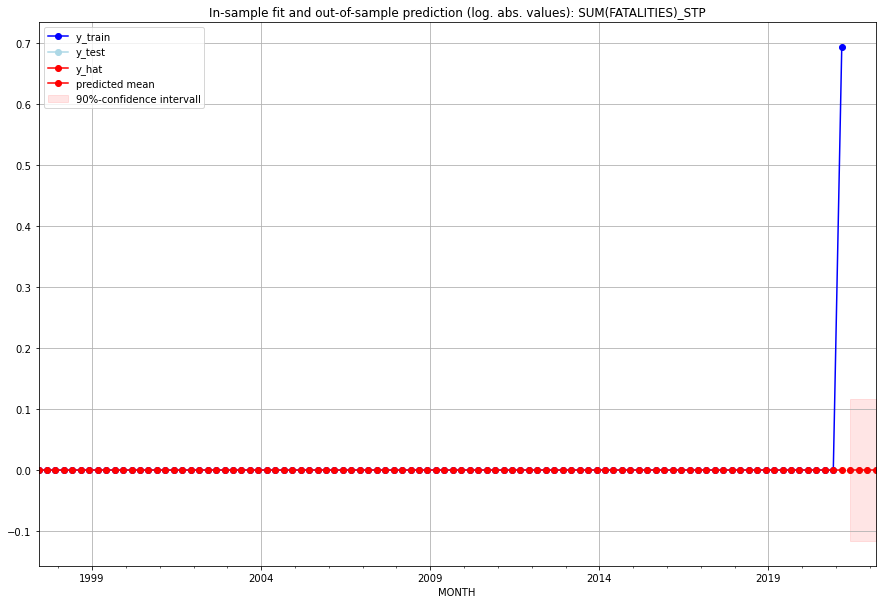

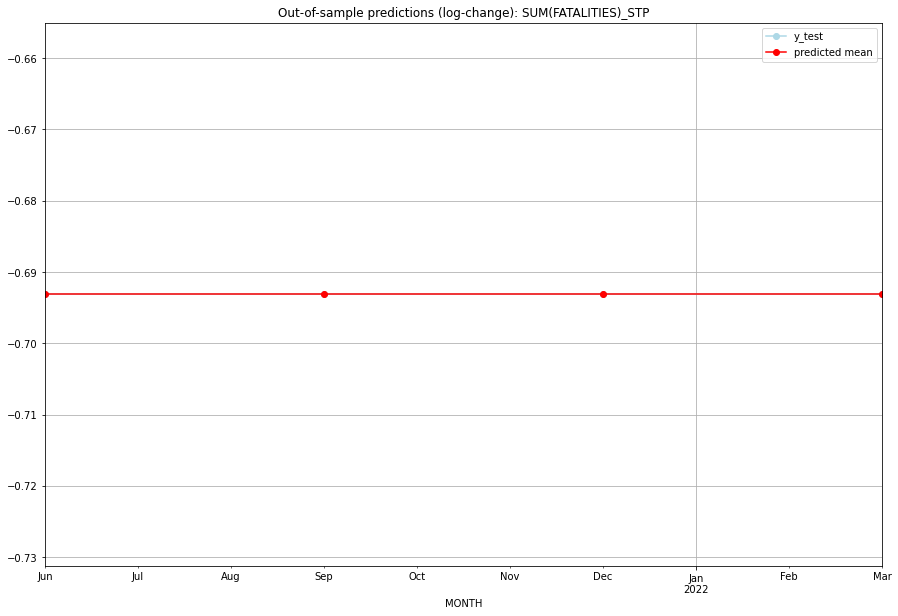

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0     -0.693147       -0.693147   STP   
1 2021-07-01       0.0         0.0     -0.693147       -0.693147   STP   
2 2021-10-01       0.0         0.0     -0.693147       -0.693147   STP   
3 2022-01-01       0.0         0.0     -0.693147       -0.693147   STP   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 01:25
######## SUR (192/234) #########
0
Neighbor countries: []
Getting Data for SUR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 paramete

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 0, 2), (1, 0, 1, 4), 'n'], 'cv_score': 0.1920306012153783, 'fold_results': [0.16393254381726619, 0.11389046256339724, 0.09794658204752583, 0.3923528164333239, nan]}
Training finished.
                                      SARIMAX Results                                      
Dep. Variable:                 SUM(FATALITIES)_SWZ   No. Observations:                   96
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 4)   Log Likelihood                 -37.530
Date:                             Wed, 19 Oct 2022   AIC                             89.061
Time:                                     19:50:20   BIC                            107.011
Sample:                                 04-30-1997   HQIC                            96.317
                                      - 01-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z

<Figure size 432x288 with 0 Axes>

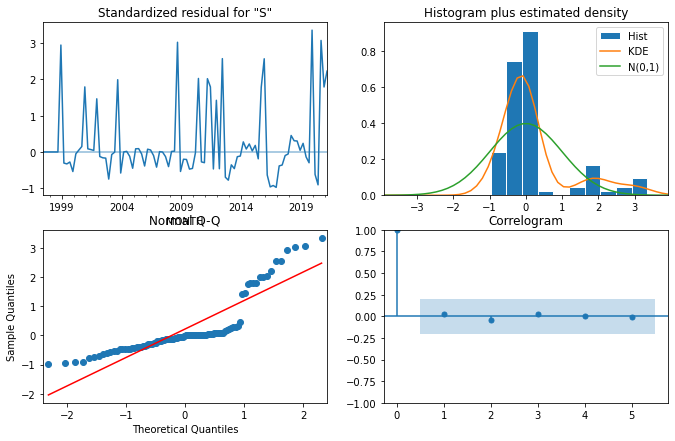

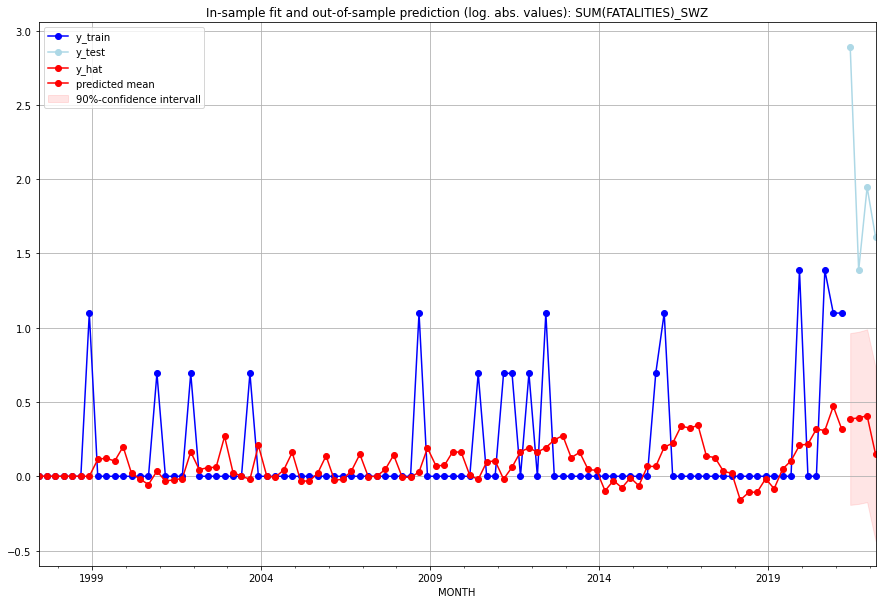

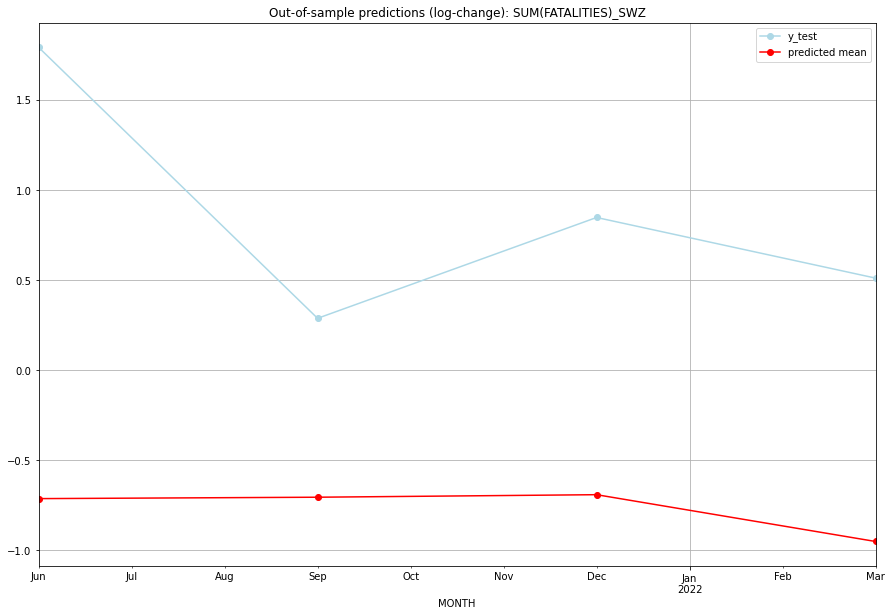

TADDA: 2.389501978095171
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  0.470563        17.0     -0.712967        1.791759   SWZ   
1 2021-07-01  0.482043         3.0     -0.705191        0.287682   SWZ   
2 2021-10-01  0.502971         6.0     -0.691169        0.847298   SWZ   
3 2022-01-01  0.159185         4.0     -0.950895        0.510826   SWZ   

                                          PARAMETERS  
0  {'params': [0, (2, 0, 2), (1, 0, 1, 4), 'n'], ...  
1  {'params': [0, (2, 0, 2), (1, 0, 1, 4), 'n'], ...  
2  {'params': [0, (2, 0, 2), (1, 0, 1, 4), 'n'], ...  
3  {'params': [0, (2, 0, 2), (1, 0, 1, 4), 'n'], ...  
Execution time: 02:44
######## SXM (197/234) #########
0
Neighbor countries: []
Getting Data for SXM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
y_train is all zero. No GSCV necess

<Figure size 432x288 with 0 Axes>

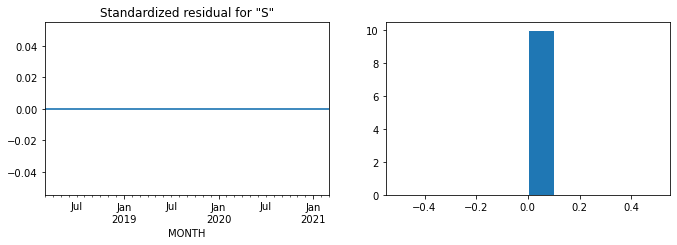

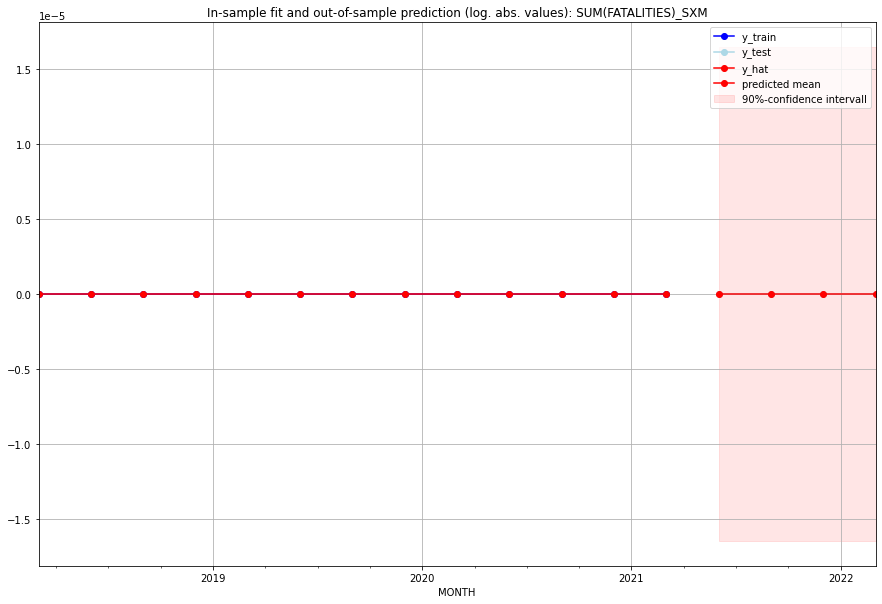

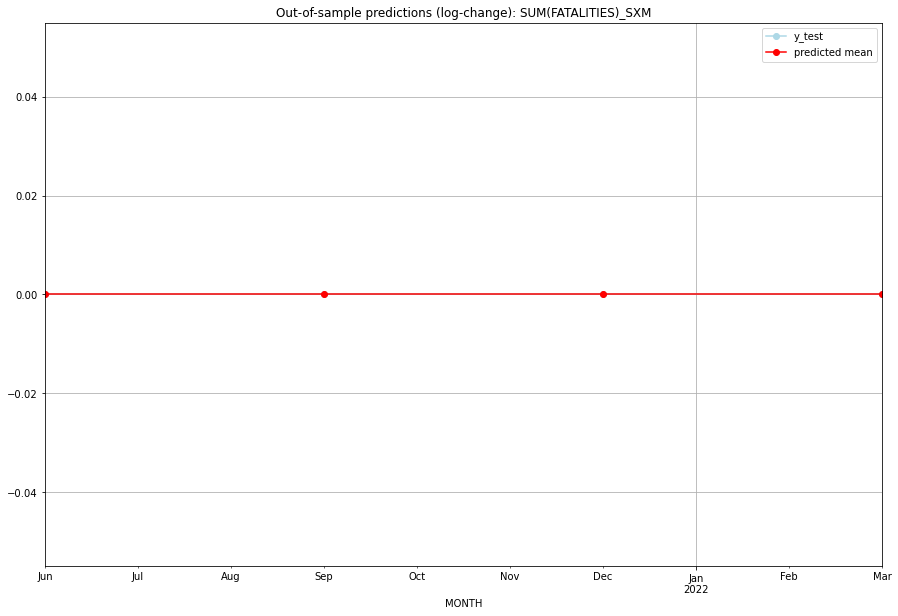

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   SXM   
1 2021-07-01       0.0         0.0           0.0             0.0   SXM   
2 2021-10-01       0.0         0.0           0.0             0.0   SXM   
3 2022-01-01       0.0         0.0           0.0             0.0   SXM   

  PARAMETERS  
0         {}  
1         {}  
2         {}  
3         {}  
Execution time: 00:06
######## SYC (198/234) #########
0
Neighbor countries: []
Getting Data for SYC
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
y_train is all zero. No GSCV necessary.
Best CV-Results
{}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_SYC   No. Observations:                   96
Model:   

<Figure size 432x288 with 0 Axes>

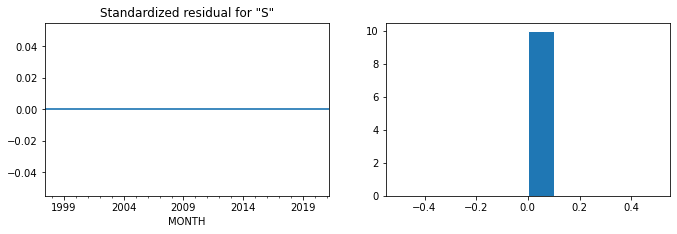

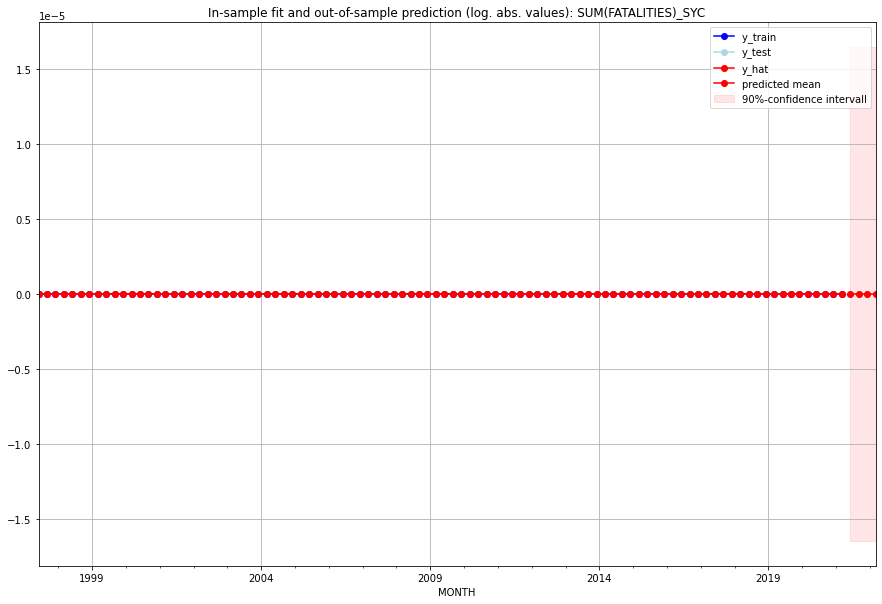

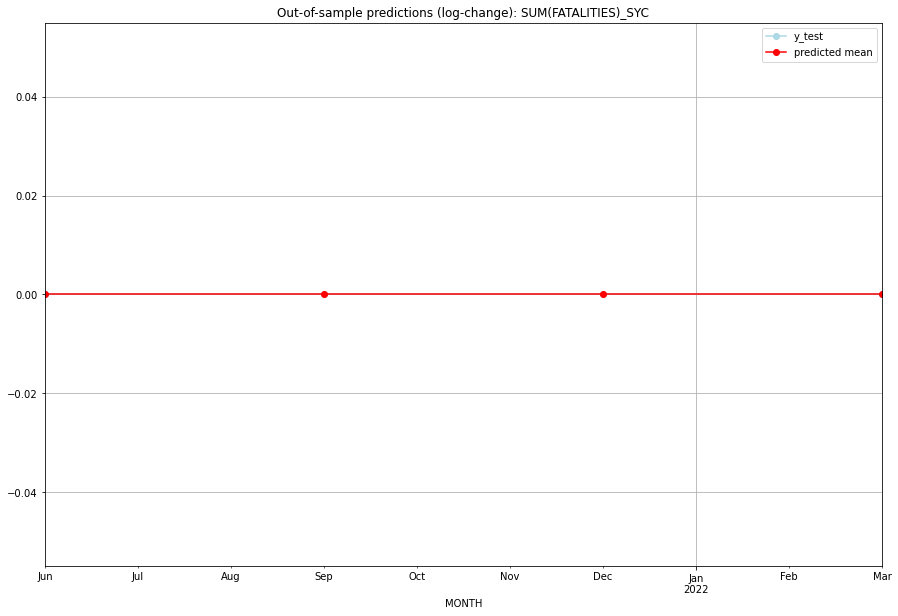

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   SYC   
1 2021-07-01       0.0         0.0           0.0             0.0   SYC   
2 2021-10-01       0.0         0.0           0.0             0.0   SYC   
3 2022-01-01       0.0         0.0           0.0             0.0   SYC   

  PARAMETERS  
0         {}  
1         {}  
2         {}  
3         {}  
Execution time: 00:06
######## SYR (199/234) #########
0
Neighbor countries: []
Getting Data for SYR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (21, 0)
y: (21, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (1, 0, 3), (2, 0, 0, 4), 'n'], 'cv_score': 0.15209893983485356, 'fold_results': [nan, 0.15209893983485356, nan]}
Training finished.
                                     SARIMAX Results                                      
Dep. Variable:                SUM(FATALITIES)_SYR   No. Observations:                   17
Model:             SARIMAX(1, 0, 3)x(2, 0, [], 4)   Log Likelihood                  -4.557
Date:                            Wed, 19 Oct 2022   AIC                             23.114
Time:                                    19:51:51   BIC                             28.946
Sample:                                01-31-2017   HQIC                            23.694
                                     - 01-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

<Figure size 432x288 with 0 Axes>

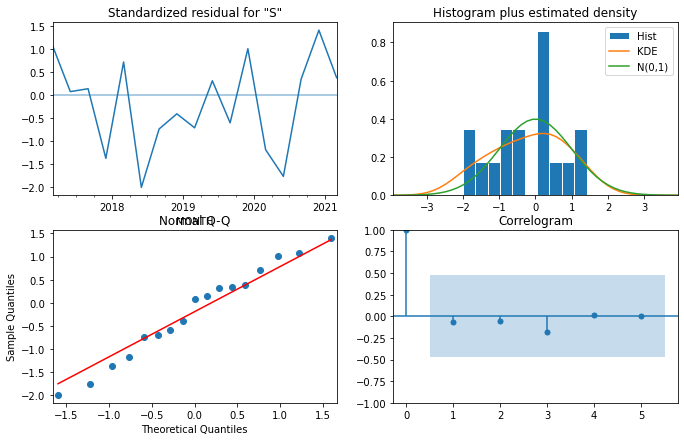

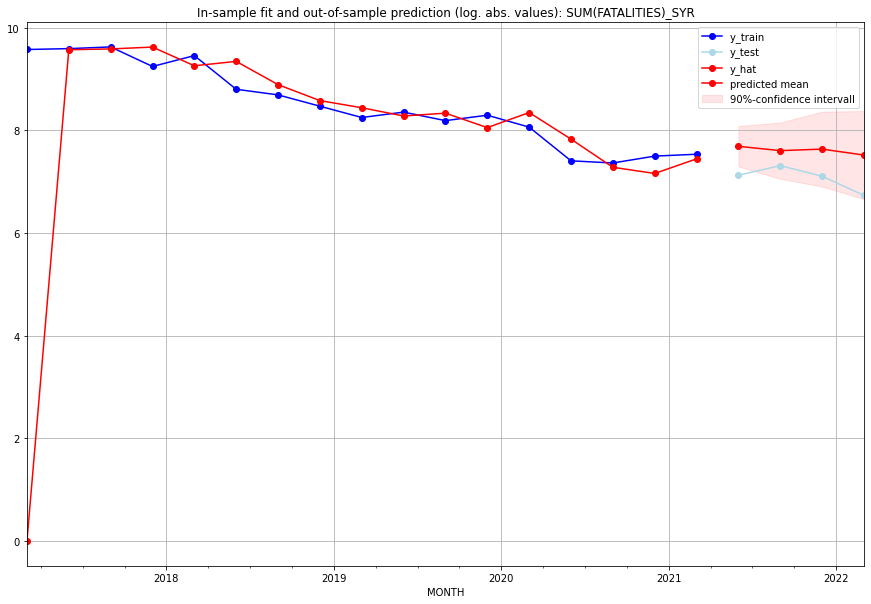

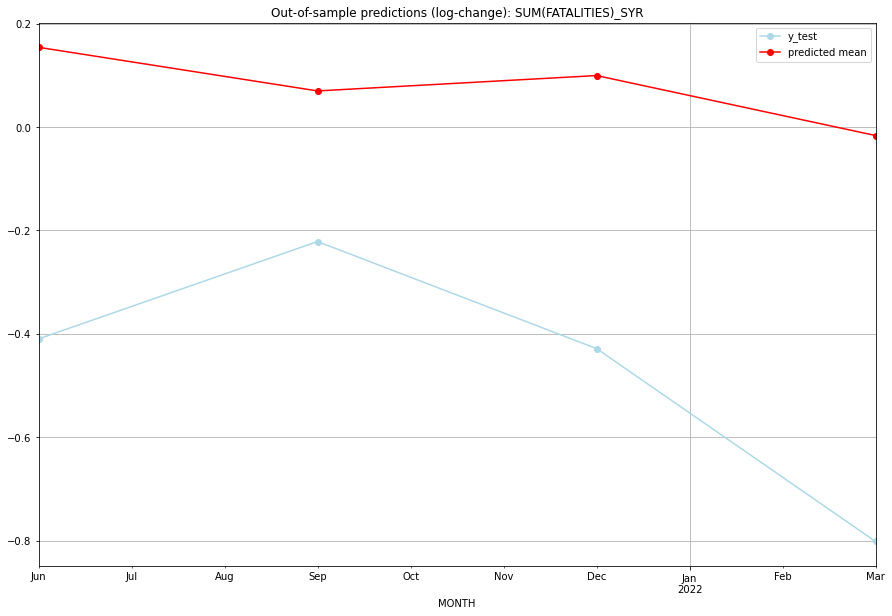

TADDA: 0.6232031142549779
Evaluation finished.
       MONTH     FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  2178.703266      1239.0      0.154320       -0.409757   SYR   
1 2021-07-01  2002.341545      1496.0      0.069948       -0.221405   SYR   
2 2021-10-01  2062.794088      1216.0      0.099678       -0.428480   SYR   
3 2022-01-01  1836.747833       837.0     -0.016328       -0.801606   SYR   

                                          PARAMETERS  
0  {'params': [0, (1, 0, 3), (2, 0, 0, 4), 'n'], ...  
1  {'params': [0, (1, 0, 3), (2, 0, 0, 4), 'n'], ...  
2  {'params': [0, (1, 0, 3), (2, 0, 0, 4), 'n'], ...  
3  {'params': [0, (1, 0, 3), (2, 0, 0, 4), 'n'], ...  
Execution time: 01:17
######## TCA (200/234) #########
0
Neighbor countries: []
Getting Data for TCA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
y_train is all zero

<Figure size 432x288 with 0 Axes>

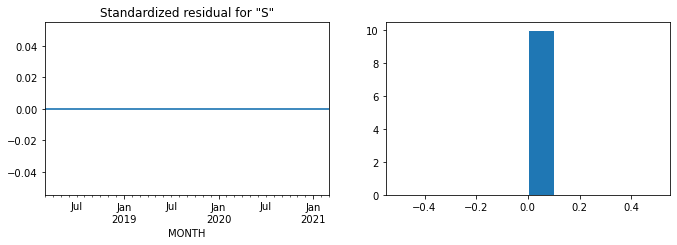

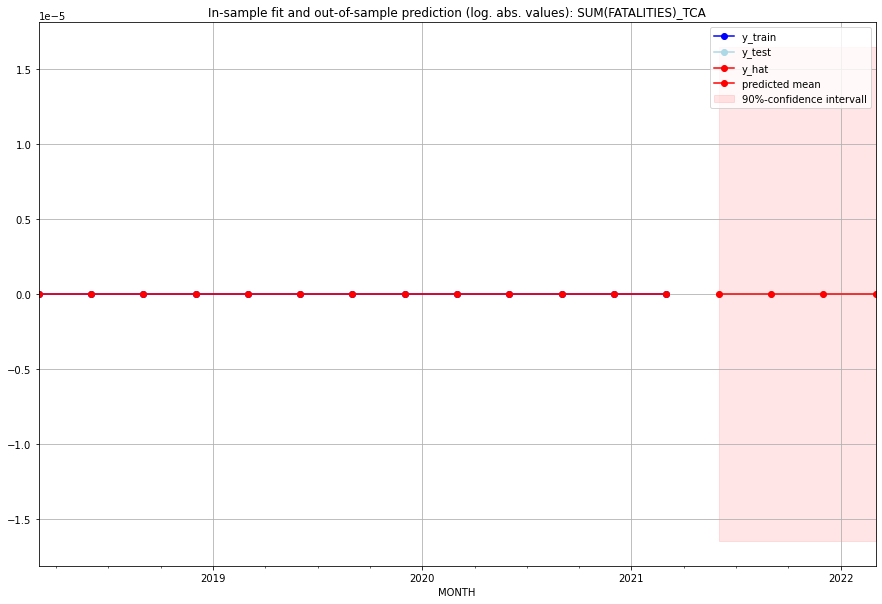

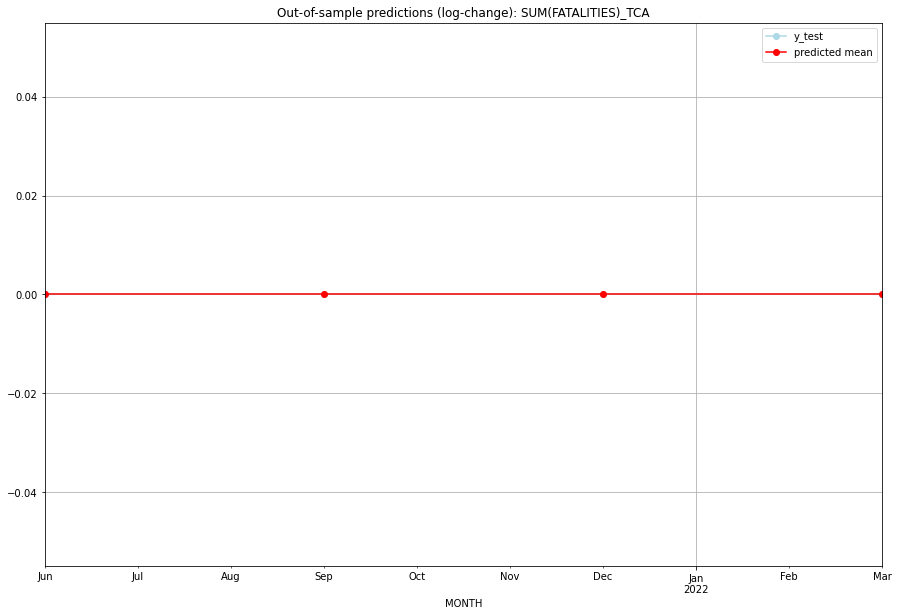

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   TCA   
1 2021-07-01       0.0         0.0           0.0             0.0   TCA   
2 2021-10-01       0.0         0.0           0.0             0.0   TCA   
3 2022-01-01       0.0         0.0           0.0             0.0   TCA   

  PARAMETERS  
0         {}  
1         {}  
2         {}  
3         {}  
Execution time: 00:03
######## TCD (201/234) #########
0
Neighbor countries: []
Getting Data for TCD
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (3, 1, 3), (2, 0, 0, 4), 'n'], 'cv_score': 1.0419823562845116, 'fold_results': [1.2475487428480192, 1.0383396589490035, 0.8157970188241199, 1.4307601049923346, 0.6774662558090807]}
Training finished.
                                     SARIMAX Results                                      
Dep. Variable:                SUM(FATALITIES)_TCD   No. Observations:                   96
Model:             SARIMAX(3, 1, 3)x(2, 0, [], 4)   Log Likelihood                -189.298
Date:                            Wed, 19 Oct 2022   AIC                            396.596
Time:                                    19:54:54   BIC                            419.581
Sample:                                04-30-1997   HQIC                           405.884
                                     - 01-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err       

<Figure size 432x288 with 0 Axes>

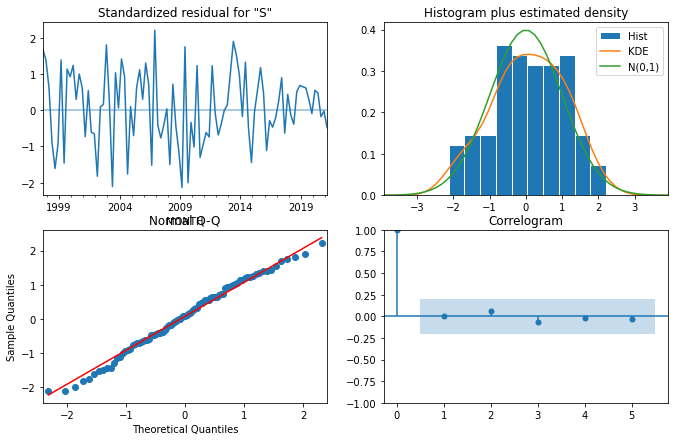

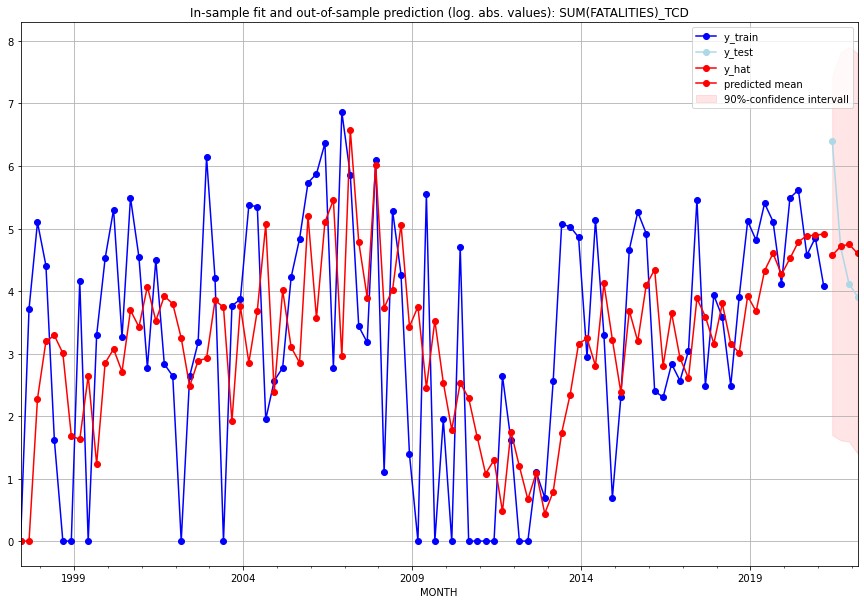

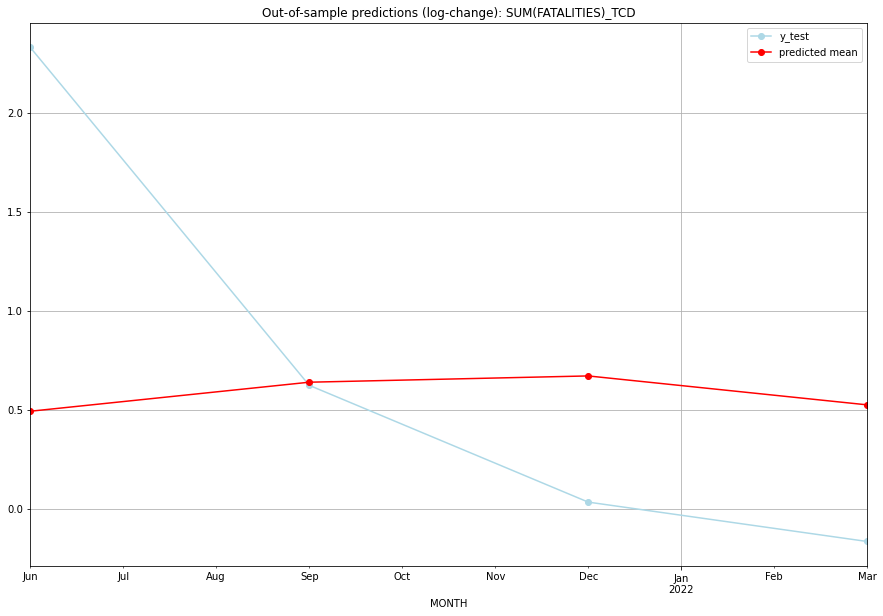

TADDA: 0.9259963348419015
Evaluation finished.
       MONTH    FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01   95.501837       605.0      0.492025        2.329343   TCD   
1 2021-07-01  110.735672       109.0      0.638599        0.622943   TCD   
2 2021-10-01  114.336784        60.0      0.670319        0.033336   TCD   
3 2022-01-01   98.663034        49.0      0.524257       -0.165514   TCD   

                                          PARAMETERS  
0  {'params': [0, (3, 1, 3), (2, 0, 0, 4), 'n'], ...  
1  {'params': [0, (3, 1, 3), (2, 0, 0, 4), 'n'], ...  
2  {'params': [0, (3, 1, 3), (2, 0, 0, 4), 'n'], ...  
3  {'params': [0, (3, 1, 3), (2, 0, 0, 4), 'n'], ...  
Execution time: 02:58
######## TGO (202/234) #########
0
Neighbor countries: []
Getting Data for TGO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 2), (0, 0, 0, 4), 'n'], 'cv_score': 0.8836005351103774, 'fold_results': [0.5055285027254677, 1.6990870795917834, 0.6543657172145834, 0.9389117685386252, 0.6201096074814276]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_TGO   No. Observations:                   96
Model:                SARIMAX(0, 1, 2)   Log Likelihood                -119.116
Date:                 Wed, 19 Oct 2022   AIC                            244.231
Time:                         19:58:04   BIC                            251.893
Sample:                     04-30-1997   HQIC                           247.327
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

<Figure size 432x288 with 0 Axes>

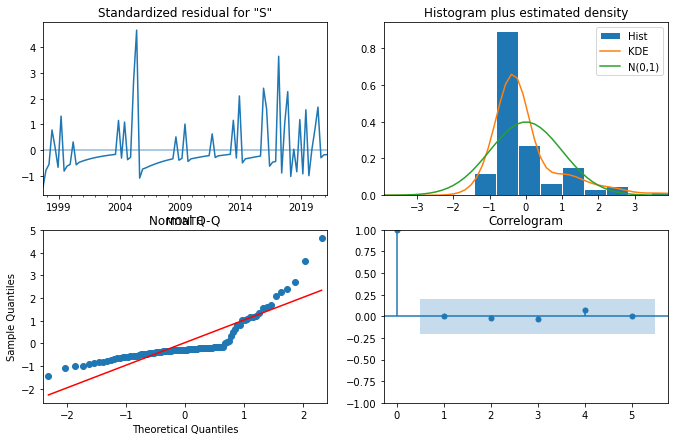

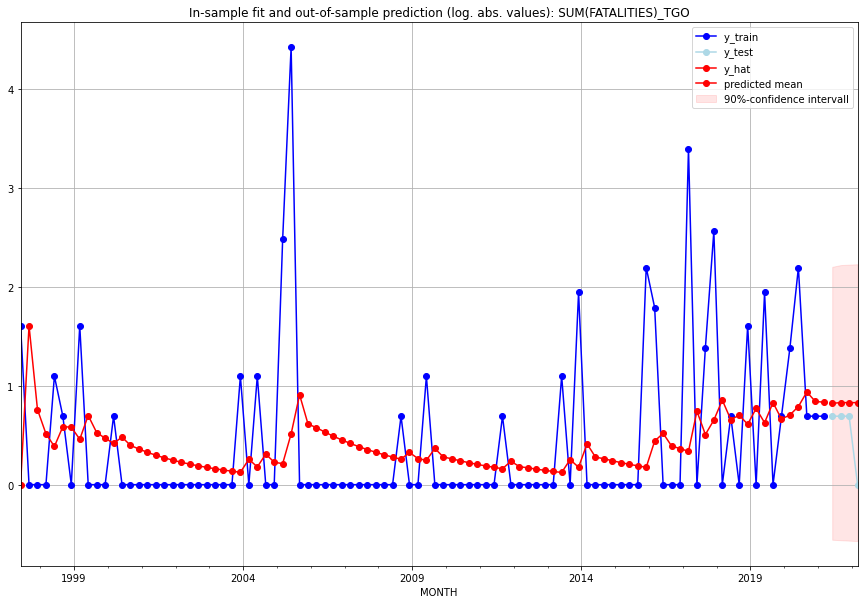

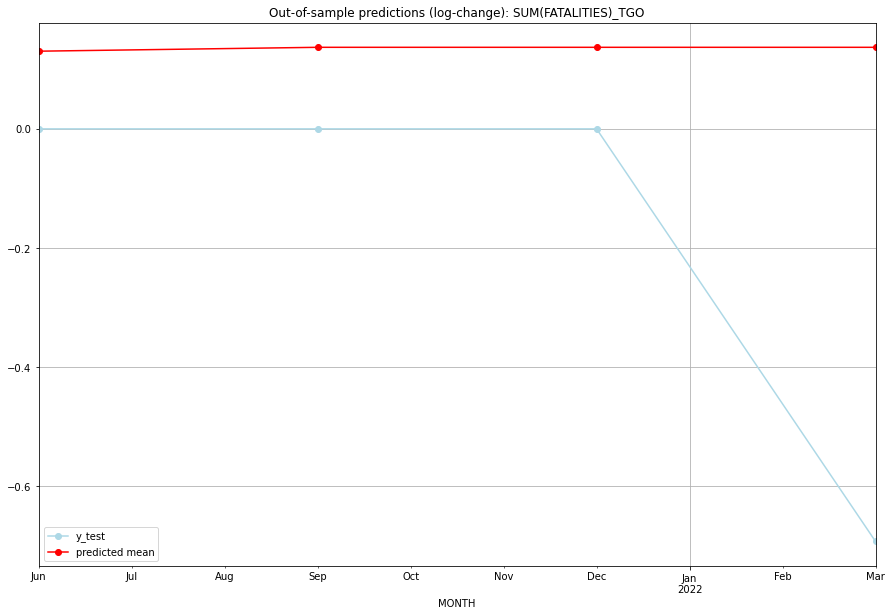

TADDA: 0.3428830660186732
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  1.278701         1.0      0.130459        0.000000   TGO   
1 2021-07-01  1.293614         1.0      0.136982        0.000000   TGO   
2 2021-10-01  1.293614         1.0      0.136982        0.000000   TGO   
3 2022-01-01  1.293614         0.0      0.136982       -0.693147   TGO   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 2), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 1, 2), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 1, 2), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 1, 2), (0, 0, 0, 4), 'n'], ...  
Execution time: 03:10
######## THA (203/234) #########
0
Neighbor countries: []
Getting Data for THA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (49, 0)
y: (49, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU core

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 1), (2, 0, 2, 4), 'n'], 'cv_score': 0.4633296276623734, 'fold_results': [0.33741984412824755, 0.43766752994826985, nan, 0.10782364080867313, 0.9704074957643032]}
Training finished.
                                       SARIMAX Results                                        
Dep. Variable:                    SUM(FATALITIES)_THA   No. Observations:                   45
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 4)   Log Likelihood                 -25.727
Date:                                Wed, 19 Oct 2022   AIC                             63.455
Time:                                        20:00:46   BIC                             74.160
Sample:                                    01-31-2010   HQIC                            67.425
                                         - 01-31-2021                                         
Covariance Type:                                  opg                                         
                 co

<Figure size 432x288 with 0 Axes>

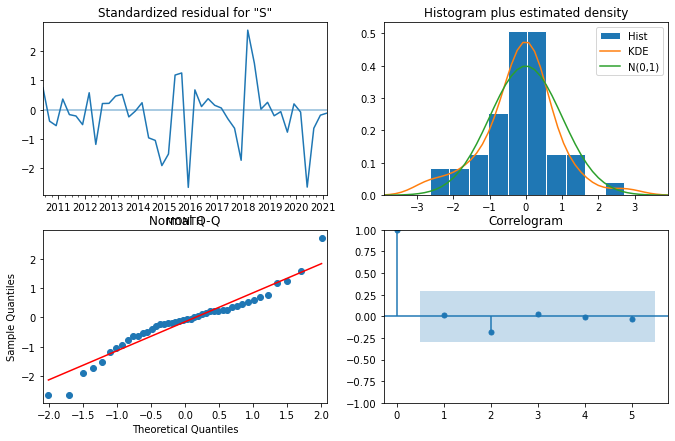

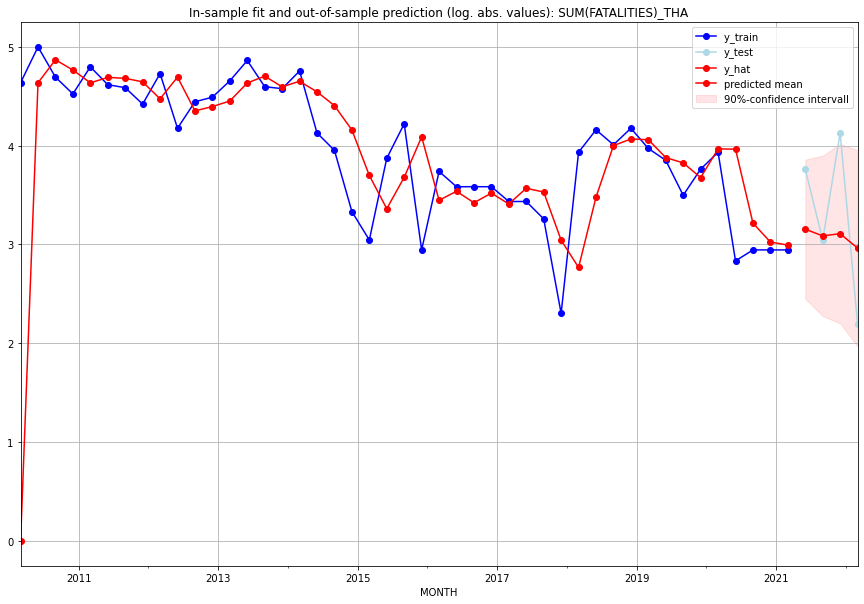

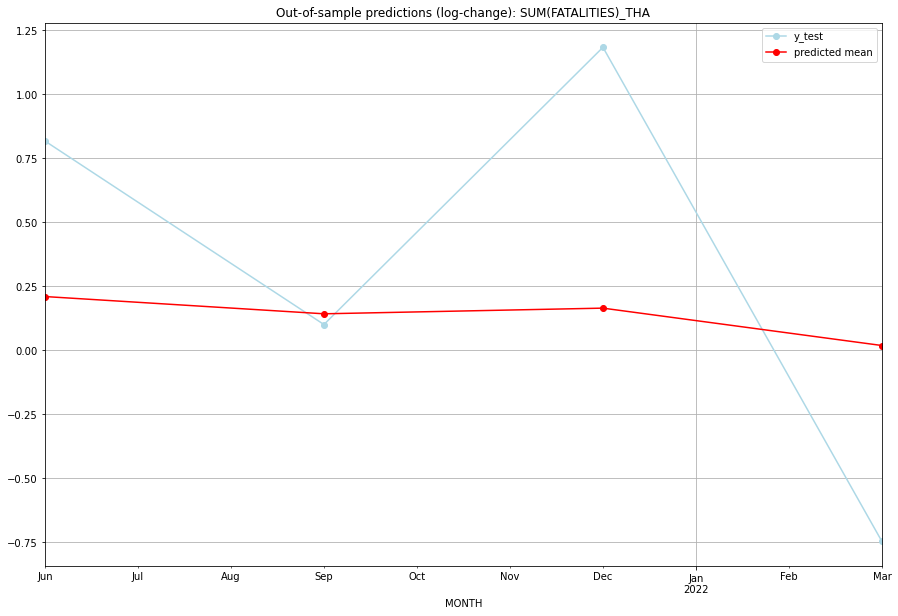

TADDA: 0.6128272214994837
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  22.425115        42.0      0.209370        0.816761   THA   
1 2021-07-01  20.898307        20.0      0.141970        0.100083   THA   
2 2021-10-01  21.388189        61.0      0.164095        1.182695   THA   
3 2022-01-01  18.347180         8.0      0.018108       -0.747214   THA   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 1), (2, 0, 2, 4), 'n'], ...  
1  {'params': [0, (0, 1, 1), (2, 0, 2, 4), 'n'], ...  
2  {'params': [0, (0, 1, 1), (2, 0, 2, 4), 'n'], ...  
3  {'params': [0, (0, 1, 1), (2, 0, 2, 4), 'n'], ...  
Execution time: 02:41
######## TJK (204/234) #########
0
Neighbor countries: []
Getting Data for TJK
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (3, 0, 0), (2, 1, 0, 4), 'n'], 'cv_score': 0.7134491103407701, 'fold_results': [nan, 0.7134491103407701]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_TJK   No. Observations:                   13
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 4)   Log Likelihood                 -12.881
Date:                           Wed, 19 Oct 2022   AIC                             37.763
Time:                                   20:01:46   BIC                             38.946
Sample:                               01-31-2018   HQIC                            35.209
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

<Figure size 432x288 with 0 Axes>

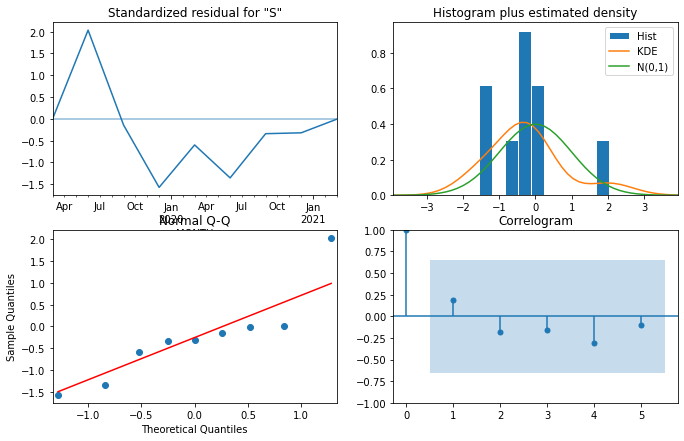

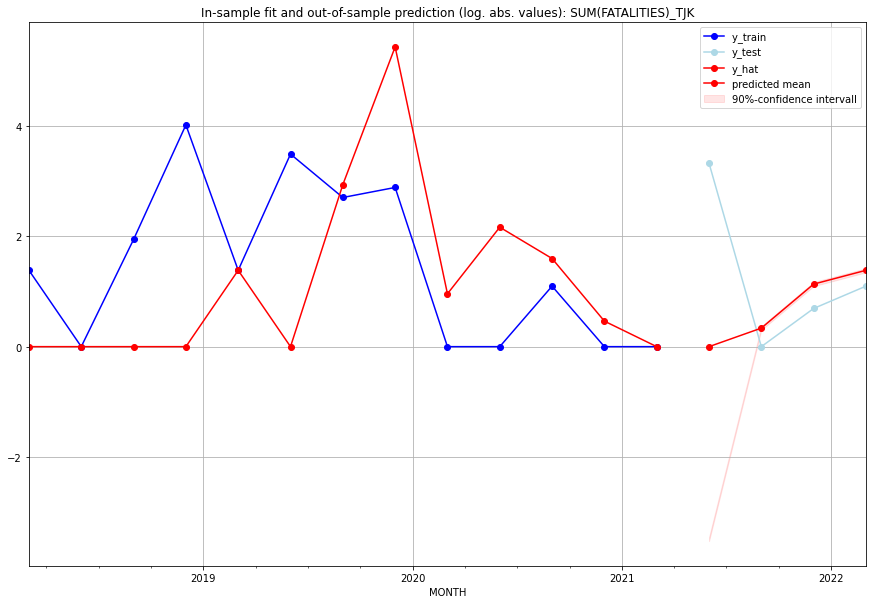

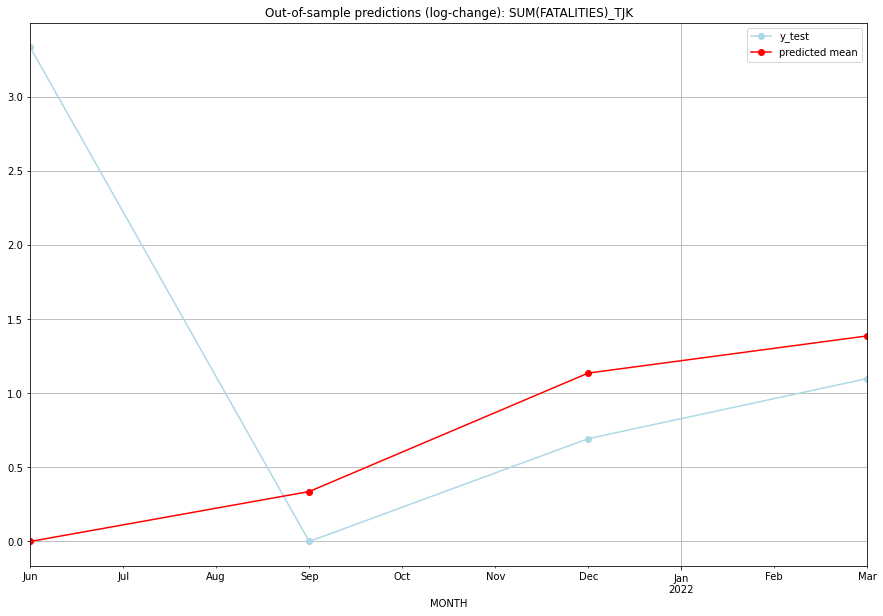

TADDA: 1.0997271369985813
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  0.000000        27.0      0.000000        3.332205   TJK   
1 2021-07-01  0.400438         0.0      0.336785        0.000000   TJK   
2 2021-10-01  2.112846         1.0      1.135537        0.693147   TJK   
3 2022-01-01  2.999388         2.0      1.386141        1.098612   TJK   

                                          PARAMETERS  
0  {'params': [0, (3, 0, 0), (2, 1, 0, 4), 'n'], ...  
1  {'params': [0, (3, 0, 0), (2, 1, 0, 4), 'n'], ...  
2  {'params': [0, (3, 0, 0), (2, 1, 0, 4), 'n'], ...  
3  {'params': [0, (3, 0, 0), (2, 1, 0, 4), 'n'], ...  
Execution time: 01:00
######## TKM (205/234) #########
0
Neighbor countries: []
Getting Data for TKM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU core

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 0), (0, 0, 2, 4), 'n'], 'cv_score': 0.43321295458369863, 'fold_results': [0.6931391140274109, 0.17328679513998632]}
Training finished.
                                       SARIMAX Results                                        
Dep. Variable:                    SUM(FATALITIES)_TKM   No. Observations:                   13
Model:             SARIMAX(0, 1, 0)x(0, 0, [1, 2], 4)   Log Likelihood                 -21.868
Date:                                Wed, 19 Oct 2022   AIC                             49.737
Time:                                        20:02:29   BIC                             51.192
Sample:                                    01-31-2018   HQIC                            49.198
                                         - 01-31-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.02

<Figure size 432x288 with 0 Axes>

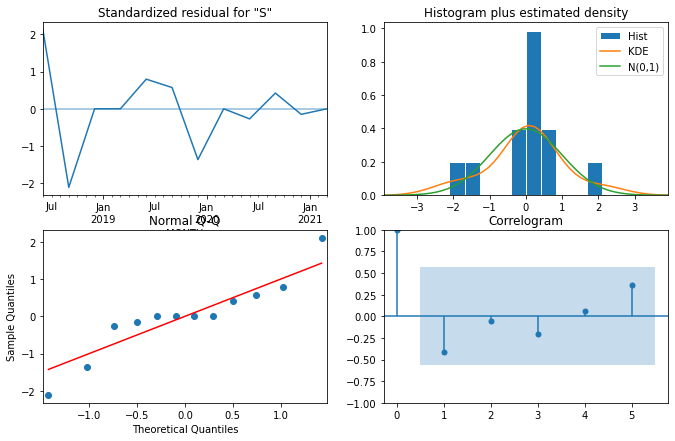

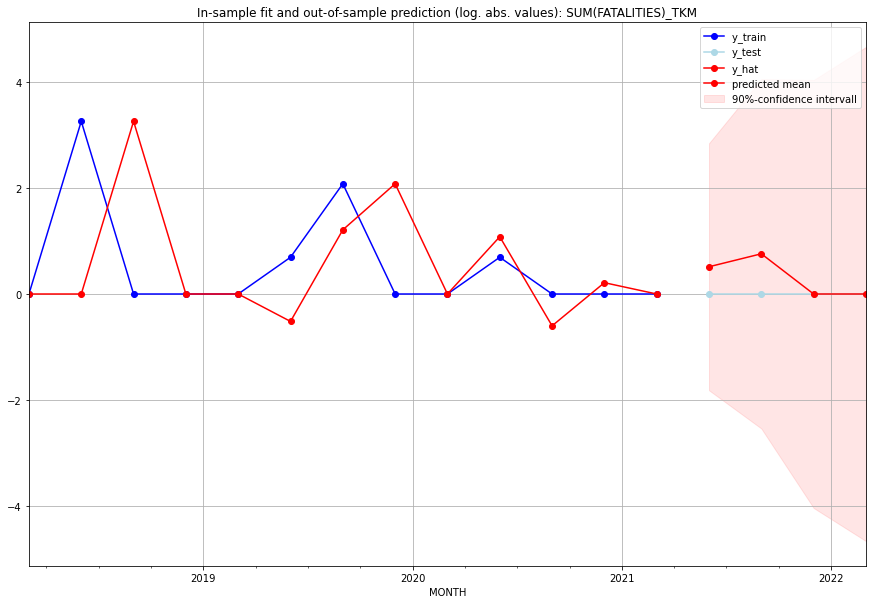

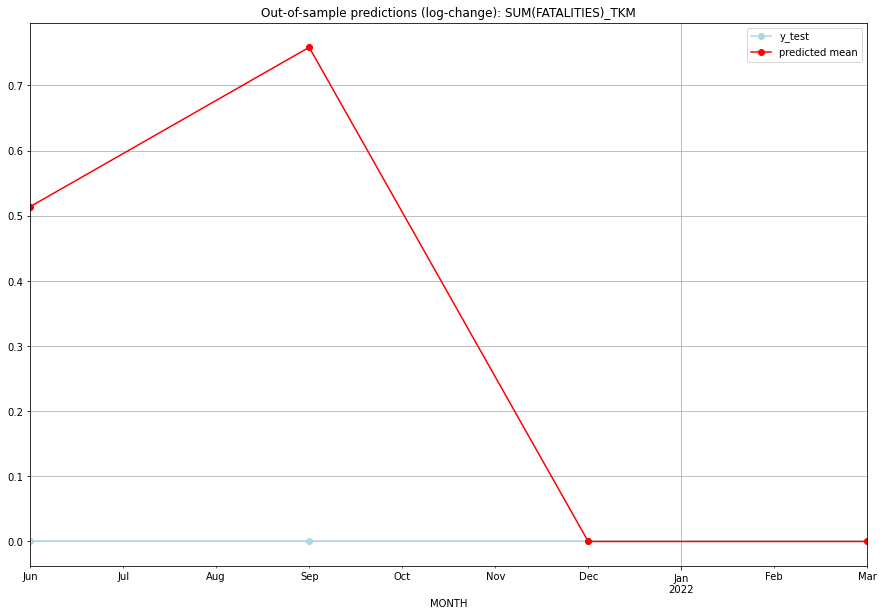

TADDA: 0.3181653812768026
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  0.672068         0.0      0.514061             0.0   TKM   
1 2021-07-01  1.135286         0.0      0.758601             0.0   TKM   
2 2021-10-01  0.000000         0.0      0.000000             0.0   TKM   
3 2022-01-01  0.000000         0.0      0.000000             0.0   TKM   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 0), (0, 0, 2, 4), 'n'], ...  
1  {'params': [0, (0, 1, 0), (0, 0, 2, 4), 'n'], ...  
2  {'params': [0, (0, 1, 0), (0, 0, 2, 4), 'n'], ...  
3  {'params': [0, (0, 1, 0), (0, 0, 2, 4), 'n'], ...  
Execution time: 00:40
######## TLS (206/234) #########
0
Neighbor countries: []
Getting Data for TLS
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
y_train is all zero. No GSCV nec

<Figure size 432x288 with 0 Axes>

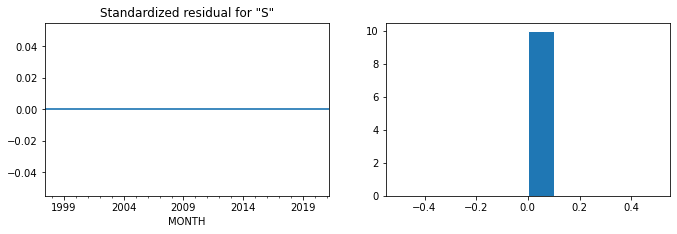

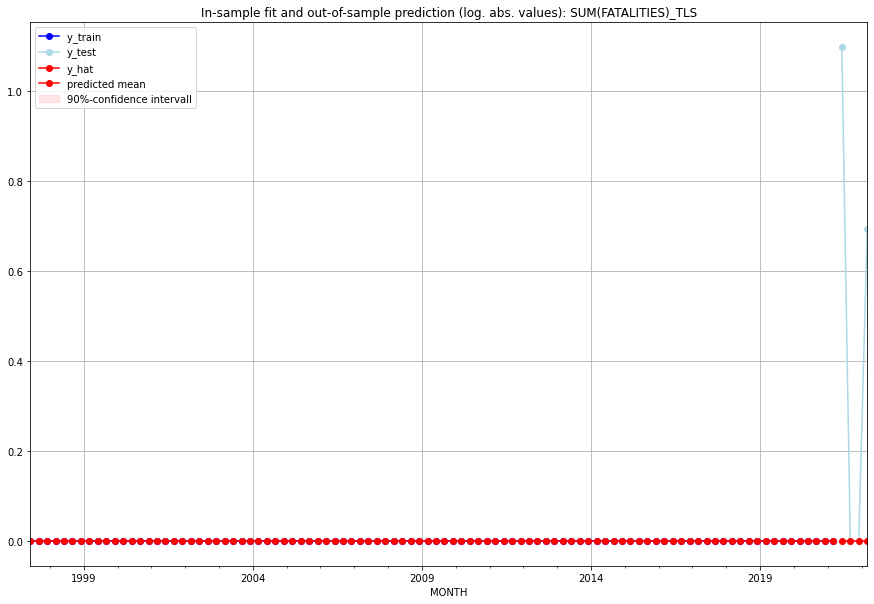

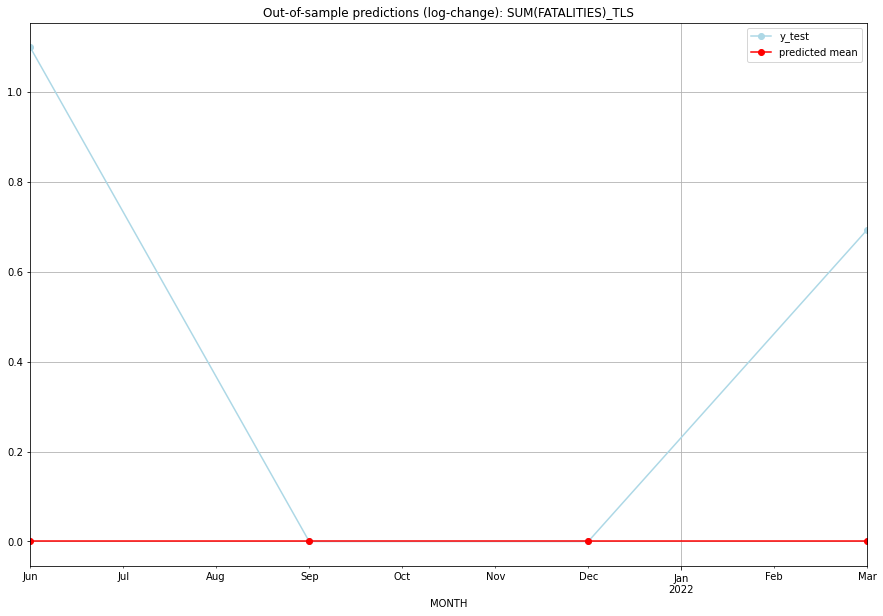

TADDA: 0.44793986730701374
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         2.0           0.0        1.098612   TLS   
1 2021-07-01       0.0         0.0           0.0        0.000000   TLS   
2 2021-10-01       0.0         0.0           0.0        0.000000   TLS   
3 2022-01-01       0.0         1.0           0.0        0.693147   TLS   

  PARAMETERS  
0         {}  
1         {}  
2         {}  
3         {}  
Execution time: 00:02
######## TON (207/234) #########
0
Neighbor countries: []
Getting Data for TON
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 0)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


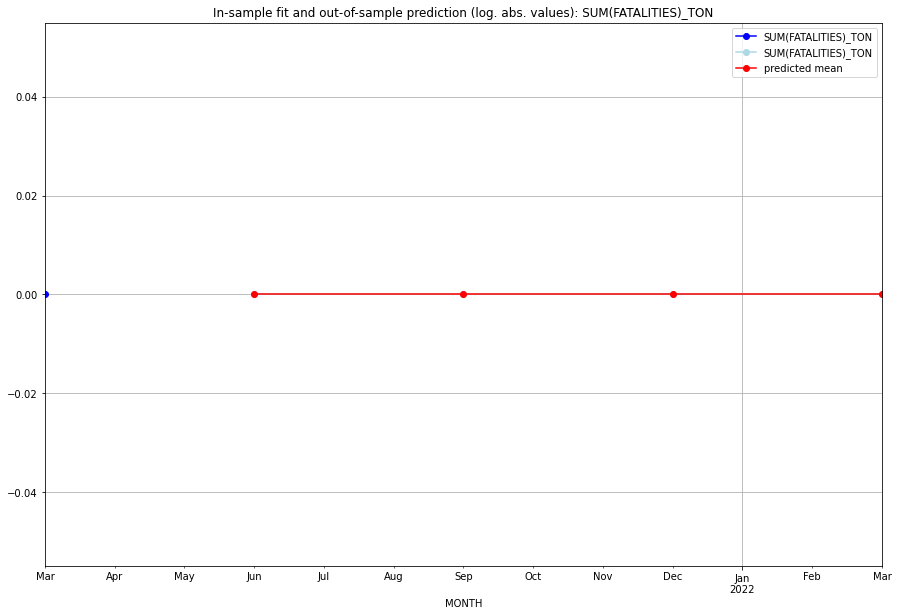

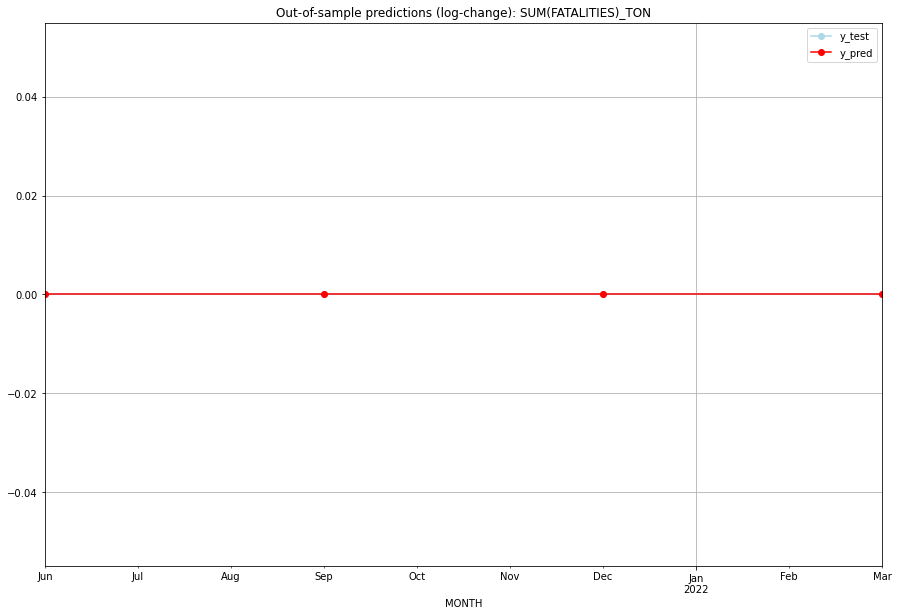

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   TON   
1 2021-07-01       0.0         0.0           0.0             0.0   TON   
2 2021-10-01       0.0         0.0           0.0             0.0   TON   
3 2022-01-01       0.0         0.0           0.0             0.0   TON   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## TTO (208/234) #########
0
Neighbor countries: []
Getting Data for TTO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (3, 0, 2), (1, 0, 2, 4), 'n'], 'cv_score': 0.2672243555738889, 'fold_results': [0.2672243555738889, nan]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_TTO   No. Observations:                   13
Model:             SARIMAX(3, 0, 2)x(1, 0, 2, 4)   Log Likelihood                  -7.644
Date:                           Wed, 19 Oct 2022   AIC                             33.288
Time:                                   20:03:17   BIC                             38.373
Sample:                               01-31-2018   HQIC                            32.243
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

<Figure size 432x288 with 0 Axes>

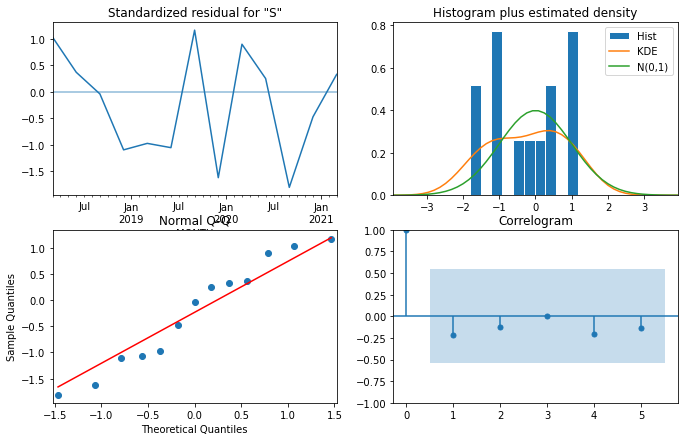

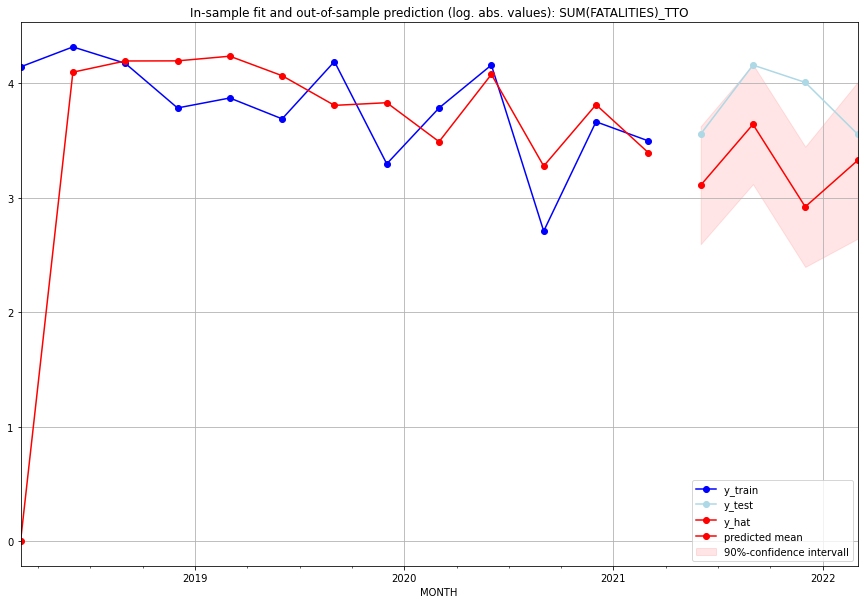

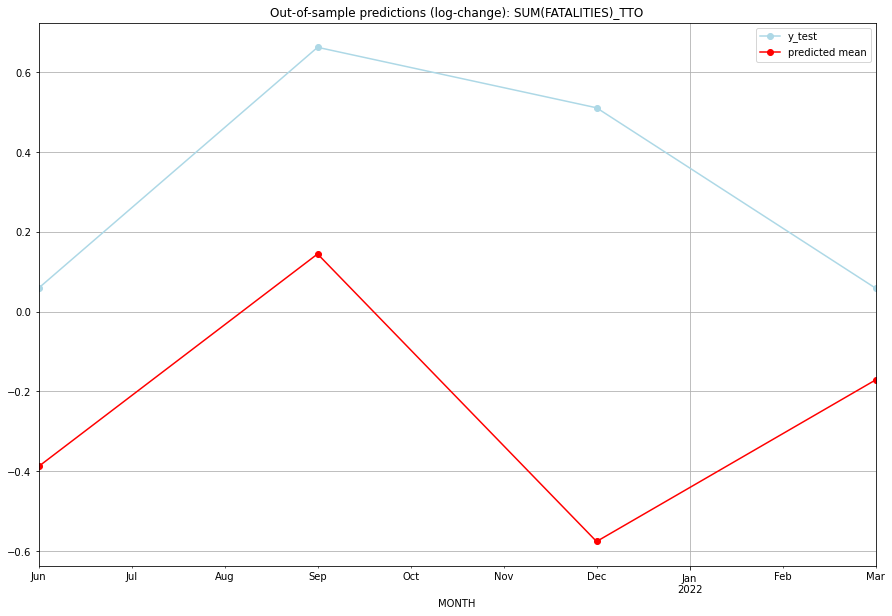

TADDA: 0.8541505063704891
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  21.387455        34.0     -0.388007        0.058841   TTO   
1 2021-07-01  37.130724        63.0      0.144513        0.662376   TTO   
2 2021-10-01  17.551487        54.0     -0.575958        0.510826   TTO   
3 2022-01-01  26.808887        34.0     -0.171152        0.058841   TTO   

                                          PARAMETERS  
0  {'params': [0, (3, 0, 2), (1, 0, 2, 4), 'n'], ...  
1  {'params': [0, (3, 0, 2), (1, 0, 2, 4), 'n'], ...  
2  {'params': [0, (3, 0, 2), (1, 0, 2, 4), 'n'], ...  
3  {'params': [0, (3, 0, 2), (1, 0, 2, 4), 'n'], ...  
Execution time: 00:44
######## TUN (209/234) #########
0
Neighbor countries: []
Getting Data for TUN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 C

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (3, 0, 0), (0, 1, 1, 4), 'n'], 'cv_score': 0.3700644365616238, 'fold_results': [0.5107915924461061, 0.21104879592665715, 0.5017288029288052, 0.38265308655465585, 0.24409990495189487]}
Training finished.
                                      SARIMAX Results                                      
Dep. Variable:                 SUM(FATALITIES)_TUN   No. Observations:                   96
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 4)   Log Likelihood                -124.520
Date:                             Wed, 19 Oct 2022   AIC                            259.039
Time:                                     20:05:24   BIC                            271.648
Sample:                                 04-30-1997   HQIC                           264.128
                                      - 01-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std

<Figure size 432x288 with 0 Axes>

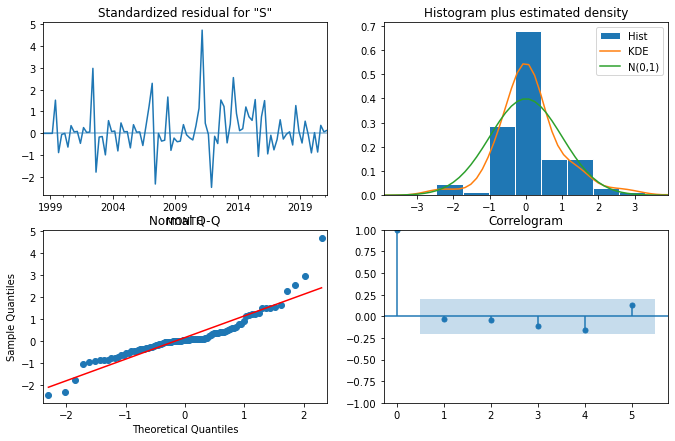

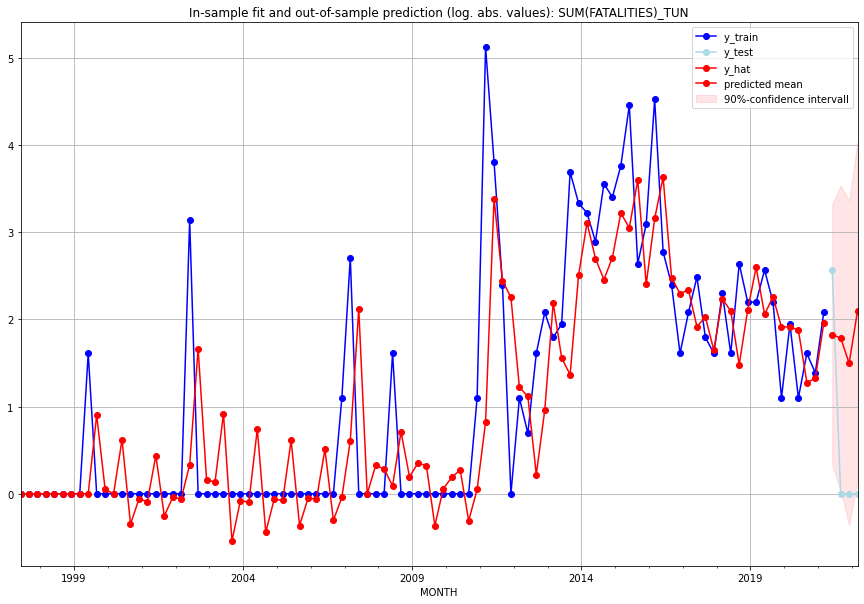

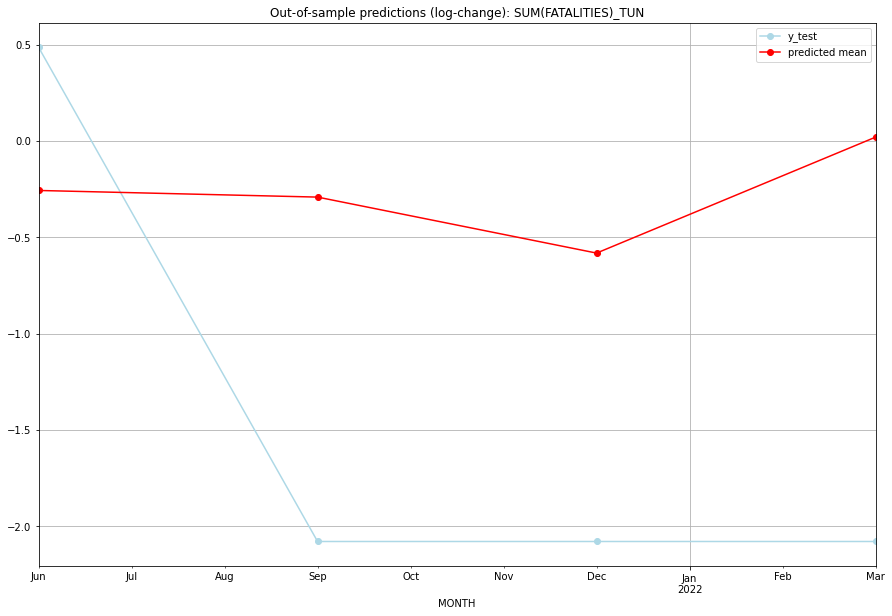

TADDA: 1.6007536849049222
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  5.183826        12.0     -0.257504        0.485508   TUN   
1 2021-07-01  4.974553         0.0     -0.291932       -2.079442   TUN   
2 2021-10-01  3.467846         0.0     -0.582535       -2.079442   TUN   
3 2022-01-01  7.156066         0.0      0.019320       -2.079442   TUN   

                                          PARAMETERS  
0  {'params': [0, (3, 0, 0), (0, 1, 1, 4), 'n'], ...  
1  {'params': [0, (3, 0, 0), (0, 1, 1, 4), 'n'], ...  
2  {'params': [0, (3, 0, 0), (0, 1, 1, 4), 'n'], ...  
3  {'params': [0, (3, 0, 0), (0, 1, 1, 4), 'n'], ...  
Execution time: 02:06
######## TUR (210/234) #########
0
Neighbor countries: []
Getting Data for TUR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (25, 0)
y: (25, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU core

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 1, 0), (0, 1, 0, 4), 'n'], 'cv_score': 0.25608210113670293, 'fold_results': [nan, 0.14384497020074938, 0.4427715296524286, 0.1816298035569308]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_TUR   No. Observations:                   21
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 4)   Log Likelihood                  -8.952
Date:                           Wed, 19 Oct 2022   AIC                             23.904
Time:                                   20:06:48   BIC                             26.222
Sample:                               01-31-2016   HQIC                            24.023
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

<Figure size 432x288 with 0 Axes>

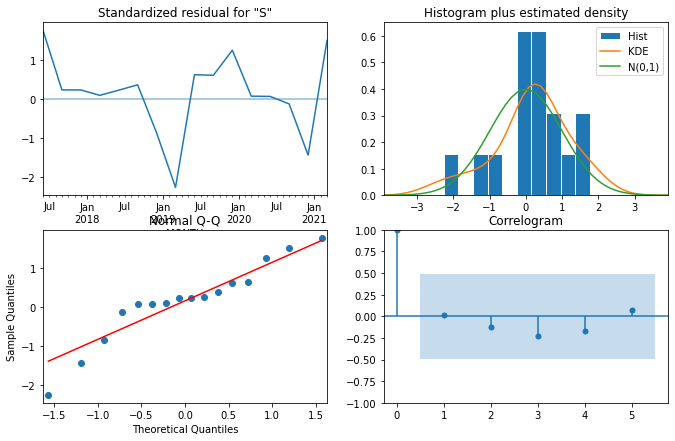

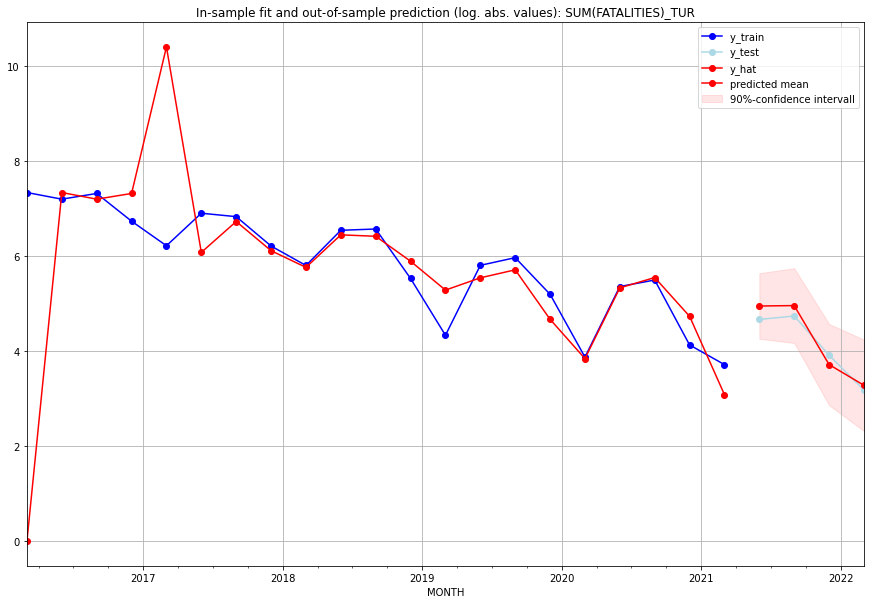

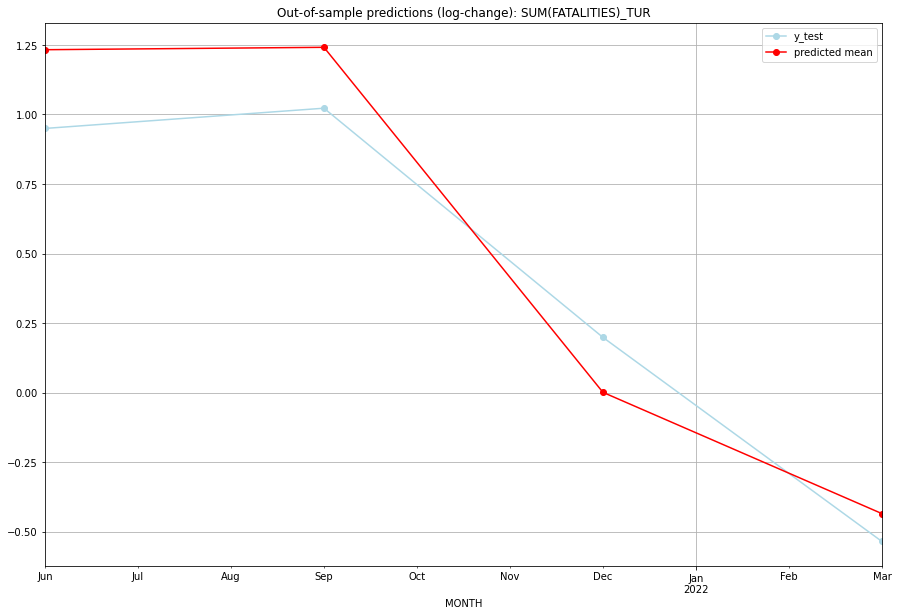

TADDA: 0.1999763527828642
Evaluation finished.
       MONTH    FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  139.685815       105.0      1.232957        0.949867   TUR   
1 2021-07-01  140.908946       113.0      1.241614        1.022626   TUR   
2 2021-10-01   40.034142        49.0      0.000832        0.198451   TUR   
3 2022-01-01   25.529663        23.0     -0.435309       -0.535518   TUR   

                                          PARAMETERS  
0  {'params': [0, (2, 1, 0), (0, 1, 0, 4), 'n'], ...  
1  {'params': [0, (2, 1, 0), (0, 1, 0, 4), 'n'], ...  
2  {'params': [0, (2, 1, 0), (0, 1, 0, 4), 'n'], ...  
3  {'params': [0, (2, 1, 0), (0, 1, 0, 4), 'n'], ...  
Execution time: 01:24
######## TWN (211/234) #########
0
Neighbor countries: []
Getting Data for TWN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
y_train is all zero. No 

<Figure size 432x288 with 0 Axes>

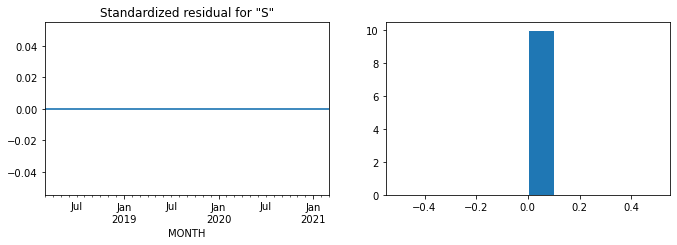

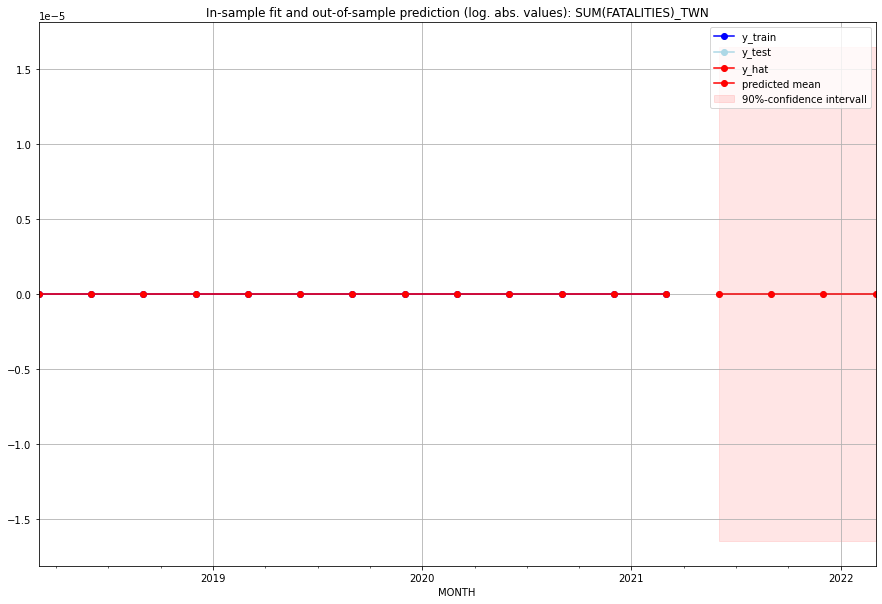

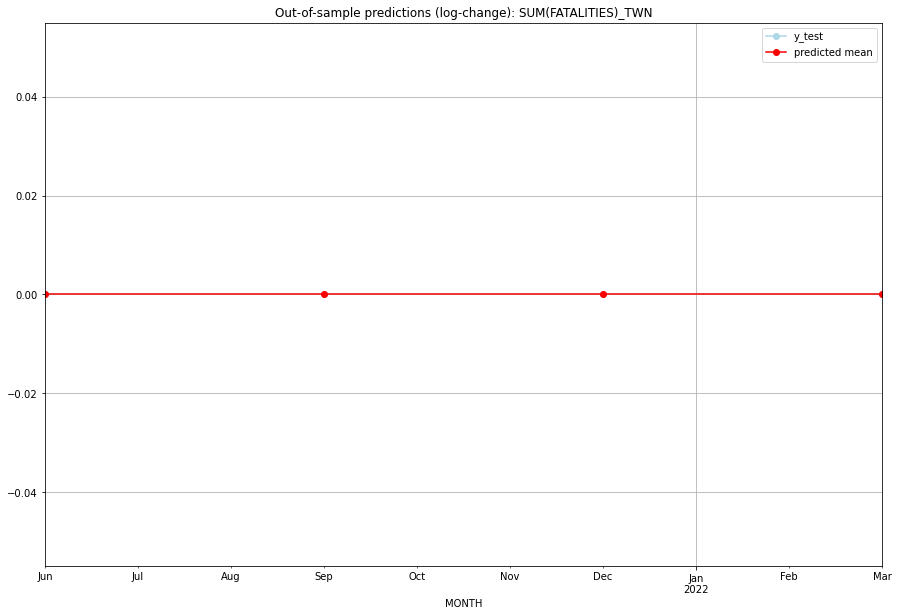

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   TWN   
1 2021-07-01       0.0         0.0           0.0             0.0   TWN   
2 2021-10-01       0.0         0.0           0.0             0.0   TWN   
3 2022-01-01       0.0         0.0           0.0             0.0   TWN   

  PARAMETERS  
0         {}  
1         {}  
2         {}  
3         {}  
Execution time: 00:02
######## TZA (212/234) #########
0
Neighbor countries: []
Getting Data for TZA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 3), (2, 0, 2, 4), 'n'], 'cv_score': 0.9513413099393911, 'fold_results': [0.9652273949225754, 1.0514815584717814, 0.8041260314301107, 0.40306255235528266, 1.5328090125172054]}
Training finished.
                                       SARIMAX Results                                        
Dep. Variable:                    SUM(FATALITIES)_TZA   No. Observations:                   96
Model:             SARIMAX(0, 1, 3)x(2, 0, [1, 2], 4)   Log Likelihood                -149.532
Date:                                Wed, 19 Oct 2022   AIC                            315.063
Time:                                        20:09:53   BIC                            335.494
Sample:                                    04-30-1997   HQIC                           323.319
                                         - 01-31-2021                                         
Covariance Type:                                  opg                                         
      

<Figure size 432x288 with 0 Axes>

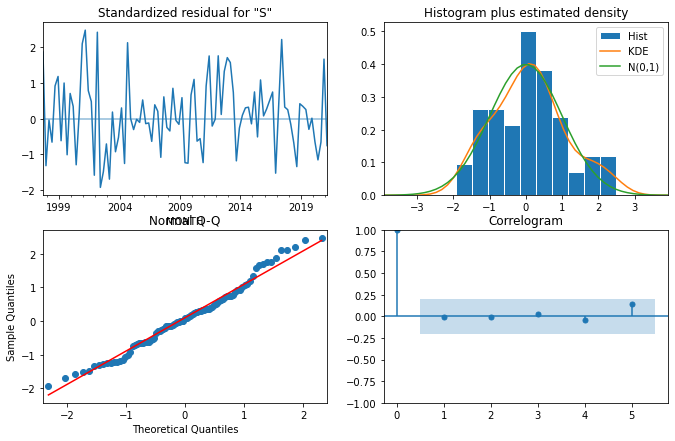

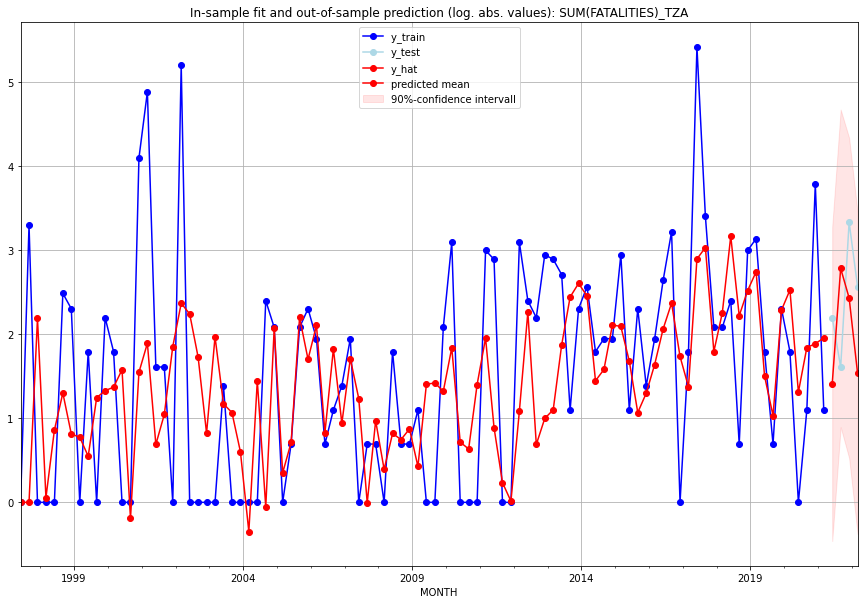

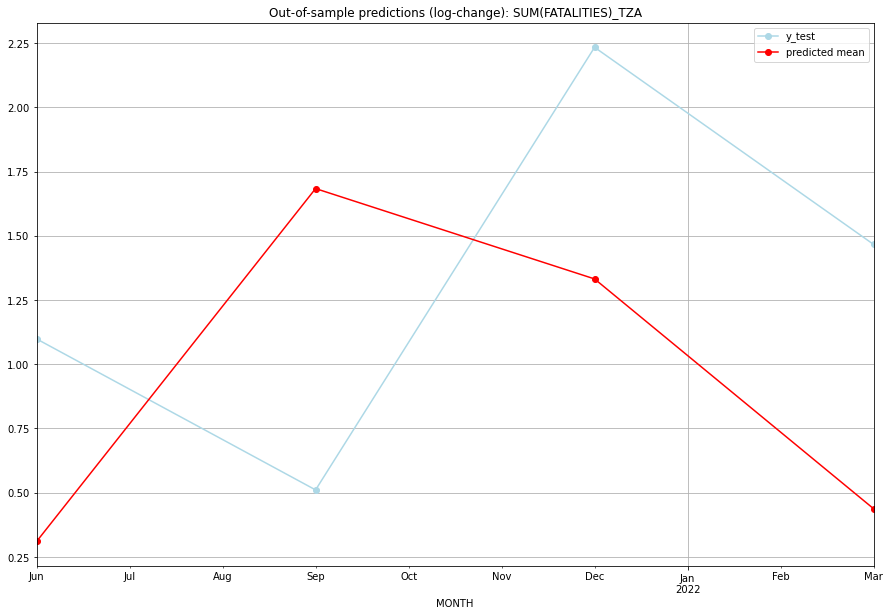

TADDA: 0.9729341441509849
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01   3.090383         8.0      0.310026        1.098612   TZA   
1 2021-07-01  15.157016         4.0      1.683742        0.510826   TZA   
2 2021-10-01  10.365986        27.0      1.332013        2.233592   TZA   
3 2022-01-01   3.647337        12.0      0.437682        1.466337   TZA   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 3), (2, 0, 2, 4), 'n'], ...  
1  {'params': [0, (0, 1, 3), (2, 0, 2, 4), 'n'], ...  
2  {'params': [0, (0, 1, 3), (2, 0, 2, 4), 'n'], ...  
3  {'params': [0, (0, 1, 3), (2, 0, 2, 4), 'n'], ...  
Execution time: 03:01
######## UGA (213/234) #########
0
Neighbor countries: []
Getting Data for UGA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 C

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (3, 0, 2), (2, 0, 1, 4), 'n'], 'cv_score': 0.7808226950713245, 'fold_results': [nan, 1.4475425727500268, 0.7878452363591214, 0.14445557992069347, 0.7434473912554561]}
Training finished.
                                      SARIMAX Results                                      
Dep. Variable:                 SUM(FATALITIES)_UGA   No. Observations:                   96
Model:             SARIMAX(3, 0, 2)x(2, 0, [1], 4)   Log Likelihood                -136.927
Date:                             Wed, 19 Oct 2022   AIC                            291.853
Time:                                     20:12:44   BIC                            314.932
Sample:                                 04-30-1997   HQIC                           301.182
                                      - 01-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z  

<Figure size 432x288 with 0 Axes>

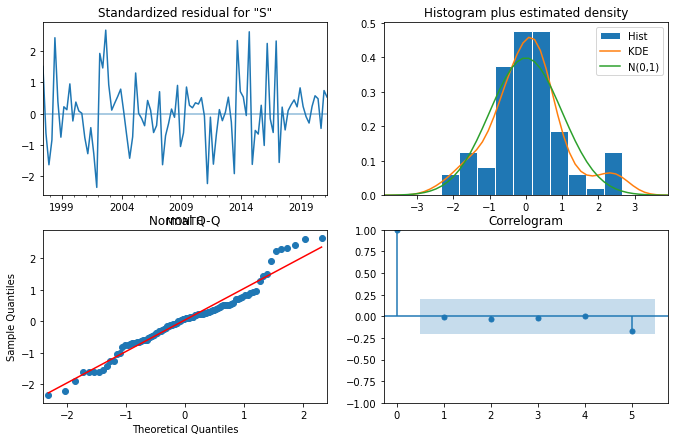

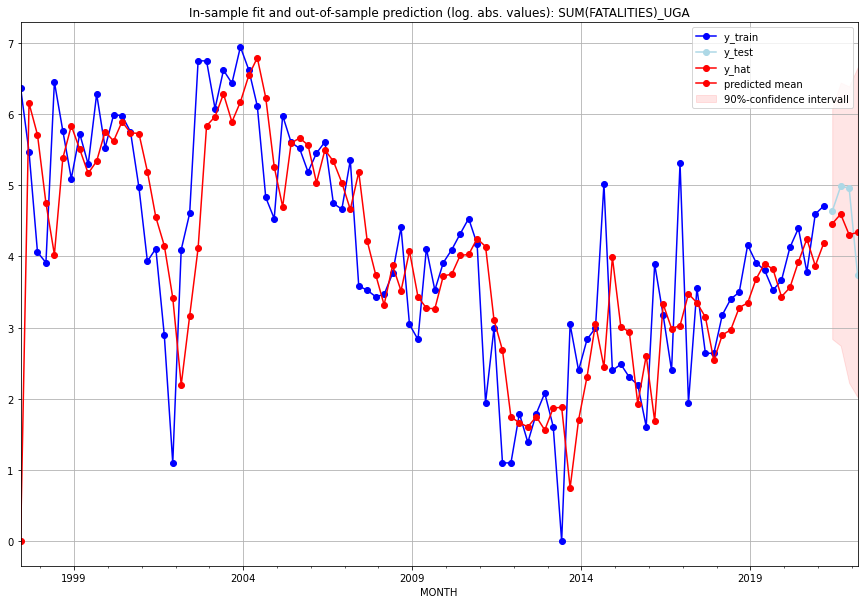

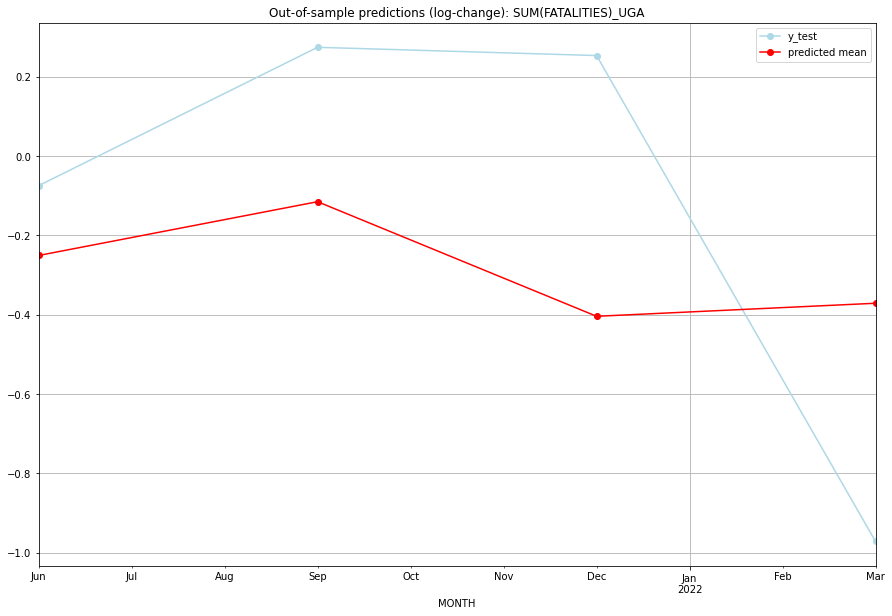

TADDA: 0.5856344244249883
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  85.379021       102.0     -0.250785       -0.074801   UGA   
1 2021-07-01  97.924263       145.0     -0.115176        0.274076   UGA   
2 2021-10-01  73.102603       142.0     -0.404080        0.253314   UGA   
3 2022-01-01  75.578926        41.0     -0.371208       -0.971861   UGA   

                                          PARAMETERS  
0  {'params': [0, (3, 0, 2), (2, 0, 1, 4), 'n'], ...  
1  {'params': [0, (3, 0, 2), (2, 0, 1, 4), 'n'], ...  
2  {'params': [0, (3, 0, 2), (2, 0, 1, 4), 'n'], ...  
3  {'params': [0, (3, 0, 2), (2, 0, 1, 4), 'n'], ...  
Execution time: 02:51
######## UKR (214/234) #########
0
Neighbor countries: []
Getting Data for UKR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 2), (0, 0, 2, 4), 'n'], 'cv_score': 0.23092635622475322, 'fold_results': [0.23092635622475322, nan]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_UKR   No. Observations:                   13
Model:             SARIMAX(0, 0, 2)x(0, 0, 2, 4)   Log Likelihood                 -20.514
Date:                           Wed, 19 Oct 2022   AIC                             51.029
Time:                                   20:13:13   BIC                             53.854
Sample:                               01-31-2018   HQIC                            50.448
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

<Figure size 432x288 with 0 Axes>

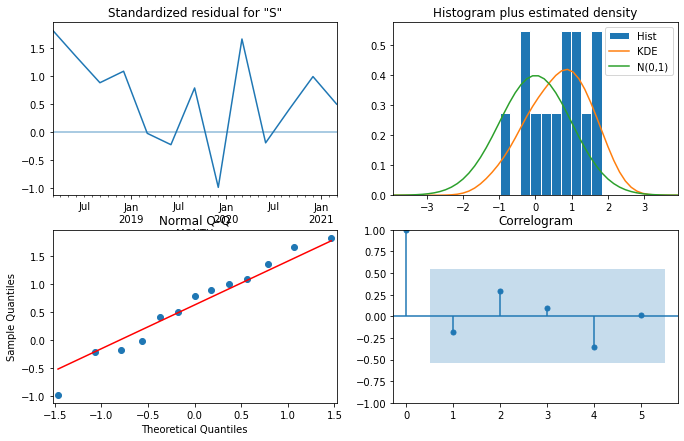

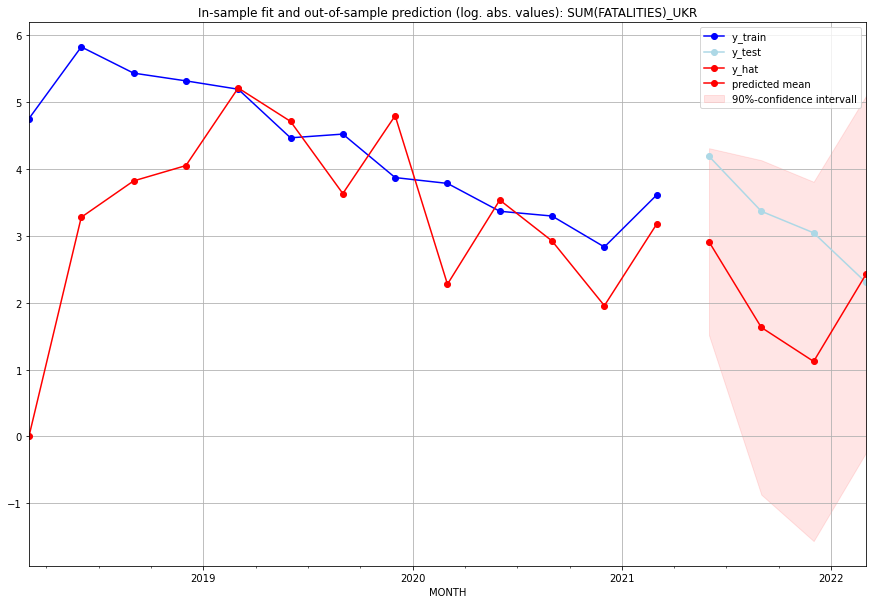

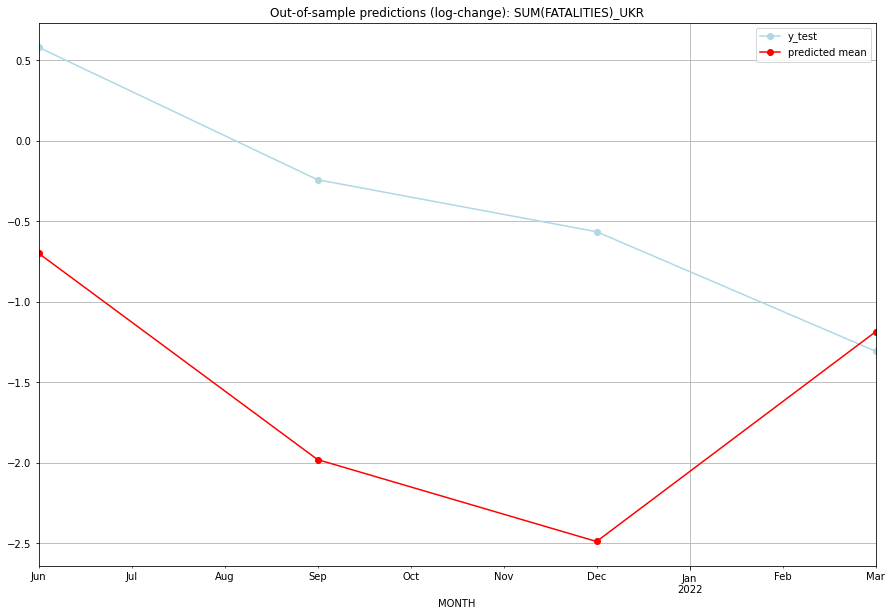

TADDA: 1.4402741619822286
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  17.370911        65.0     -0.700149        0.578737   UKR   
1 2021-07-01   4.100765        28.0     -1.981527       -0.243622   UKR   
2 2021-10-01   2.067233        20.0     -2.490142       -0.566395   UKR   
3 2022-01-01  10.279580         9.0     -1.187924       -1.308333   UKR   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 2), (0, 0, 2, 4), 'n'], ...  
1  {'params': [0, (0, 0, 2), (0, 0, 2, 4), 'n'], ...  
2  {'params': [0, (0, 0, 2), (0, 0, 2, 4), 'n'], ...  
3  {'params': [0, (0, 0, 2), (0, 0, 2, 4), 'n'], ...  
Execution time: 00:29
######## URY (215/234) #########
0
Neighbor countries: []
Getting Data for URY
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 0, 0), (1, 1, 0, 4), 'n'], 'cv_score': 0.029710434595775853, 'fold_results': [nan, 0.029710434595775853]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_URY   No. Observations:                   13
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 4)   Log Likelihood                  -2.293
Date:                           Wed, 19 Oct 2022   AIC                             12.586
Time:                                   20:13:44   BIC                             13.375
Sample:                               01-31-2018   HQIC                            10.884
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

<Figure size 432x288 with 0 Axes>

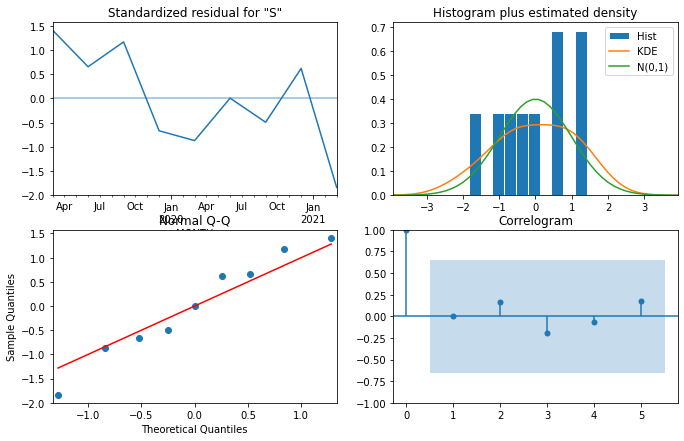

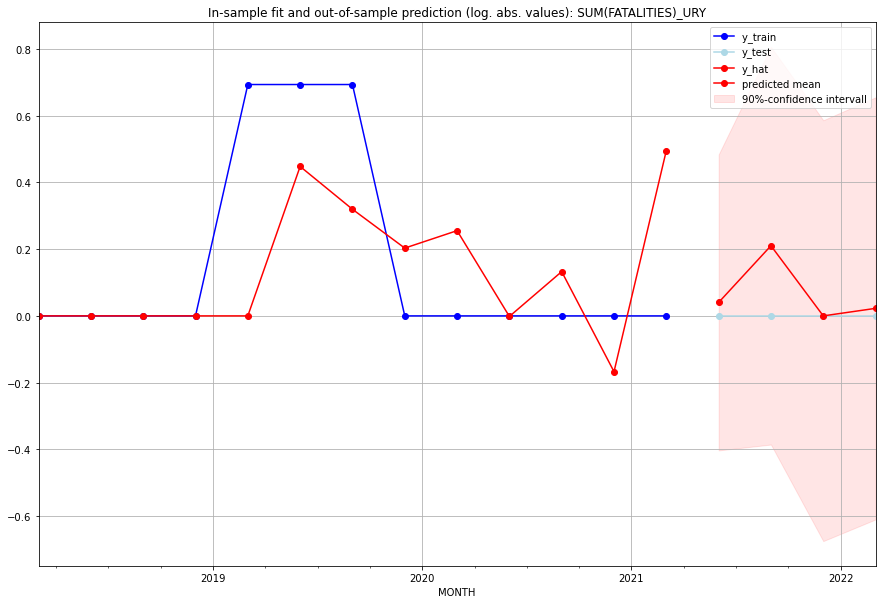

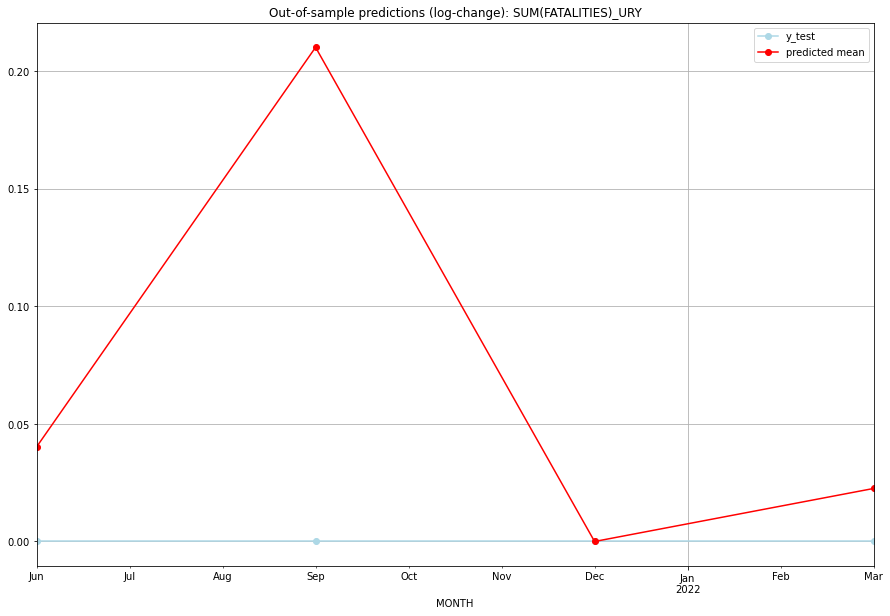

TADDA: 0.0682425651647414
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  0.041046         0.0      0.040226             0.0   URY   
1 2021-07-01  0.233915         0.0      0.210192             0.0   URY   
2 2021-10-01  0.000000         0.0      0.000000             0.0   URY   
3 2022-01-01  0.022808         0.0      0.022552             0.0   URY   

                                          PARAMETERS  
0  {'params': [0, (2, 0, 0), (1, 1, 0, 4), 'n'], ...  
1  {'params': [0, (2, 0, 0), (1, 1, 0, 4), 'n'], ...  
2  {'params': [0, (2, 0, 0), (1, 1, 0, 4), 'n'], ...  
3  {'params': [0, (2, 0, 0), (1, 1, 0, 4), 'n'], ...  
Execution time: 00:31
######## USA (216/234) #########
0
Neighbor countries: []
Getting Data for USA
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 0)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient da

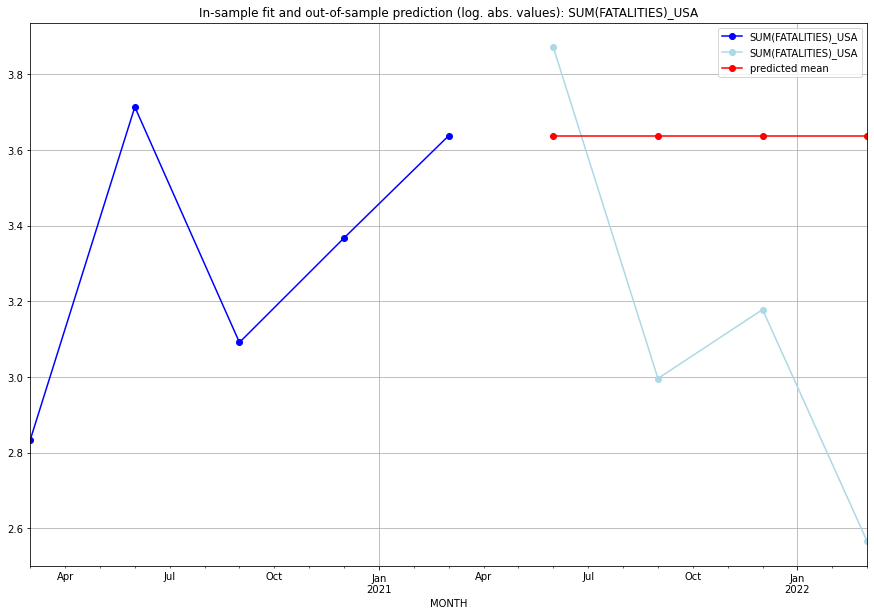

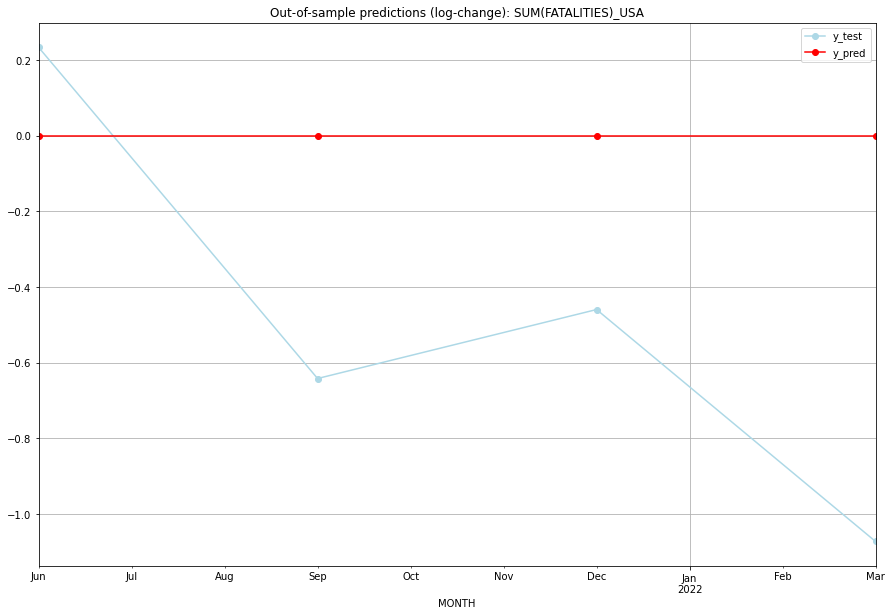

TADDA: 0.6019094672492973
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  3.637586    3.871201           0.0        0.233615   USA   
1 2021-07-01  3.637586    2.995732           0.0       -0.641854   USA   
2 2021-10-01  3.637586    3.178054           0.0       -0.459532   USA   
3 2022-01-01  3.637586    2.564949           0.0       -1.072637   USA   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## UZB (217/234) #########
0
Neighbor countries: []
Getting Data for UZB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 0, 0), (0, 1, 0, 4), 'n'], 'cv_score': 0.12992988559151097, 'fold_results': [nan, 0.12992988559151097]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_UZB   No. Observations:                   13
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 4)   Log Likelihood                  -6.024
Date:                           Wed, 19 Oct 2022   AIC                             18.047
Time:                                   20:14:27   BIC                             18.639
Sample:                               01-31-2018   HQIC                            16.770
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

<Figure size 432x288 with 0 Axes>

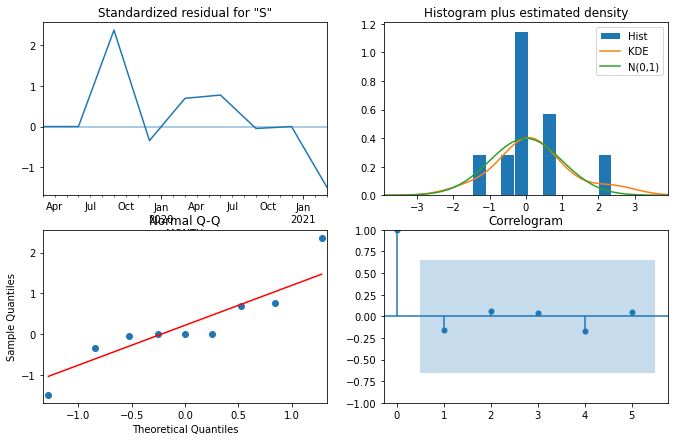

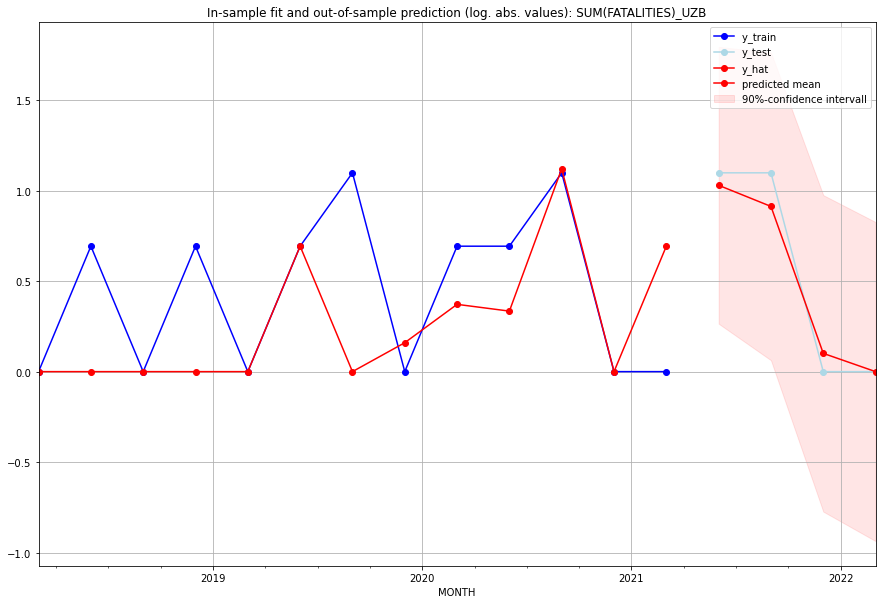

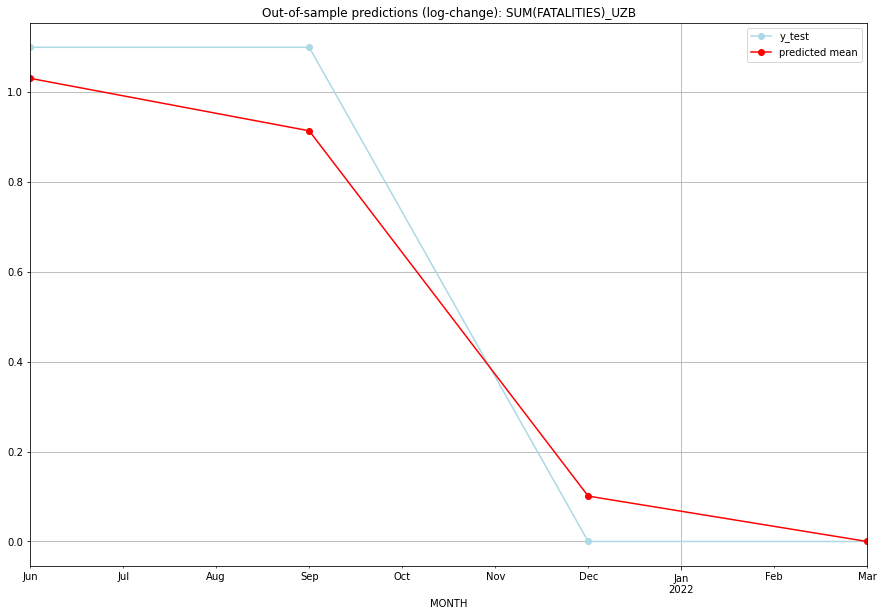

TADDA: 0.08887509444296127
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  1.800064         2.0      1.029642        1.098612   UZB   
1 2021-07-01  1.491779         2.0      0.912997        1.098612   UZB   
2 2021-10-01  0.106183         0.0      0.100915        0.000000   UZB   
3 2022-01-01  0.000000         0.0      0.000000        0.000000   UZB   

                                          PARAMETERS  
0  {'params': [0, (2, 0, 0), (0, 1, 0, 4), 'n'], ...  
1  {'params': [0, (2, 0, 0), (0, 1, 0, 4), 'n'], ...  
2  {'params': [0, (2, 0, 0), (0, 1, 0, 4), 'n'], ...  
3  {'params': [0, (2, 0, 0), (0, 1, 0, 4), 'n'], ...  
Execution time: 00:40
######## VAT (218/234) #########
0
Neighbor countries: []
Getting Data for VAT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 0)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient d

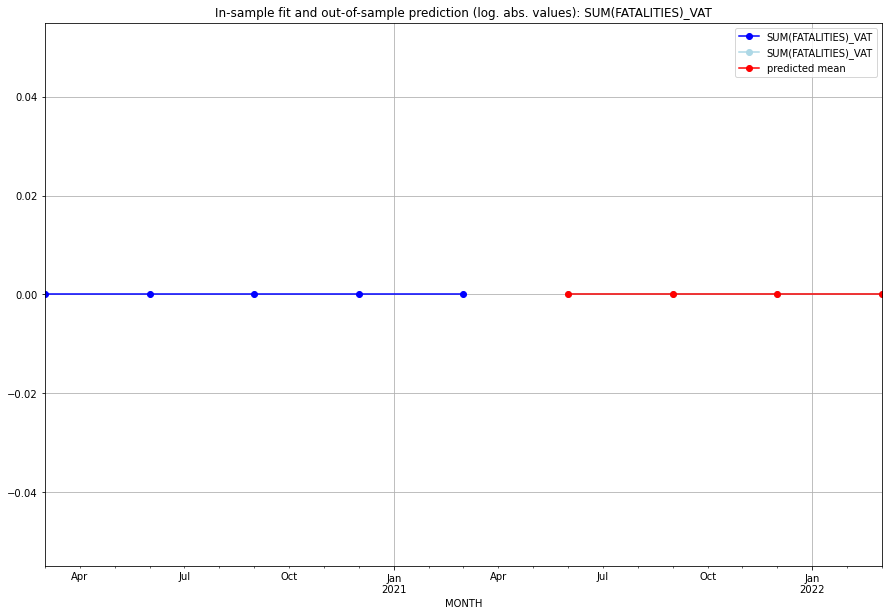

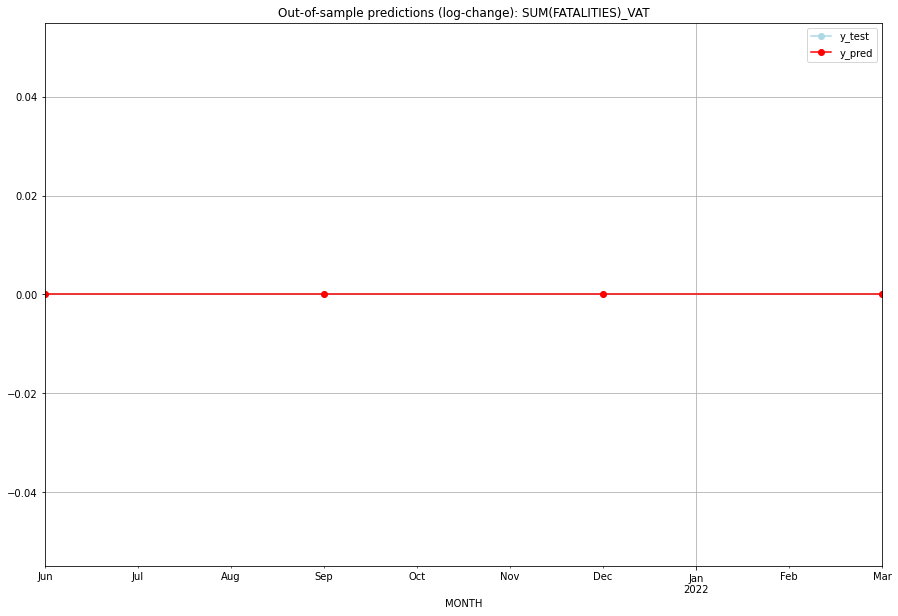

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VAT   
1 2021-07-01       0.0         0.0           0.0             0.0   VAT   
2 2021-10-01       0.0         0.0           0.0             0.0   VAT   
3 2022-01-01       0.0         0.0           0.0             0.0   VAT   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## VCT (219/234) #########
0
Neighbor countries: []
Getting Data for VCT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 0)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


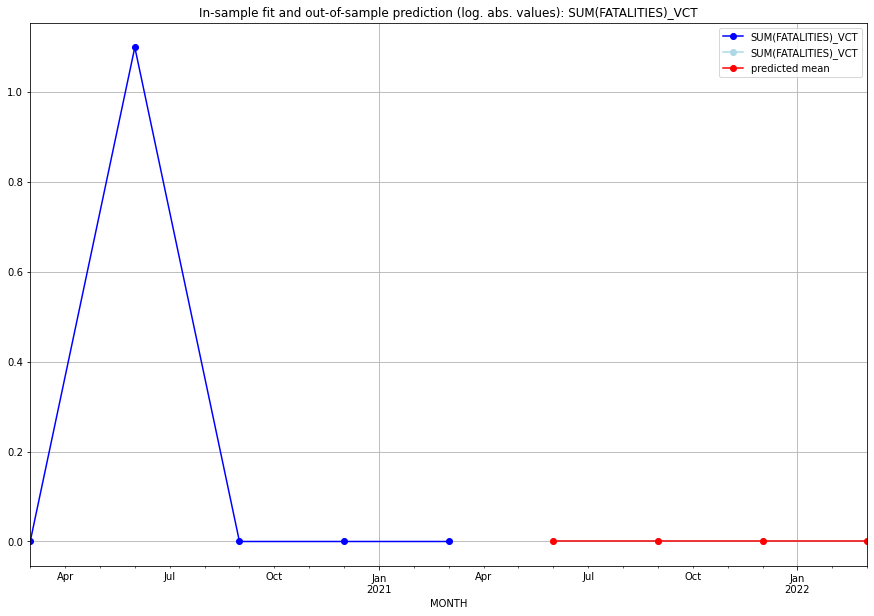

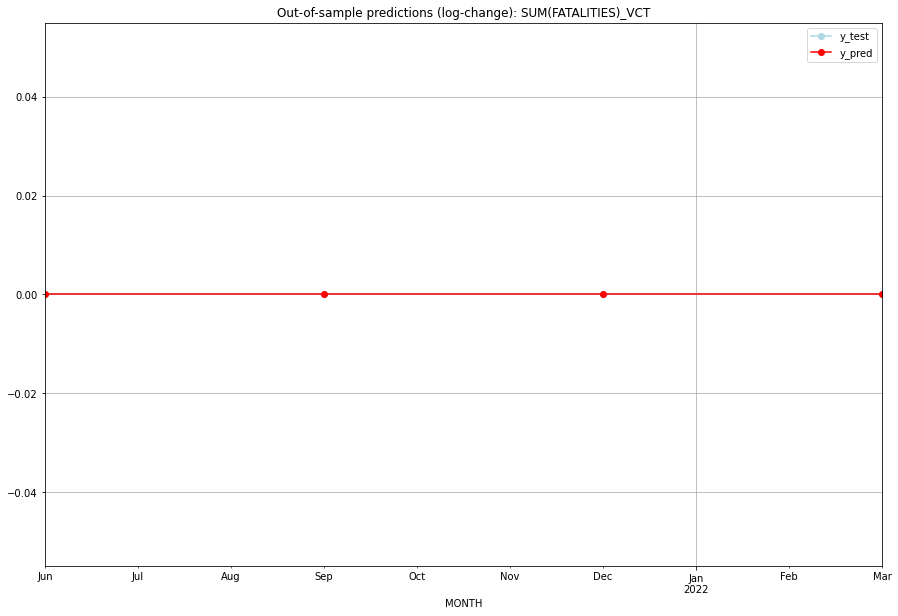

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VCT   
1 2021-07-01       0.0         0.0           0.0             0.0   VCT   
2 2021-10-01       0.0         0.0           0.0             0.0   VCT   
3 2022-01-01       0.0         0.0           0.0             0.0   VCT   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## VEN (220/234) #########
0
Neighbor countries: []
Getting Data for VEN
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 0, 2), (2, 0, 2, 4), 'n'], 'cv_score': 0.16906739557136108, 'fold_results': [0.16906739557136108, nan]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_VEN   No. Observations:                   13
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 4)   Log Likelihood                 -10.693
Date:                           Wed, 19 Oct 2022   AIC                             39.385
Time:                                   20:15:04   BIC                             44.470
Sample:                               01-31-2018   HQIC                            38.340
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

<Figure size 432x288 with 0 Axes>

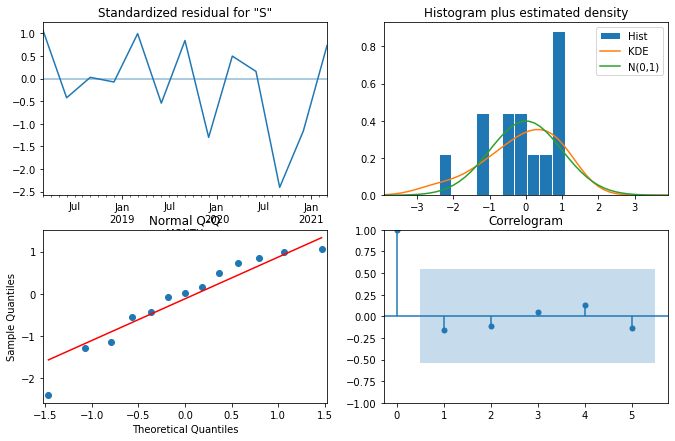

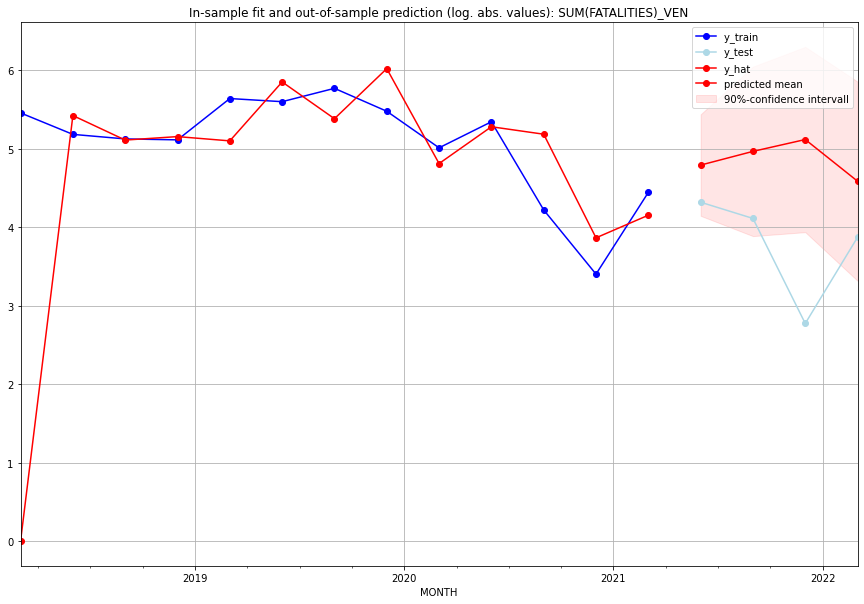

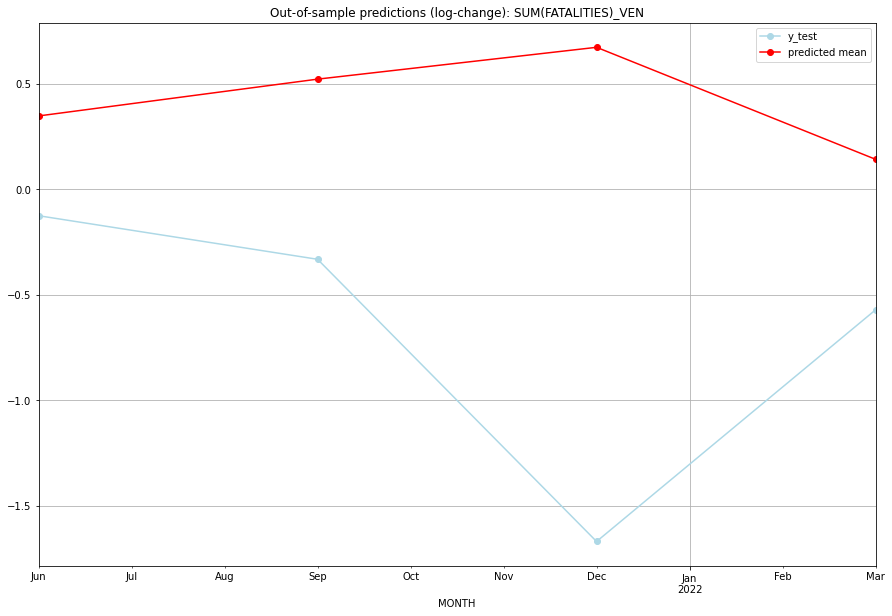

TADDA: 1.5177389430585877
Evaluation finished.
       MONTH    FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  119.375440        74.0      0.347964       -0.125163   VEN   
1 2021-07-01  142.329645        60.0      0.522496       -0.331777   VEN   
2 2021-10-01  165.686174        15.0      0.673462       -1.670063   VEN   
3 2022-01-01   97.001295        47.0      0.142329       -0.571450   VEN   

                                          PARAMETERS  
0  {'params': [0, (2, 0, 2), (2, 0, 2, 4), 'n'], ...  
1  {'params': [0, (2, 0, 2), (2, 0, 2, 4), 'n'], ...  
2  {'params': [0, (2, 0, 2), (2, 0, 2, 4), 'n'], ...  
3  {'params': [0, (2, 0, 2), (2, 0, 2, 4), 'n'], ...  
Execution time: 00:33
######## VIR (221/234) #########
0
Neighbor countries: []
Getting Data for VIR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (9, 0)
y: (9, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insuf

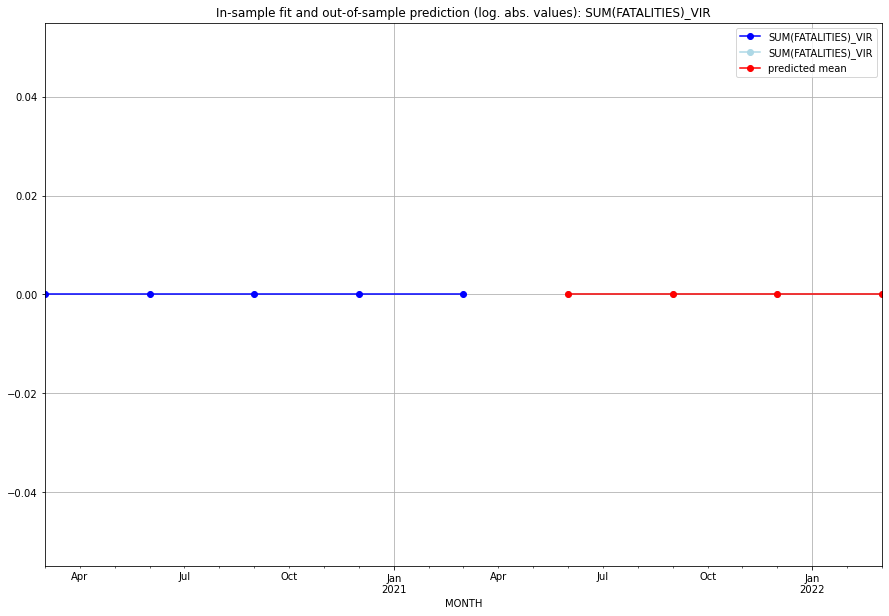

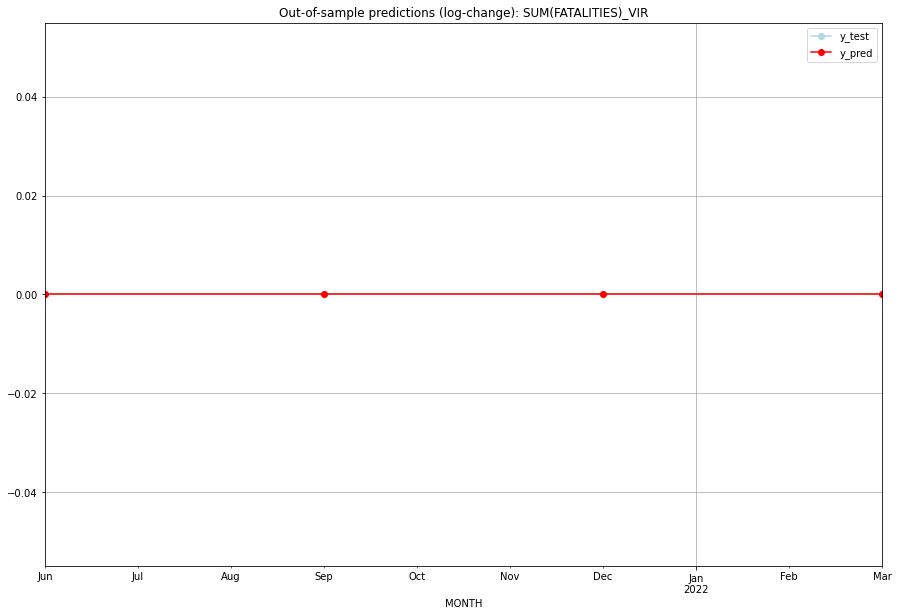

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VIR   
1 2021-07-01       0.0         0.0           0.0             0.0   VIR   
2 2021-10-01       0.0         0.0           0.0             0.0   VIR   
3 2022-01-01       0.0         0.0           0.0             0.0   VIR   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## VNM (222/234) #########
0
Neighbor countries: []
Getting Data for VNM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (49, 0)
y: (49, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (2, 0, 0), (0, 0, 2, 4), 'n'], 'cv_score': 0.42988838882217373, 'fold_results': [0.5947322001264856, 0.6249842582117101, 0.1944674727147899, 0.3327397191136947, 0.40251829394418787]}
Training finished.
                                       SARIMAX Results                                        
Dep. Variable:                    SUM(FATALITIES)_VNM   No. Observations:                   45
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 4)   Log Likelihood                 -61.783
Date:                                Wed, 19 Oct 2022   AIC                            133.566
Time:                                        20:16:08   BIC                            142.600
Sample:                                    01-31-2010   HQIC                           136.934
                                         - 01-31-2021                                         
Covariance Type:                                  opg                                         
     

<Figure size 432x288 with 0 Axes>

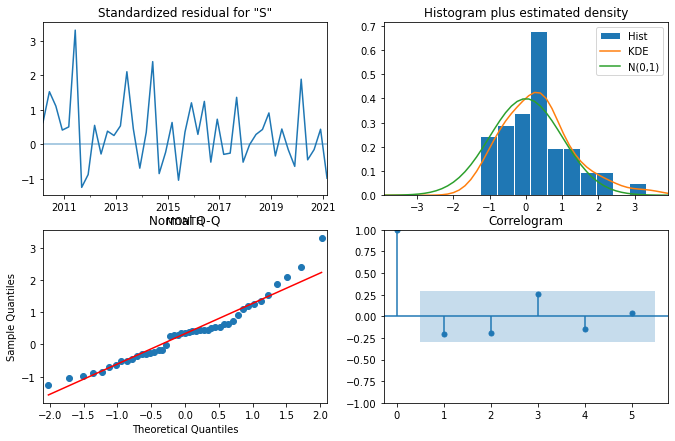

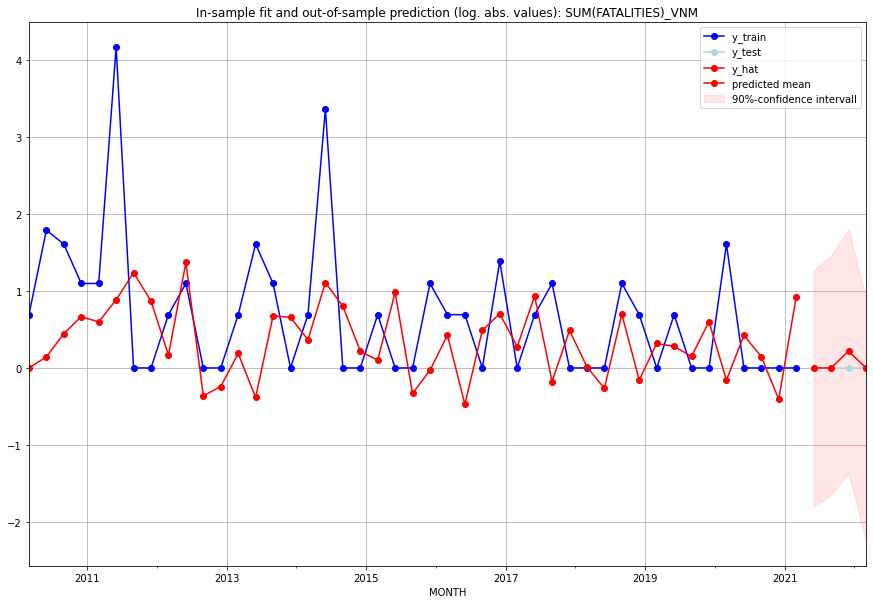

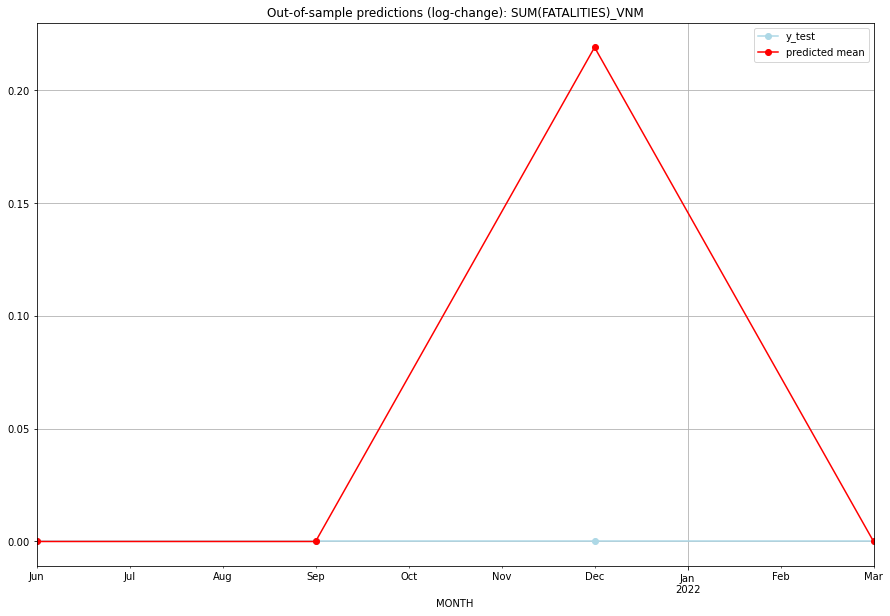

TADDA: 0.05474552202591581
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  0.000000         0.0      0.000000             0.0   VNM   
1 2021-07-01  0.000000         0.0      0.000000             0.0   VNM   
2 2021-10-01  0.244809         0.0      0.218982             0.0   VNM   
3 2022-01-01  0.000000         0.0      0.000000             0.0   VNM   

                                          PARAMETERS  
0  {'params': [0, (2, 0, 0), (0, 0, 2, 4), 'n'], ...  
1  {'params': [0, (2, 0, 0), (0, 0, 2, 4), 'n'], ...  
2  {'params': [0, (2, 0, 0), (0, 0, 2, 4), 'n'], ...  
3  {'params': [0, (2, 0, 0), (0, 0, 2, 4), 'n'], ...  
Execution time: 01:02
######## VUT (223/234) #########
0
Neighbor countries: []
Getting Data for VUT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 0)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient d

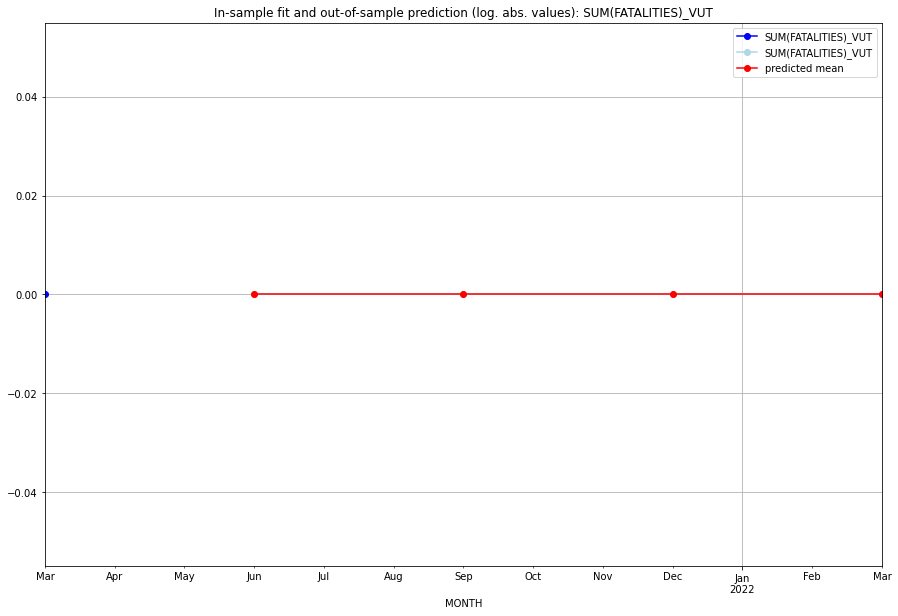

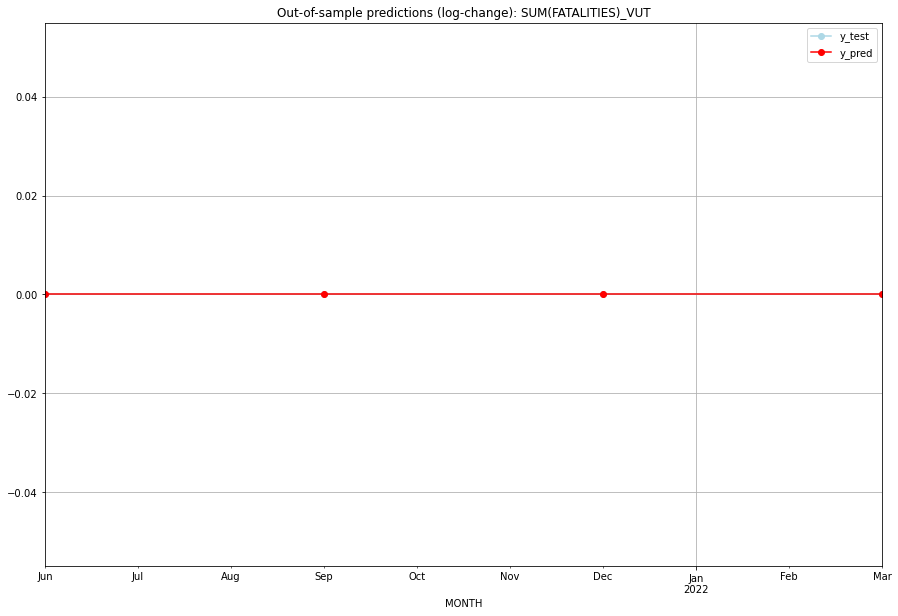

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   VUT   
1 2021-07-01       0.0         0.0           0.0             0.0   VUT   
2 2021-10-01       0.0         0.0           0.0             0.0   VUT   
3 2022-01-01       0.0         0.0           0.0             0.0   VUT   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## WLF (224/234) #########
0
Neighbor countries: []
Getting Data for WLF
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 0)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


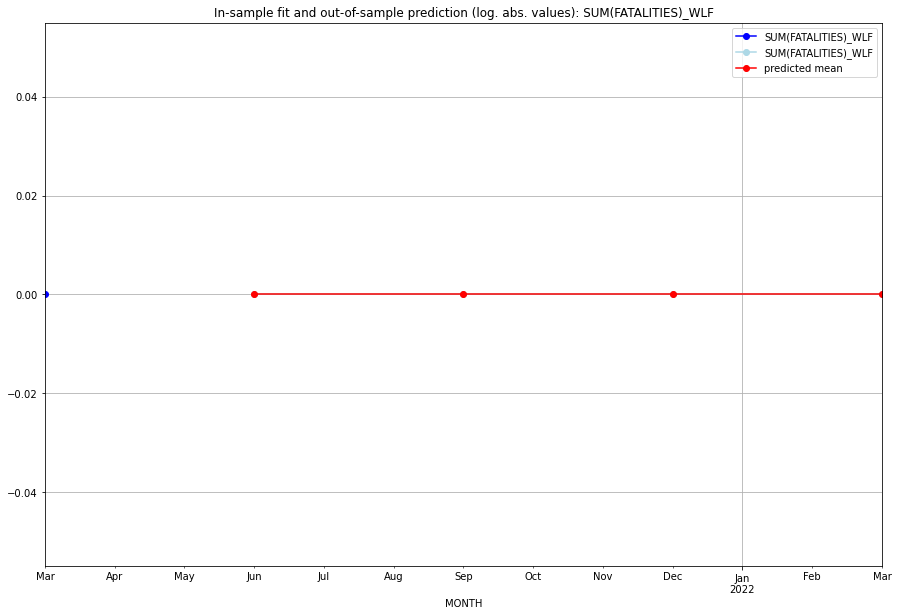

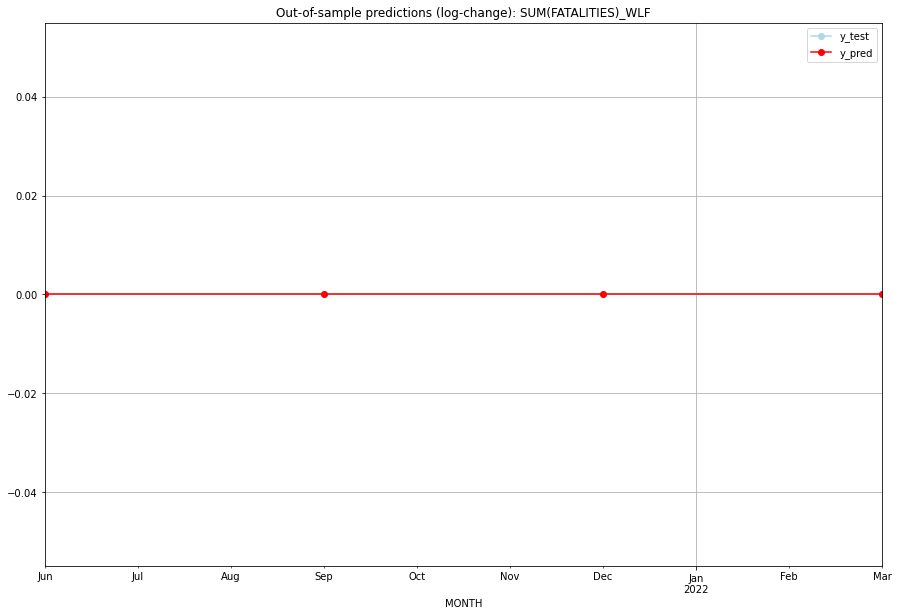

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   WLF   
1 2021-07-01       0.0         0.0           0.0             0.0   WLF   
2 2021-10-01       0.0         0.0           0.0             0.0   WLF   
3 2022-01-01       0.0         0.0           0.0             0.0   WLF   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## WSM (225/234) #########
0
Neighbor countries: []
Getting Data for WSM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (5, 0)
y: (5, 1)
------------------------------------------------
Training started.
GridSearchCV failed. Insufficient data for cross validation.
No model fitted --> Prediction with Naive Model 


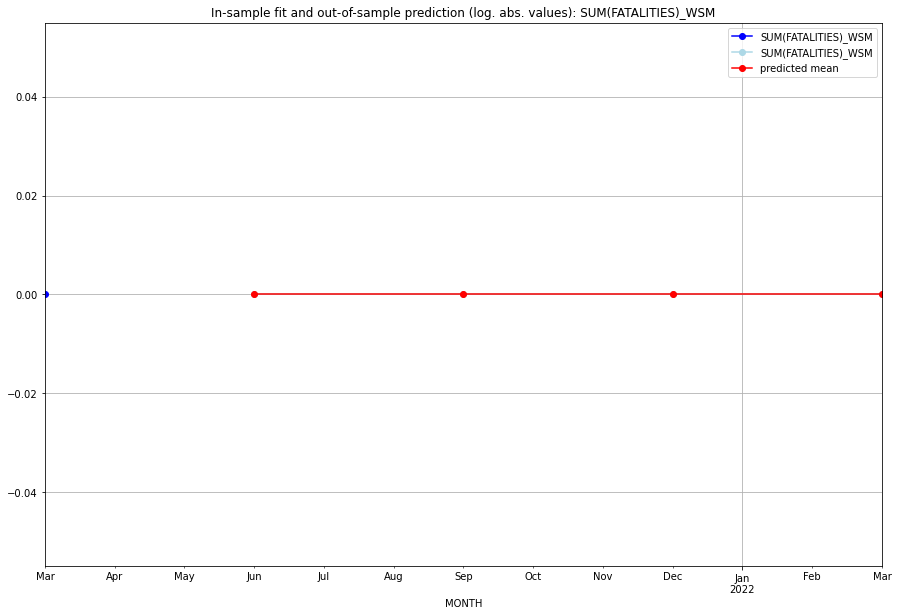

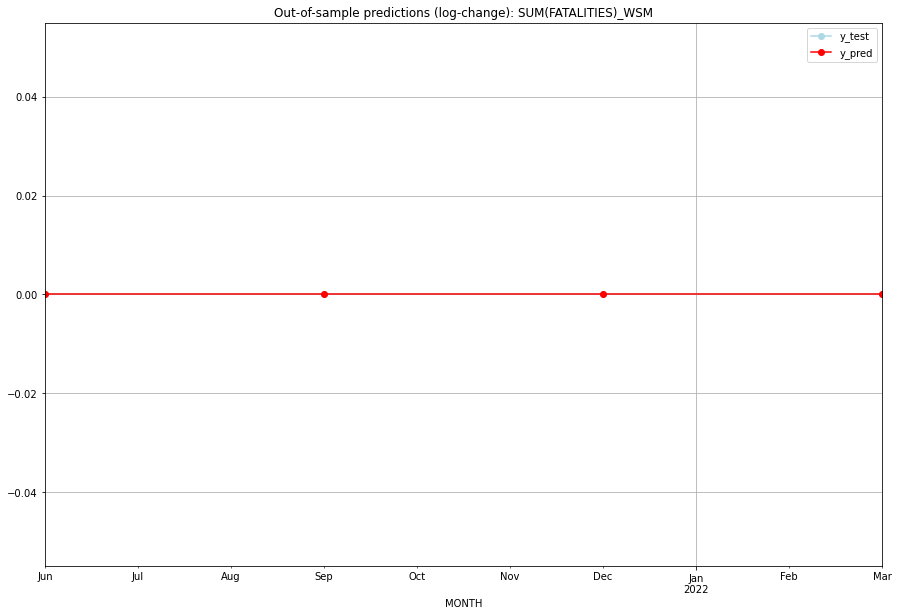

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   WSM   
1 2021-07-01       0.0         0.0           0.0             0.0   WSM   
2 2021-10-01       0.0         0.0           0.0             0.0   WSM   
3 2022-01-01       0.0         0.0           0.0             0.0   WSM   

   PARAMETERS  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
Execution time: 00:01
######## XAR (226/234) #########
0
Neighbor countries: []
Getting Data for XAR
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 parameter combinations are tested.


  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], 'cv_score': 1.0193104839938416, 'fold_results': [1.8629056774873547, 0.45814536593707755, 0.8330511275438012, 1.151292546497023, 0.7911577025039509]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XAR   No. Observations:                   96
Model:                SARIMAX(0, 1, 0)   Log Likelihood                -175.942
Date:                 Wed, 19 Oct 2022   AIC                            353.885
Time:                         20:18:12   BIC                            356.439
Sample:                     04-30-1997   HQIC                           354.917
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

<Figure size 432x288 with 0 Axes>

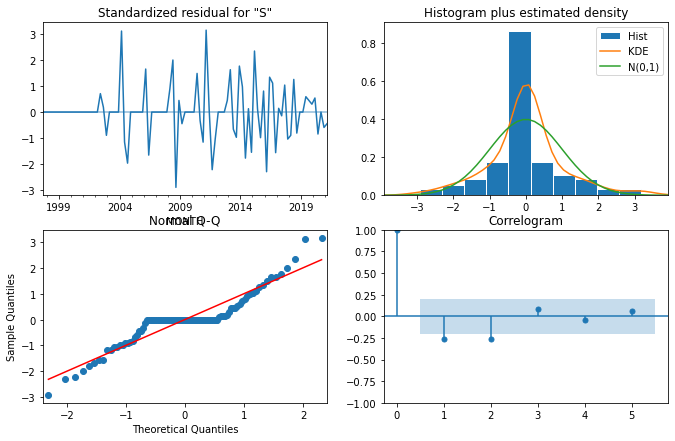

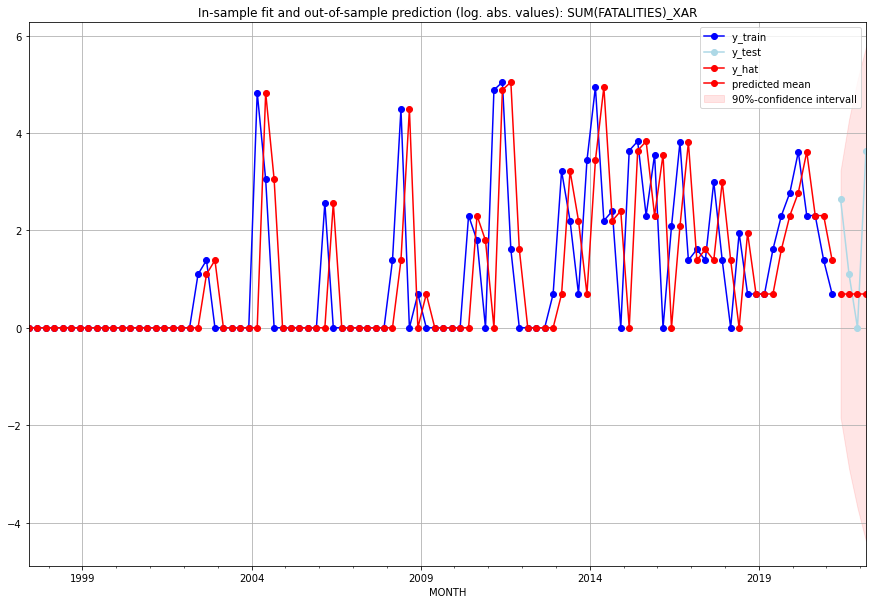

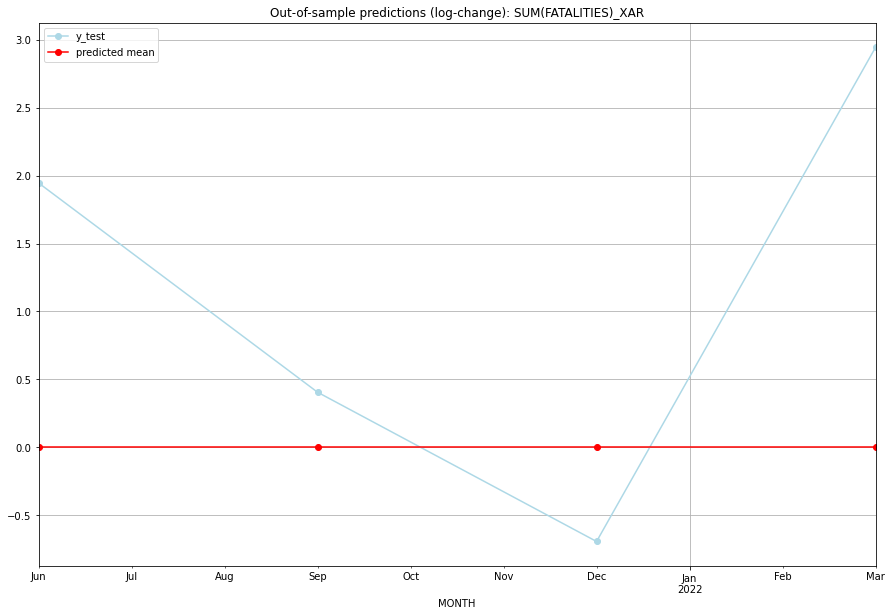

TADDA: 1.4972403542224657
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       1.0        13.0           0.0        1.945910   XAR   
1 2021-07-01       1.0         2.0           0.0        0.405465   XAR   
2 2021-10-01       1.0         0.0           0.0       -0.693147   XAR   
3 2022-01-01       1.0        37.0           0.0        2.944439   XAR   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 01:58
######## XIT (227/234) #########
0
Neighbor countries: []
Getting Data for XIT
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU co

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], 'cv_score': 0.0, 'fold_results': [0.0, 0.0, 0.0, 0.0, 0.0]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XIT   No. Observations:                   96
Model:                         SARIMAX   Log Likelihood                 -14.931
Date:                 Wed, 19 Oct 2022   AIC                             31.863
Time:                         20:20:28   BIC                             34.427
Sample:                     04-30-1997   HQIC                            32.899
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0799      0.002     37.614      0.000     

<Figure size 432x288 with 0 Axes>

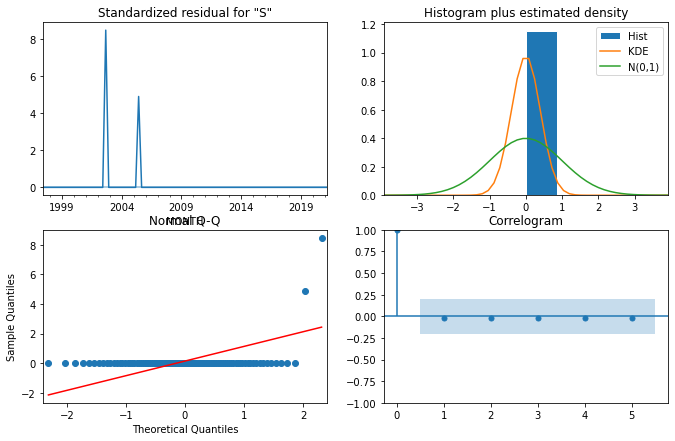

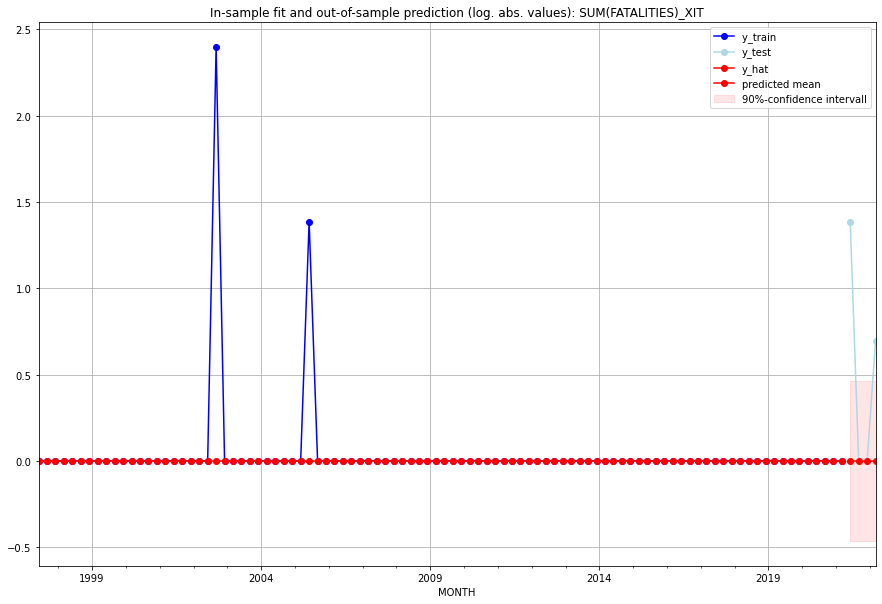

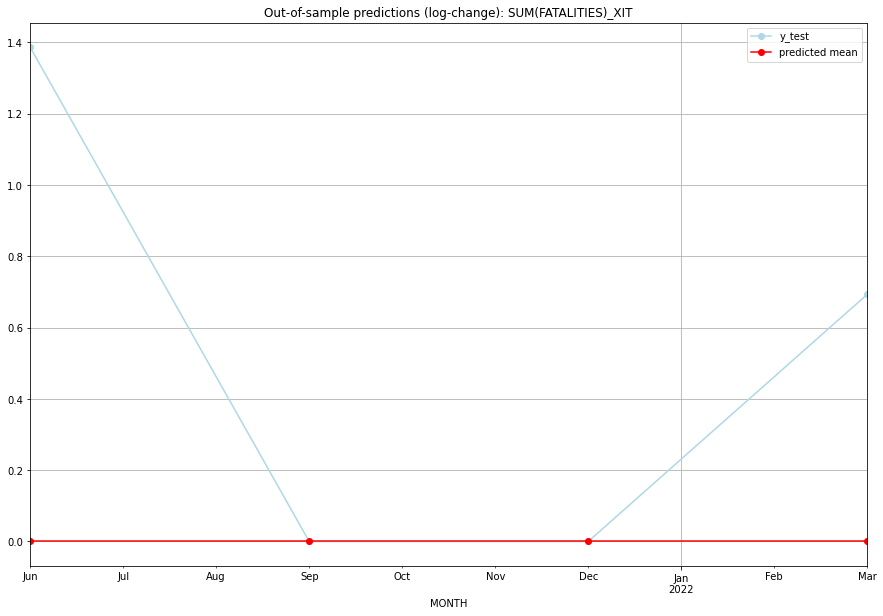

TADDA: 0.5198603854199589
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         3.0           0.0        1.386294   XIT   
1 2021-07-01       0.0         0.0           0.0        0.000000   XIT   
2 2021-10-01       0.0         0.0           0.0        0.000000   XIT   
3 2022-01-01       0.0         1.0           0.0        0.693147   XIT   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 02:15
######## XKK (228/234) #########
0
Neighbor countries: []
Getting Data for XKK
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU co

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], 'cv_score': 0.08958797346140275, 'fold_results': [0.0, 0.0, 0.0, 0.0, 0.44793986730701374]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XKK   No. Observations:                   96
Model:                         SARIMAX   Log Likelihood                 -90.179
Date:                 Wed, 19 Oct 2022   AIC                            182.359
Time:                         20:23:04   BIC                            184.923
Sample:                     04-30-1997   HQIC                           183.395
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3832      

<Figure size 432x288 with 0 Axes>

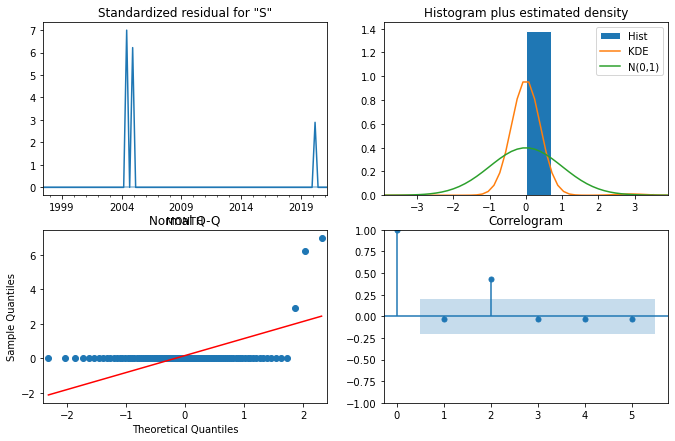

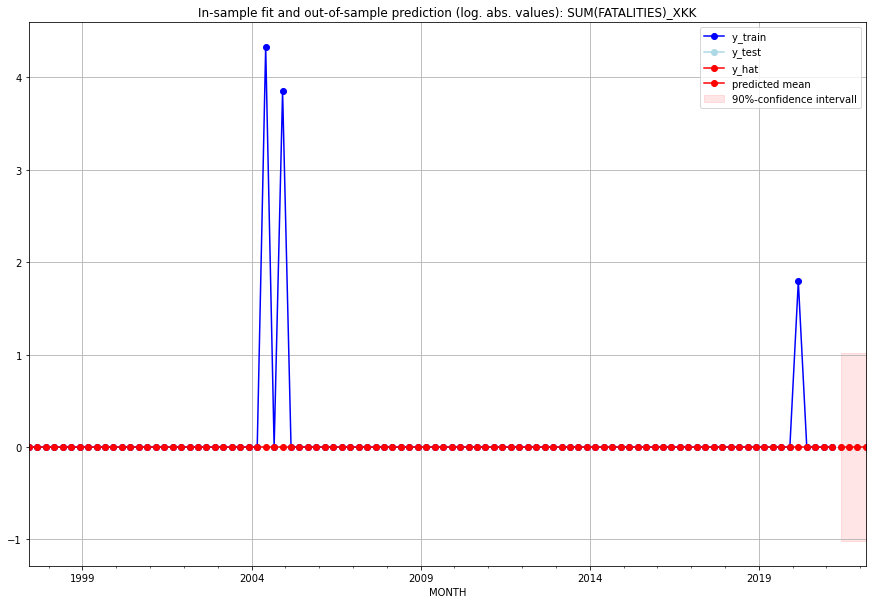

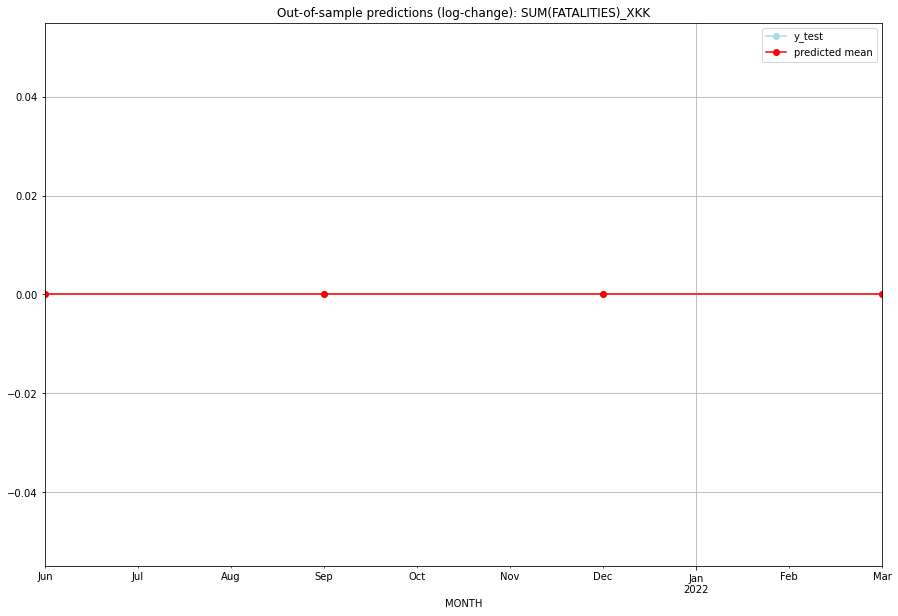

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   XKK   
1 2021-07-01       0.0         0.0           0.0             0.0   XKK   
2 2021-10-01       0.0         0.0           0.0             0.0   XKK   
3 2022-01-01       0.0         0.0           0.0             0.0   XKK   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 02:36
######## XKO (229/234) #########
0
Neighbor countries: []
Getting Data for XKO
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 paramete

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], 'cv_score': 0.0, 'fold_results': [0.0, 0.0]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_XKO   No. Observations:                   13
Model:                         SARIMAX   Log Likelihood                  -7.471
Date:                 Wed, 19 Oct 2022   AIC                             16.941
Time:                         20:23:29   BIC                             17.506
Sample:                     01-31-2018   HQIC                            16.825
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1848      0.037      5.048      0.000       0.113       0

<Figure size 432x288 with 0 Axes>

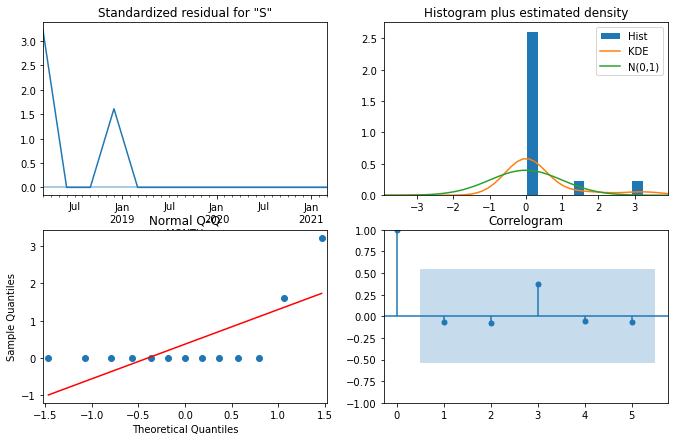

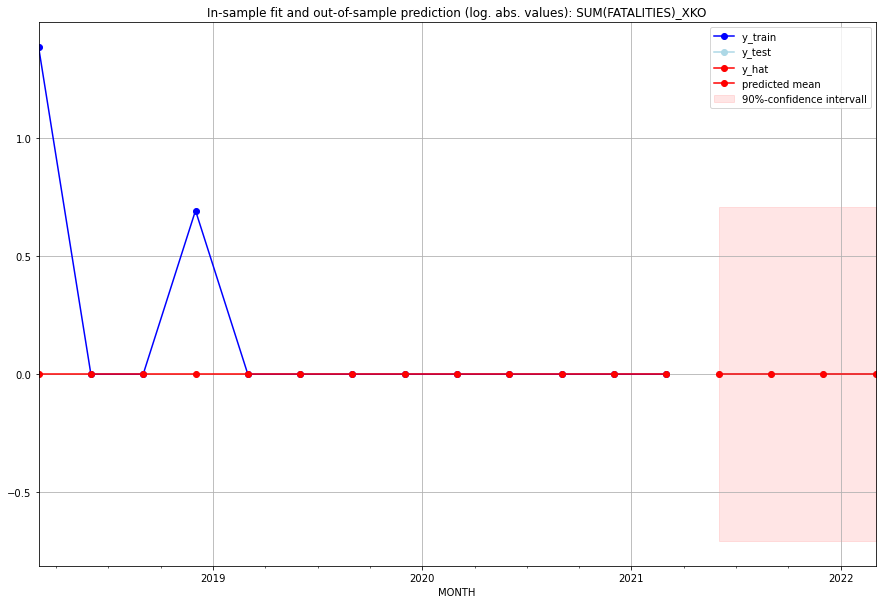

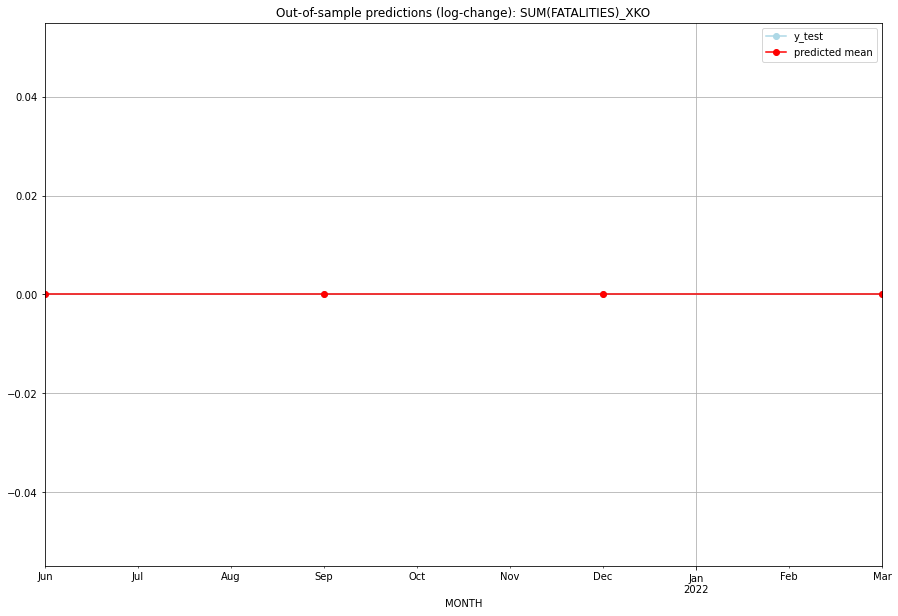

TADDA: 0.0
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       0.0         0.0           0.0             0.0   XKO   
1 2021-07-01       0.0         0.0           0.0             0.0   XKO   
2 2021-10-01       0.0         0.0           0.0             0.0   XKO   
3 2022-01-01       0.0         0.0           0.0             0.0   XKO   

                                          PARAMETERS  
0  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 0, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 00:23
######## XNC (230/234) #########
0
Neighbor countries: []
Getting Data for XNC
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (17, 0)
y: (17, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU cores:
576 paramete

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], 'cv_score': 0.0, 'fold_results': [nan, 0.0]}
Training finished.
                                     SARIMAX Results                                     
Dep. Variable:               SUM(FATALITIES)_XNC   No. Observations:                   13
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                  -6.093
Date:                           Wed, 19 Oct 2022   AIC                             16.186
Time:                                   20:23:59   BIC                             16.345
Sample:                               01-31-2018   HQIC                            15.115
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

<Figure size 432x288 with 0 Axes>

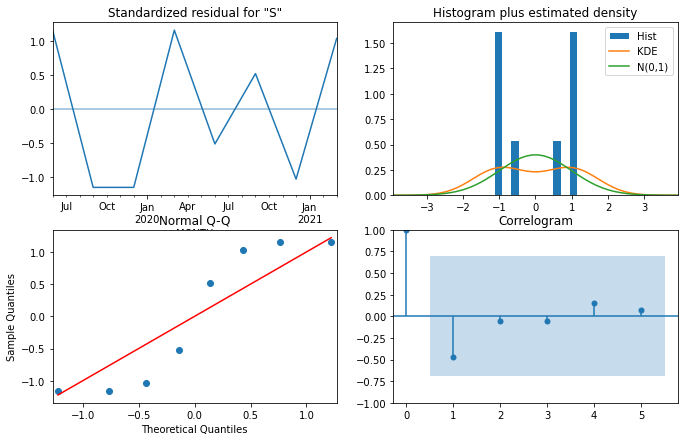

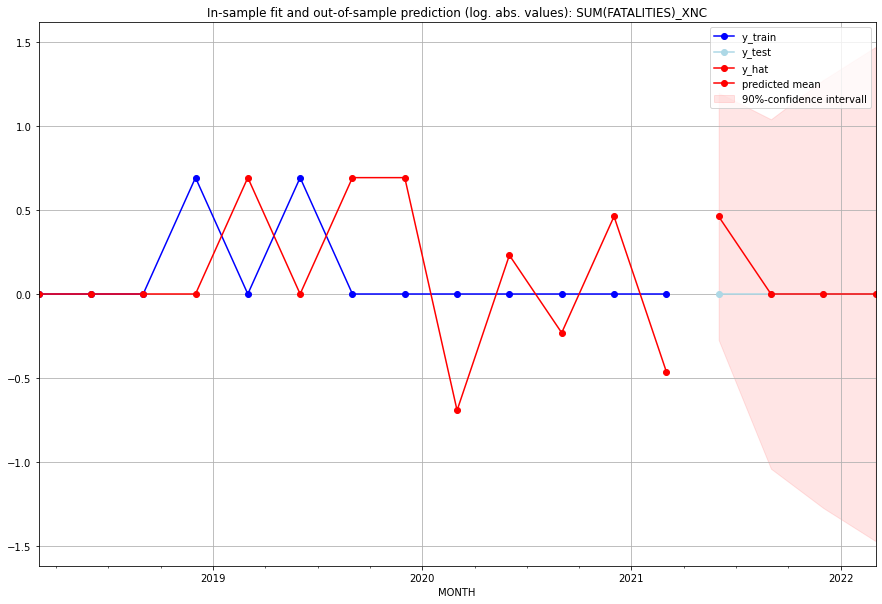

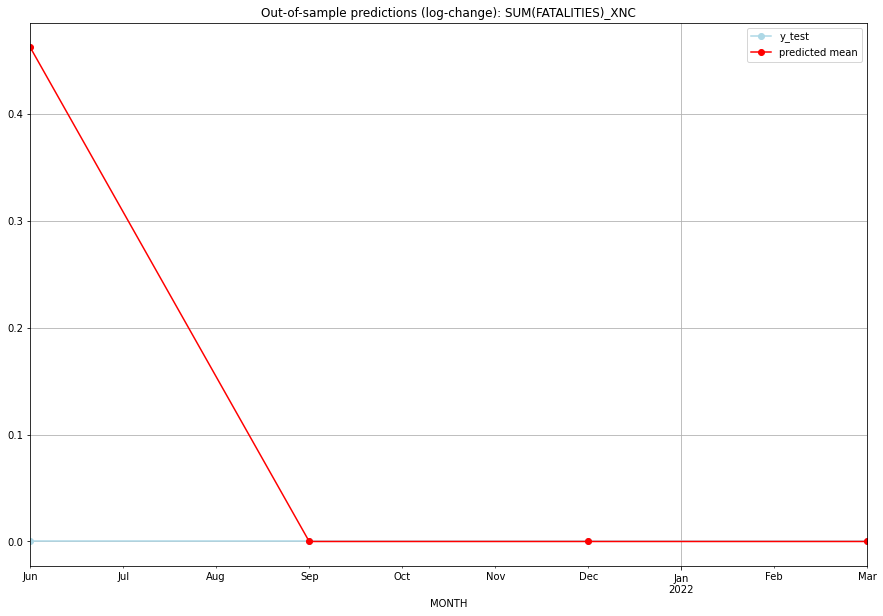

TADDA: 0.11552782792254676
Evaluation finished.
       MONTH      FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  5.874220e-01         0.0  4.621113e-01             0.0   XNC   
1 2021-07-01  1.363001e-10         0.0  1.363001e-10             0.0   XNC   
2 2021-10-01  9.930656e-11         0.0  9.930658e-11             0.0   XNC   
3 2022-01-01  9.879919e-11         0.0  9.879917e-11             0.0   XNC   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
1  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
2  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
3  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...  
Execution time: 00:30
######## YEM (231/234) #########
0
Neighbor countries: []
Getting Data for YEM
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (29, 0)
y: (29, 1)
------------------------------------------------
Training started.
Start GRIDSEA

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (1, 1, 3), (0, 0, 0, 4), 'n'], 'cv_score': 0.26357098329827855, 'fold_results': [0.2973938111036474, 0.33240705654140523, nan, 0.27850926354669525, 0.14597380200136634]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_YEM   No. Observations:                   25
Model:                SARIMAX(1, 1, 3)   Log Likelihood                  -9.954
Date:                 Wed, 19 Oct 2022   AIC                             29.908
Time:                         20:25:41   BIC                             35.799
Sample:                     01-31-2015   HQIC                            31.471
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

<Figure size 432x288 with 0 Axes>

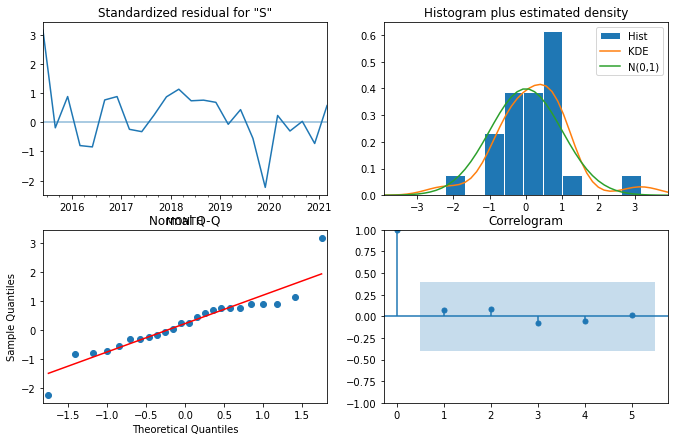

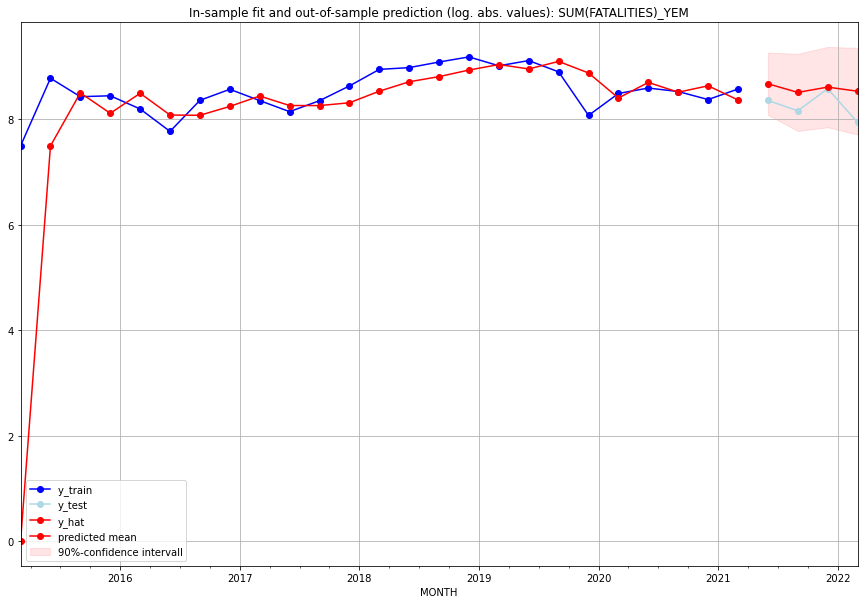

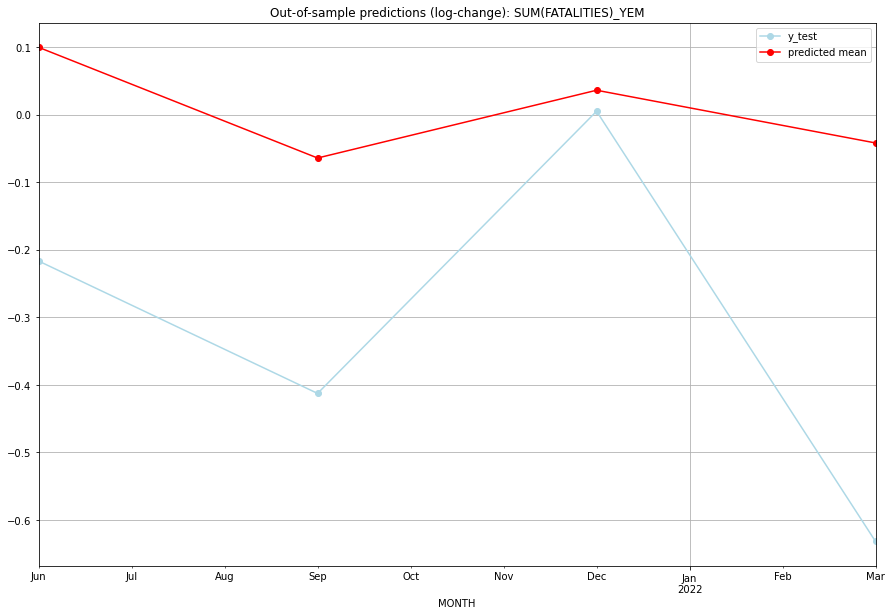

TADDA: 0.34636341656409564
Evaluation finished.
       MONTH     FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  5842.648001      4258.0      0.099726       -0.216595   YEM   
1 2021-07-01  4959.459735      3500.0     -0.064131       -0.412581   YEM   
2 2021-10-01  5482.885486      5315.0      0.036185        0.005092   YEM   
3 2022-01-01  5071.126623      2811.0     -0.041869       -0.631733   YEM   

                                          PARAMETERS  
0  {'params': [0, (1, 1, 3), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (1, 1, 3), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (1, 1, 3), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (1, 1, 3), (0, 0, 0, 4), 'n'], ...  
Execution time: 01:42
######## ZAF (232/234) #########
0
Neighbor countries: []
Getting Data for ZAF
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (3, 0, 3), (1, 0, 0, 4), 'n'], 'cv_score': 0.35834424730648395, 'fold_results': [0.3489601986272055, 0.3597402574407488, 0.17981964337357903, 0.7633625691076786, 0.13983856798320782]}
Training finished.
                                     SARIMAX Results                                      
Dep. Variable:                SUM(FATALITIES)_ZAF   No. Observations:                   96
Model:             SARIMAX(3, 0, 3)x(1, 0, [], 4)   Log Likelihood                -109.470
Date:                            Wed, 19 Oct 2022   AIC                            234.940
Time:                                    20:28:13   BIC                            255.455
Sample:                                04-30-1997   HQIC                           243.233
                                     - 01-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err    

<Figure size 432x288 with 0 Axes>

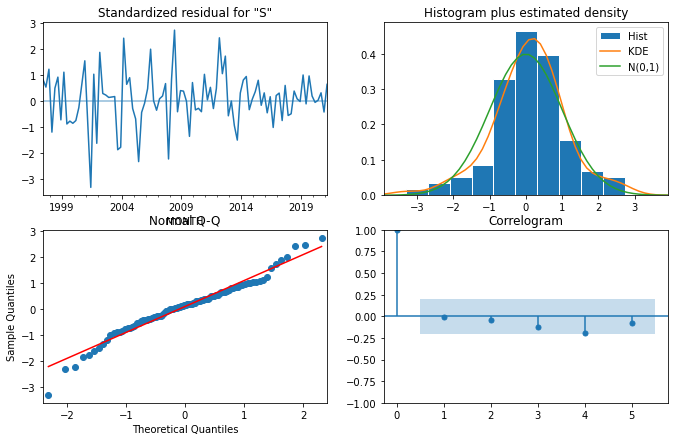

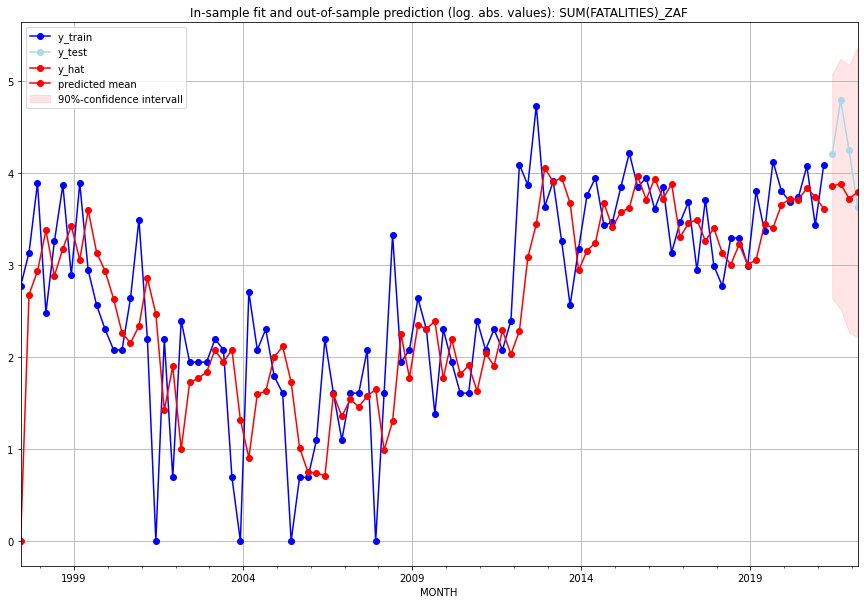

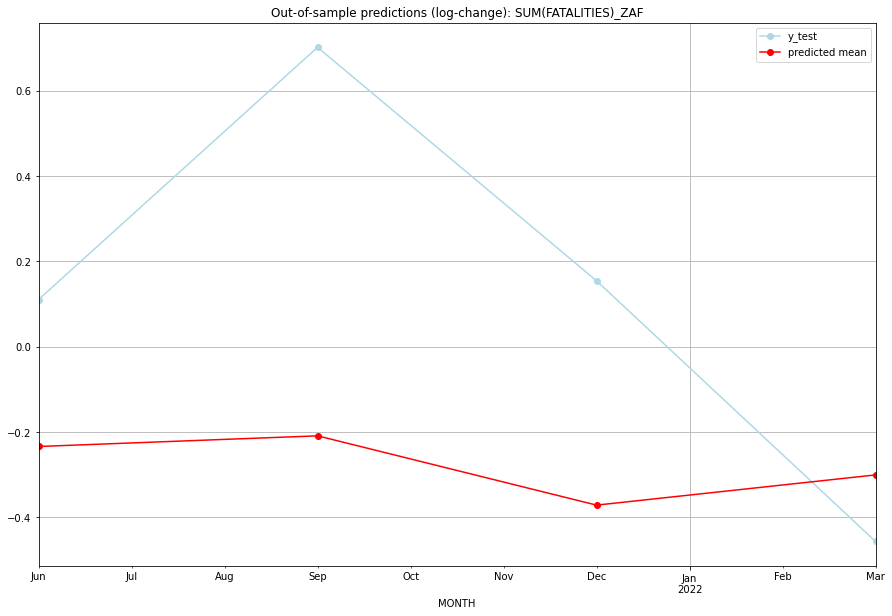

TADDA: 0.6878847851875667
Evaluation finished.
       MONTH   FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01  46.476516        66.0     -0.234109        0.110348   ZAF   
1 2021-07-01  47.676745       120.0     -0.209143        0.701446   ZAF   
2 2021-10-01  40.380907        69.0     -0.371525        0.154151   ZAF   
3 2022-01-01  43.417147        37.0     -0.300719       -0.456758   ZAF   

                                          PARAMETERS  
0  {'params': [0, (3, 0, 3), (1, 0, 0, 4), 'n'], ...  
1  {'params': [0, (3, 0, 3), (1, 0, 0, 4), 'n'], ...  
2  {'params': [0, (3, 0, 3), (1, 0, 0, 4), 'n'], ...  
3  {'params': [0, (3, 0, 3), (1, 0, 0, 4), 'n'], ...  
Execution time: 02:32
######## ZMB (233/234) #########
0
Neighbor countries: []
Getting Data for ZMB
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 C

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], 'cv_score': 0.7043129785983078, 'fold_results': [0.4479398673070139, 0.34657359027997264, 0.7996682793876702, 0.9395722263715257, 0.987810929645357]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_ZMB   No. Observations:                   96
Model:                SARIMAX(0, 1, 0)   Log Likelihood                -149.768
Date:                 Wed, 19 Oct 2022   AIC                            301.536
Time:                         20:30:16   BIC                            304.090
Sample:                     04-30-1997   HQIC                           302.568
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

<Figure size 432x288 with 0 Axes>

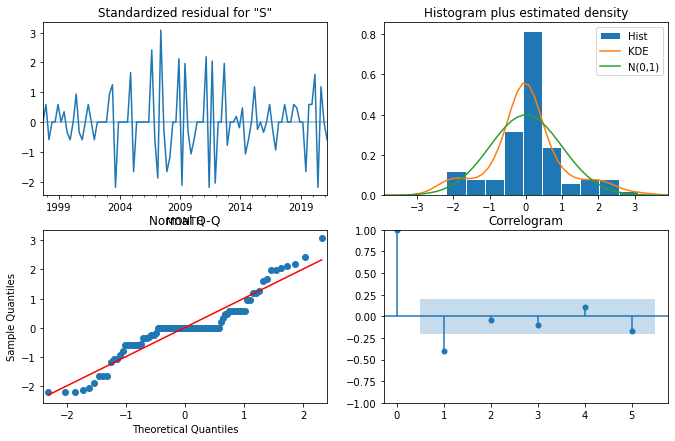

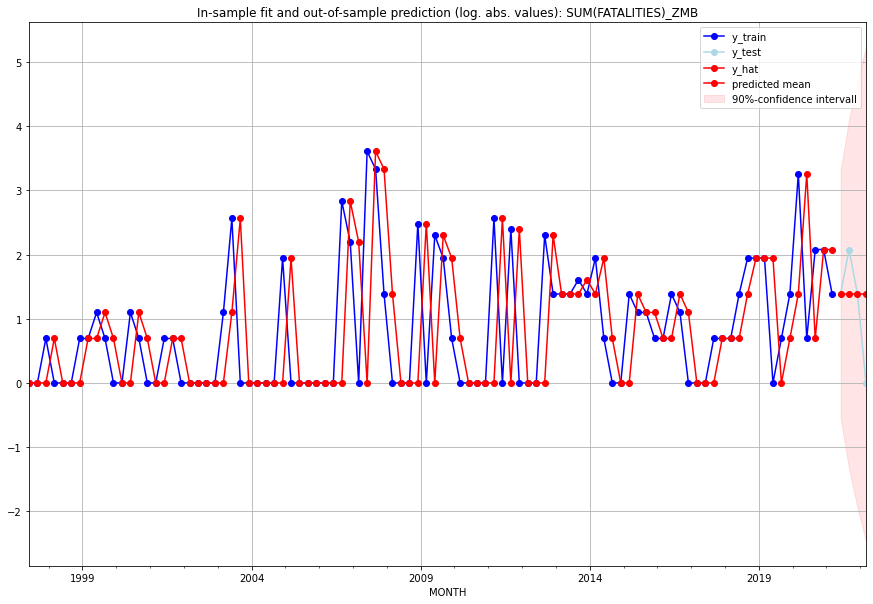

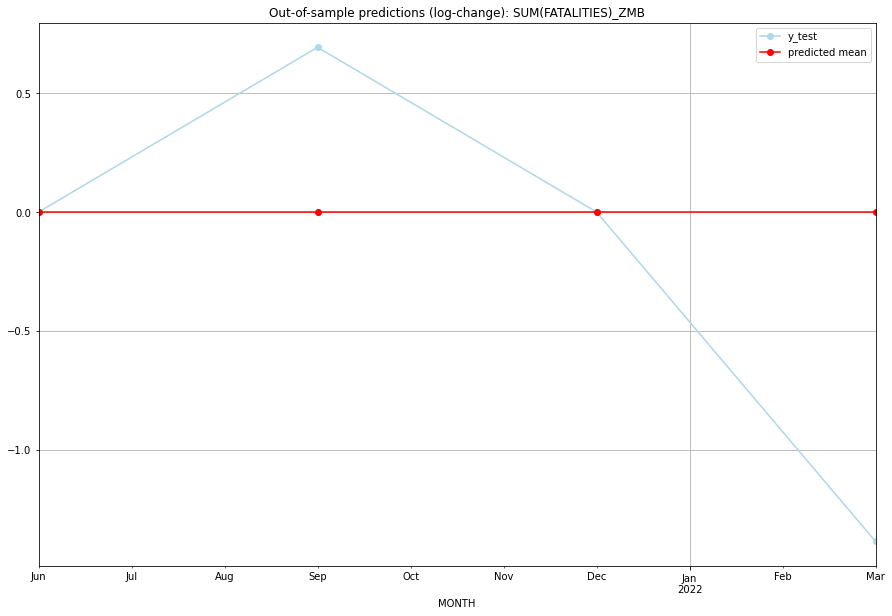

TADDA: 0.5198603854199593
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       3.0         3.0  2.220446e-16        0.000000   ZMB   
1 2021-07-01       3.0         7.0  2.220446e-16        0.693147   ZMB   
2 2021-10-01       3.0         3.0  2.220446e-16        0.000000   ZMB   
3 2022-01-01       3.0         0.0  2.220446e-16       -1.386294   ZMB   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 02:06
######## ZWE (234/234) #########
0
Neighbor countries: []
Getting Data for ZWE
IMF, WB, ACLED loaded
adjusting y for lags
adjusting X for lags
GET DATA finished.
X: (100, 0)
y: (100, 1)
------------------------------------------------
Training started.
Start GRIDSEARCH CV on 48 CPU co

  0%|          | 0/576 [00:00<?, ?it/s]



Best CV-Results
{'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], 'cv_score': 0.6494415992389904, 'fold_results': [0.820853586501443, 0.5858517718785753, 0.3587711313223305, 0.631432161077064, 0.8502993454155389]}
Training finished.
                                SARIMAX Results                                
Dep. Variable:     SUM(FATALITIES)_ZWE   No. Observations:                   96
Model:                SARIMAX(0, 1, 0)   Log Likelihood                -144.010
Date:                 Wed, 19 Oct 2022   AIC                            290.021
Time:                         20:32:24   BIC                            292.575
Sample:                     04-30-1997   HQIC                           291.053
                          - 01-31-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

<Figure size 432x288 with 0 Axes>

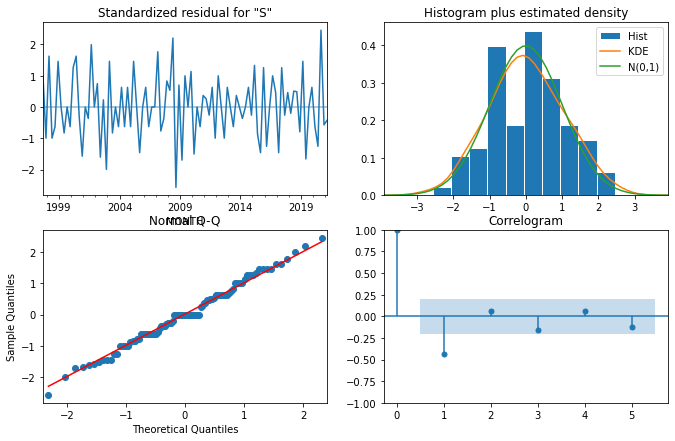

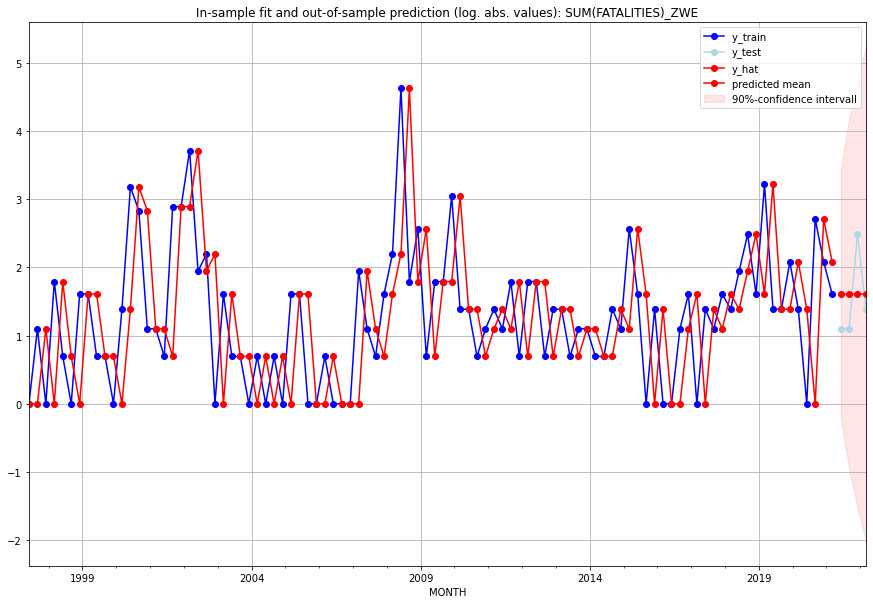

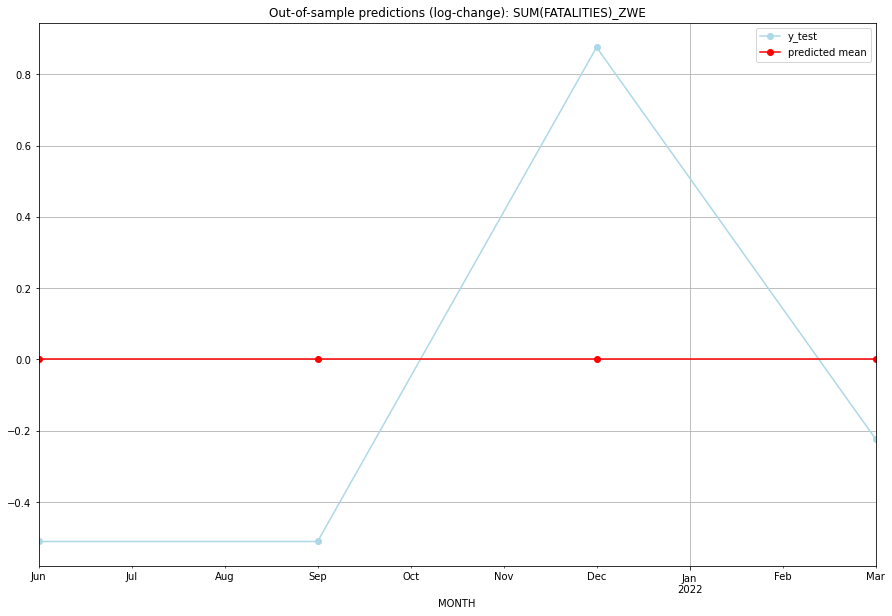

TADDA: 0.5300658840500231
Evaluation finished.
       MONTH  FAT_PRED  FAT_ACTUAL  LC(FAT_PRED)  LC(FAT_ACTUAL) GID_0  \
0 2021-04-01       4.0         2.0  2.220446e-16       -0.510826   ZWE   
1 2021-07-01       4.0         2.0  2.220446e-16       -0.510826   ZWE   
2 2021-10-01       4.0        11.0  2.220446e-16        0.875469   ZWE   
3 2022-01-01       4.0         3.0  2.220446e-16       -0.223144   ZWE   

                                          PARAMETERS  
0  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
1  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
2  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
3  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...  
Execution time: 02:07


In [8]:
# warnings.simplefilter(action='ignore')

sarimax_res = pd.DataFrame(columns=["MONTH", "FAT_PRED", "FAT_ACTUAL", "LC(FAT_PRED)", "LC(FAT_ACTUAL)", "GID_0", "PARAMETERS", "TIMESTAMP"])
csv_file = "../data/"+MODEL_NAME+"_PREDICTIONS.csv"

if os.path.exists(csv_file):
    existing_res = pd.read_csv("../data/"+MODEL_NAME+"_PREDICTIONS.csv")
    # print(existing_res)
    print("File already exists.")
    
else:
    sarimax_res.to_csv(csv_file, index=False, mode="a", header=True)
    existing_res = sarimax_res

for i, g in enumerate(gid_list):
# for i, g in enumerate(["XNC"]):
    print("######## "+g+" ("+str(i+1)+"/"+str(len(gid_list))+") #########")
    # print(existing_res[existing_res["GID_0"] == g])
    print(len(existing_res[existing_res["GID_0"] == g]))
    
    
    # skip country if results already exiast
    if len(existing_res[existing_res["GID_0"] == g]) > 0:
        print("Model for this country has already been fitted.")
        continue
    
    # add time series of neighboring  countries as predictor variables

    if NEIGHBORS == True:
        neighbor = gid0_neighbors[gid0_neighbors["GID_0"] == g]["NEIGHBOUR"].tolist()
    else:
        neighbor = []
    print("Neighbor countries: "+ str(neighbor))

    # measure time 
    st = time.time()

    res = sarimax(target_variable = TARGET_VARIABLE,
                  target_country = g,
                  predictor_countries = neighbor,
                  n_lags_X = N_LAGS_X,
                  seasonal_periodicity = SEASONAL_PERIODICITY)

    # append country results to csv with timestamp
    res["TIMESTAMP"] = datetime.datetime.now()
    
    res.to_csv(csv_file, index=False, mode="a", header=False)

    et = time.time()
    elapsed_time = et - st
    print('Execution time:', time.strftime("%M:%S", time.gmtime(elapsed_time)))

    sarimax_res = pd.concat([sarimax_res, res], ignore_index=True)

    # break

In [9]:
# varimax_res.to_csv("../data/"+MODEL_NAME+"_PREDICTIONS.csv", index=False)

In [10]:
sarimax_res

MONTH    FAT_PRED FAT_ACTUAL LC(FAT_PRED) LC(FAT_ACTUAL)  \
0    2021-04-01 00:00:00         0.0        1.0    -0.693147            0.0   
1    2021-07-01 00:00:00         0.0        0.0    -0.693147      -0.693147   
2    2021-10-01 00:00:00         0.0        0.0    -0.693147      -0.693147   
3    2022-01-01 00:00:00         0.0        0.0    -0.693147      -0.693147   
4    2021-04-01 00:00:00  147.568751       90.0     0.156861      -0.333328   
..                   ...         ...        ...          ...            ...   
195  2022-01-01 00:00:00         3.0        0.0          0.0      -1.386294   
196  2021-04-01 00:00:00         4.0        2.0          0.0      -0.510826   
197  2021-07-01 00:00:00         4.0        2.0          0.0      -0.510826   
198  2021-10-01 00:00:00         4.0       11.0          0.0       0.875469   
199  2022-01-01 00:00:00         4.0        3.0          0.0      -0.223144   

    GID_0                                         PARAMETERS  \
0     SLE  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...   
1     SLE  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...   
2     SLE  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...   
3     SLE  {'params': [0, (0, 1, 0), (1, 1, 0, 4), 'n'], ...   
4     SLV  {'params': [0, (1, 1, 0), (2, 1, 2, 4), 'n'], ...   
..    ...                                                ...   
195   ZMB  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...   
196   ZWE  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...   
197   ZWE  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...   
198   ZWE  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...   
199   ZWE  {'params': [0, (0, 1, 0), (0, 0, 0, 4), 'n'], ...   

                      TIMESTAMP  
0    2022-10-19 19:37:44.896177  
1    2022-10-19 19:37:44.896177  
2    2022-10-19 19:37:44.896177  
3    2022-10-19 19:37:44.896177  
4    2022-10-19 19:38:49.645844  
..                          ...  
195  2022-10-19 20:30:22.502188  
196  2022-10-19 20:32:29.576631  
197  2022-10-19 20:32:29.576631  
198  2022-10-19 20:32:29.576631  
199  2022-10-19 20:32:29.576631  

[200 rows x 8 columns]